**Sommaire**

1. **Notre Objectif** 
2. **Les librairies utiles jusqu’au machine learning ?** 
3. **Quelles sont les adresses sybils ayant interagi avec ethereum pour faire des échanges ?**
4. **Description du jeu de données `df` (des.trades)**
5. **Nuancer `tx_from` et `taker`**
6.  **Que permet Blocknative**  
7. **Quelle donnée de blocknative allons-nous extraire ?**  
8. **Première filtration de nos données provenant de blocknative**
9. **Description des données provenant de blocknative**
10. **Prétraitement du Jeu de Données `df_union_2024_01_15`**  
11. **Création de la variable qui capture le premier temps officiel de confirmation**  
12. **Création de la Variable `mempool_arrived_time_before_confirmed`**  
13. **Étape Finale du Prétraitement et Recherche des Couples Réalisant du Front-Running**  
14. **Dictionnaire pour récolter les couples pouvant être acteur du front-running**  
15. **Exploitation de `sybil_to_matched_hashes`**
16. **Ajout des variables crées dans df**
17. **Construction du jeu de données finale pour la classification binaire des swap à haut potentiel de front-running**  
18. **Analyse du Dataset**  
19. **Sélection des Variables pour l'Analyse**  
20. **Analyses des données du jeu de données finale**  
21. **Classification binaire du jeu de données finale**
22. **Sandwich Attack**  
23. **Conclusion**   

**Visualisations (Partie 15) :**  
- **Visualisation 1 :** Densité et boxplots pour `df_fr`  
- **Visualisation 2 :** Densité et boxplots pour `df_no_fr`  
- **Visualisation 3 :** Densité superposée de `df_analyse` pour toutes les variables numériques  
- **Visualisation 4 :** Matrices de corrélation  

## Notre objectif

Cette étude vise à démontrer que le comportement des adresses Sybil peut être lié à des actions telles que le front-running. La stratégie consiste à suivre l'activité d'adresses Sybil identifiées à partir d'une base de données spécifique. En utilisant des techniques d'interrogation précises sur nos données, nous cherchons à mettre en évidence des schémas de comportement caractéristiques du front-running. L'objectif final est d'étiqueter ces données afin de les utiliser pour une classification binaire, permettant ainsi de détecter automatiquement des transactions à haut potentiels de front-running.

## Le front running dans le contexte financier général

Selon wikipédia, on apprend que le concept de **"front running"**, également appelé **"tailgating"** est une pratique financière consistant à exécuter une transaction sur un actif (comme des actions, des options, des contrats à terme, des dérivés ou des swaps basés sur des titres) en se basant sur une information privilégiée non publique, avant qu'une grosse transaction (un bloc d'ordres) soit effectuée et influence le prix de cet actif.

### Explication détaillée :
- **Front running** : C'est une forme de **manipulation de marché** où une personne ou une institution, comme un courtier ou une firme de courtage, utilise des informations non publiques pour effectuer une transaction sur des titres pour son propre compte avant de traiter les ordres de ses clients.
- **But** : L'objectif est de tirer profit d'une hausse ou d'une baisse anticipée du prix d'un titre, en connaissant à l'avance qu'un ordre de grande taille va bientôt être exécuté et aura un impact sur le prix du marché.
- **Exemple** :
  - Un courtier pourrait acheter des actions pour son propre compte avant d'exécuter un ordre d'achat important pour un client, en sachant que cet ordre fera monter le prix. Il peut ensuite vendre ces actions à un prix plus élevé.
  - Inversement, il pourrait vendre des actions avant d'exécuter un ordre de vente important pour un client, anticipant que le prix va baisser.
  
### Légalité :
- Le **front running** est considéré comme illégal dans de nombreux marchés financiers parce qu'il s'agit d'une forme d'abus de confiance et d'exploitation d'informations non publiques à des fins personnelles, au détriment des clients ou du marché en général.
  
### Implication :
- Souvent, ce type de manipulation est commis par des courtiers ou des sociétés de courtage qui traitent des ordres pour le compte de leurs clients, mais cela peut également impliquer des investisseurs institutionnels ou individuels ayant accès à des informations privilégiées.
  
### Conséquences :
- **Interdiction** : Cette pratique est interdite, car elle permet aux fraudeurs de réaliser des profits grâce à des informations confidentielles, au détriment de leurs propres clients, de la transaction importante (bloc d'ordres), ou de l'intégrité du marché.

En somme, le front running est une pratique abusive qui profite des déséquilibres créés par des ordres importants et non encore exécutés, en utilisant des informations non publiques à des fins personnelles.

## Le front running dans le contexte blockchain ( celui sur les plateformes d'échanges décentralisées ) ?

Le **front-running** dans le contexte des transactions de swap sur un DEX (échange décentralisé) consiste à surveiller l'activité du mempool pour repérer une transaction de swap susceptible d'être exploitée pour un arbitrage. Un bot va alors copier cette transaction de swap en augmentant les frais de gaz pour s'assurer que sa propre transaction soit validée avant celle de la victime. L'objectif du bot est d'acheter le token que la victime cherche à acquérir à un prix inférieur, puis de revendre immédiatement ce même token après la validation de la transaction de la victime, lorsque le prix aura augmenté en raison de la demande créée par la transaction de celle-ci, réalisant ainsi un profit.

Pour analyser une telle situation dans un swap, les informations suivantes sont nécessaires :
- **L'instant d'arrivée de la transaction dans le mempool** (pour comprendre le timing du front-running).
- **Le montant des frais de gaz dépensés pour la transaction** (pour vérifier si le bot a augmenté ses frais pour devancer la transaction de la victime).
- **Le type de token acheté** lors du swap.
- **L'instant de validation de la transaction** (pour déterminer l'ordre dans lequel les transactions ont été validées).

# Quelles sont les adresses sybils ayant interagi avec ethereum pour faire des échanges ?

Les adresses "sybil" proviennent d'une table appelée `dune.lillypad.dataset_l0_blacklist`, qui contient des adresses identifiées comme problématiques ou malveillantes. Cette table est utilisée pour filtrer et analyser les transactions, en mettant l'accent sur celles impliquant des acteurs considérés comme indésirables ou frauduleux.

### Exemple de requête SQL

Voici un aperçu de la requête utilisée pour extraire les adresses Sybil à partir de la base de données **Dune** :

```sql
SELECT
    address
FROM
    dune.lillypad.dataset_l0_blacklist;


Grâce à **Dune Analytics**, nous avons pu obtenir des informations précieuses sur les échanges réalisés par des adresses spécifiques sur le réseau **Ethereum**. La requête que nous avons utilisée est accessible via l'URL suivante : [Dune Query 4044692](https://dune.com/queries/4044692). Cette requête s'appuie sur le schéma **DEX**, utilisant la table `trades`, qui fournit des enregistrements détaillés de chaque transaction effectuée sur des plateformes d'échange décentralisées. Ces enregistrements incluent des informations sur les tokens échangés, les adresses impliquées, ainsi que des données temporelles et financières.

Pour maximiser la quantité de données exploitables, nous avons sélectionné une période d'activité d'**heure**. Voici la structure de la requête utilisée :

```sql
WITH sybil_list AS (
  SELECT
    address
  FROM dune.lillypad.dataset_l0_blacklist
),
sybil_trades AS (
  SELECT
    token_bought_symbol,
    block_time AS sybil_trade_time
  FROM dex.trades
  WHERE
    blockchain = 'ethereum'
    AND taker IN (SELECT address FROM sybil_list)
    AND DATE(block_date) = CAST('2024-01-15' AS TIMESTAMP)
),
other_trades AS (
  SELECT
    *,
    CASE
      WHEN taker IN (SELECT address FROM sybil_list) THEN 1
      ELSE 0
    END AS made_by_sybil
  FROM dex.trades
  WHERE
    blockchain = 'ethereum'
    AND DATE(block_date) = CAST('2024-01-15' AS TIMESTAMP)
),
sybil_tokens AS (
  SELECT DISTINCT
    token_bought_symbol
  FROM sybil_trades
)
SELECT
  o.*,
  CASE
    WHEN o.taker IN (SELECT address FROM sybil_list) THEN 1
    ELSE 0
  END AS made_by_sybil
FROM other_trades AS o
JOIN sybil_tokens AS st
  ON o.token_bought_symbol = st.token_bought_symbol
WHERE EXTRACT(HOUR FROM o.block_time) in (6,7,8,9,10,11,12)
ORDER BY
  o.block_time;
```

La requête SQL sélectionne les transactions réalisées par des adresses figurant sur une liste noire lors d'une journée spécifique, en identifiant les tokens échangés et en marquant les transactions effectuées par ces adresses comme ayant été réalisées par un acteur malveillant, avec un focus particulier sur les échanges survenus à sur la plage horaire 06h00-13h00

### Construction de la requête sur Dune pour les données d'échanges

Notre requête principale va donc récolter les échanges fait sur la blockchain ethereum le 15 janvier 2024 qui est la journée la plus active pour ces adresses pour des swaps. Cette requête SQL permet d'identifier et de marquer les transactions sur Ethereum du 15 janvier 2024, où les tokens achetés sont les mêmes que ceux achetés par des adresses suspectées d'être des sybils, en classant ces transactions par ordre chronologique.

In [15]:
import pandas as pd

# Charger les données pour chaque heure de 6h00 à 13h00
df6h = pd.read_csv('/Users/dylan/DEX/DEX_6h.csv')   # Données de 6h00 à 7h00
df7h = pd.read_csv('/Users/dylan/DEX/DEX_7h.csv')   # Données de 7h00 à 8h00
df8h = pd.read_csv('/Users/dylan/DEX/DEX_8h.csv')   # Données de 8h00 à 9h00
df9h = pd.read_csv('/Users/dylan/DEX/DEX_9h.csv')   # Données de 9h00 à 10h00
df10h = pd.read_csv('/Users/dylan/DEX/DEX_10h.csv') # Données de 10h00 à 11h00
df11h = pd.read_csv('/Users/dylan/DEX/DEX_11h.csv') # Données de 11h00 à 12h00
df12h = pd.read_csv('/Users/dylan/DEX/DEX_12h.csv') # Données de 12h00 à 13h00

# Concaténer les DataFrames en un seul DataFrame
df = pd.concat([df6h, df7h, df8h, df9h, df10h, df11h, df12h], ignore_index=True)


In [16]:
df

blockchain  project version block_month                   block_date  \
0       ethereum  uniswap       3  2024-01-01  2024-01-15 00:00:00.000 UTC   
1       ethereum  uniswap       2  2024-01-01  2024-01-15 00:00:00.000 UTC   
2       ethereum  uniswap       2  2024-01-01  2024-01-15 00:00:00.000 UTC   
3       ethereum  uniswap       3  2024-01-01  2024-01-15 00:00:00.000 UTC   
4       ethereum  uniswap       3  2024-01-01  2024-01-15 00:00:00.000 UTC   
...          ...      ...     ...         ...                          ...   
42069   ethereum  uniswap       2  2024-01-01  2024-01-15 00:00:00.000 UTC   
42070   ethereum  uniswap       3  2024-01-01  2024-01-15 00:00:00.000 UTC   
42071   ethereum  uniswap       2  2024-01-01  2024-01-15 00:00:00.000 UTC   
42072   ethereum  uniswap       3  2024-01-01  2024-01-15 00:00:00.000 UTC   
42073   ethereum  uniswap       3  2024-01-01  2024-01-15 00:00:00.000 UTC   

                        block_time  block_number token_bought_symbol  \
0      2024-01-15 06:00:11.000 UTC    19010355.0                MEME   
1      2024-01-15 06:00:11.000 UTC    19010355.0                WETH   
2      2024-01-15 06:00:11.000 UTC    19010355.0                WYNN   
3      2024-01-15 06:00:11.000 UTC    19010355.0                MEME   
4      2024-01-15 06:00:11.000 UTC    19010355.0                  ML   
...                            ...           ...                 ...   
42069  2024-01-15 12:59:59.000 UTC    19012438.0                WETH   
42070  2024-01-15 12:59:59.000 UTC    19012438.0                MEME   
42071  2024-01-15 12:59:59.000 UTC    19012438.0                WETH   
42072  2024-01-15 12:59:59.000 UTC    19012438.0                MEME   
42073  2024-01-15 12:59:59.000 UTC    19012438.0                MEME   

      token_sold_symbol    token_pair  ...  \
0                  WETH     MEME-WETH  ...   
1                   SAM      SAM-WETH  ...   
2                  WETH     WETH-WYNN  ...   
3                  WETH     MEME-WETH  ...   
4                  WETH       ML-WETH  ...   
...                 ...           ...  ...   
42069           DIAMOND  DIAMOND-WETH  ...   
42070              WETH     MEME-WETH  ...   
42071           DIAMOND  DIAMOND-WETH  ...   
42072              WETH     MEME-WETH  ...   
42073              WETH     MEME-WETH  ...   

                             token_bought_address  \
0      0xb131f4a55907b10d1f0a50d8ab8fa09ec342cd74   
1      0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
2      0x09caefad0f4f1e3899a11e5b4648478ac5e12583   
3      0xb131f4a55907b10d1f0a50d8ab8fa09ec342cd74   
4      0x059956483753947536204e89bfad909e1a434cc6   
...                                           ...   
42069  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
42070  0xb131f4a55907b10d1f0a50d8ab8fa09ec342cd74   
42071  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
42072  0xb131f4a55907b10d1f0a50d8ab8fa09ec342cd74   
42073  0xb131f4a55907b10d1f0a50d8ab8fa09ec342cd74   

                               token_sold_address  \
0      0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
1      0x8d991cf25db977ad2d4da61c48373a69e4cd514d   
2      0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
3      0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
4      0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
...                                           ...   
42069  0xb5ef7d8a59ac8cc05ee9b0173fecce90d214548c   
42070  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
42071  0xb5ef7d8a59ac8cc05ee9b0173fecce90d214548c   
42072  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
42073  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   

                                            taker  \
0      0xac5f79bafd282c7e85f1a205aa7cb43a1cebfe0f   
1      0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad   
2      0x0ee3559c0b9316d9c49e622808985b0ff7a4049f   
3      0xcbb227d264ff8a1ef59f2962bbf978e6fb765549   
4      0xd42041f75957b183d1302377fac43250c4402e11   
...                                           ...   
42069 

Cette requête collecte toutes les transactions sur une plateforme DEX entre 7h et 13h du matin le 15 janvier 2024 à partir de la variable `block_time`, en identifiant celles effectuées par des adresses sybils. Elle commence par extraire les adresses sybils depuis une liste noire, puis récupère les transactions associées à ces adresses, en marquant celles réalisées par des sybils. Ensuite, elle filtre les transactions en fonction des tokens achetés par les sybils et se concentre uniquement sur celles ayant eu lieu dans la période horaire spécifiée.

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42074 entries, 0 to 42073
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   blockchain                42074 non-null  object 
 1   project                   42074 non-null  object 
 2   version                   42074 non-null  object 
 3   block_month               42074 non-null  object 
 4   block_date                42074 non-null  object 
 5   block_time                42074 non-null  object 
 6   block_number              42074 non-null  float64
 7   token_bought_symbol       42074 non-null  object 
 8   token_sold_symbol         42074 non-null  object 
 9   token_pair                42074 non-null  object 
 10  token_bought_amount       42074 non-null  float64
 11  token_sold_amount         42074 non-null  object 
 12  token_bought_amount_raw   42074 non-null  object 
 13  token_sold_amount_raw     42074 non-null  object 
 14  amount

#  Description de notre jeu de données

La table `trades` dans le schéma DEX (Decentralized Exchange) est conçue pour stocker des informations sur les transactions effectuées sur des échanges décentralisés. Cette table est essentielle pour analyser les échanges de tokens sur des plateformes comme Uniswap, SushiSwap, ou d'autres DEX.

Voici un aperçu détaillé de ce que la table `trades` permet de faire et les informations qu'elle contient :

### Objectif de la table `trades`


La table `trades` fournit un enregistrement détaillé de chaque transaction effectuée sur la plateforme d'échange décentralisée. Cela inclut des détails sur les tokens échangés, les adresses impliquées, et des informations temporelles et financières.

### Principales colonnes et Leur Utilité

1. **`blockchain` (string)** :
   - **Utilité** : Identifie la blockchain sur laquelle la transaction a eu lieu (e.g., Ethereum, Binance Smart Chain).
   
2. **`project` (string)** :
   - **Utilité** : Nom du projet DEX sur lequel la transaction a été effectuée (e.g., Uniswap, Sushiswap).

3. **`version` (string)** :
   - **Utilité** : Version du protocole DEX utilisée pour la transaction (e.g., Uniswap v2, v3).

4. **`block_month` (date)** :
   - **Utilité** : Mois pendant lequel le bloc contenant la transaction a été miné, utile pour des analyses temporelles mensuelles.

5. **`block_date` (timestamp)** :
   - **Utilité** : Date et heure précises auxquelles le bloc contenant la transaction a été miné.

6. **`block_time` (timestamp)** :
   - **Utilité** : Heure précise à laquelle le bloc a été miné, généralement similaire à `block_date`.

7. **`block_number` (long)** :
   - **Utilité** : Numéro unique du bloc dans lequel la transaction a été incluse, utile pour retrouver la transaction dans la blockchain.

8. **`token_bought_symbol` (string)** :
   - **Utilité** : Symbole du token acheté dans la transaction (e.g., ETH, DAI).

9. **`token_sold_symbol` (string)** :
   - **Utilité** : Symbole du token vendu dans la transaction.

10. **`token_pair` (string)** :
    - **Utilité** : Paire de tokens échangés dans la transaction, généralement sous la forme "token_sold/token_bought" (e.g., "ETH/DAI").

11. **`token_bought_amount` (double)** :
    - **Utilité** : Quantité de token acheté dans la transaction.

12. **`token_sold_amount` (double)** :
    - **Utilité** : Quantité de token vendu dans la transaction.

13. **`token_bought_amount_raw` (uint256)** :
    - **Utilité** : Quantité brute du token acheté, souvent utilisée pour des calculs précis.

14. **`token_sold_amount_raw` (uint256)** :
    - **Utilité** : Quantité brute du token vendu.

15. **`amount_usd` (double)** :
    - **Utilité** : Valeur de la transaction en dollars américains (USD), utile pour des analyses financières.

16. **`token_bought_address` (binary)** :
    - **Utilité** : Adresse du contrat du token acheté, souvent utilisée pour identifier le token dans la blockchain.

17. **`token_sold_address` (binary)** :
    - **Utilité** : Adresse du contrat du token vendu.

18. **`taker` (binary)** :
    - **Utilité** : Adresse de l'utilisateur qui a accepté la transaction, ou l'initiateur de l'échange.

19. **`maker` (binary)** :
    - **Utilité** : Adresse de l'utilisateur qui a placé l'ordre que le taker a accepté.

20. **`project_contract_address` (binary)** :
    - **Utilité** : Adresse du contrat du projet DEX, identifie le protocole utilisé pour la transaction.

21. **`tx_hash` (binary)** :
    - **Utilité** : Hash unique de la transaction, utilisé pour identifier de manière unique la transaction sur la blockchain.

22. **`tx_from` (binary)** :
    - **Utilité** : Adresse de l'expéditeur de la transaction.

23. **`tx_to` (binary)** :
    - **Utilité** : Adresse du destinataire de la transaction.

24. **`evt_index` (long)** :
    - **Utilité** : Index de l'événement dans le bloc, permettant de distinguer les différents événements au sein du même bloc.

25. **`made_by_sybil`(binary)** :
    - **Utilité** : indique si l'échange est lancée par une adresse sybil

La table `trades` du schéma DEX permet d'analyser en détail les volumes et les valeurs des échanges de tokens, de suivre les transactions par date et adresse, d'étudier les tendances temporelles, d'identifier des acteurs spécifiques, et de calculer diverses métriques financières, fournissant ainsi des insights cruciaux pour comprendre les activités sur les plateformes décentralisées.

## Nuancer `tx_from` et `taker`

Pour déterminer si une adresse a été l'auteur d'une "sandwich attack" dans un contexte de trading sur un échange décentralisé (DEX), on doit s'intéresser à la variable `taker`. Voici pourquoi :

### **Sandwich Attack :**
Une "sandwich attack" est une stratégie d'attaque exploitant les délais de traitement des transactions sur les DEX. Dans cette attaque, un acteur (l'attaquant) place une transaction d'achat avant une transaction d'achat d'une autre personne (la victime) pour faire monter le prix, puis place une transaction de vente après pour réaliser un profit. Cette attaque implique principalement les actions de trading.

### **Pourquoi `taker` est Plus Pertinent :**

- **`taker` :** Sur les plateformes DEX, le `taker` est l'adresse qui exécute l'action de trading en prenant une offre. Les sandwich attacks se manifestent typiquement comme des transactions de trading où l'attaquant prend une offre (en tant que `taker`). Par conséquent, pour identifier une adresse impliquée dans des sandwich attacks, vous devez examiner les actions des `taker` pour voir si leur comportement correspond aux motifs des sandwich attacks.

- **`tx_from` :** Cette variable indique l'expéditeur général de la transaction, ce qui inclut toute sorte d'interactions avec la blockchain, pas seulement le trading. Il est moins spécifique au trading et donc moins pertinent pour identifier des sandwich attacks.

### **Identification d'une Sandwich Attack :**

Pour identifier les sandwich attacks, vous devriez :

1. **Analyser les Transactions des `taker` :** Examinez les transactions où une adresse est le `taker`. Cherchez des motifs typiques de sandwich attacks, comme des achats juste avant et des ventes juste après une transaction spécifique.

2. **Comparer les Transactions :** Comparez les transactions pour détecter des modèles où une adresse semble manipuler les prix en plaçant des transactions d'achat et de vente en séquence.

En résumé, pour déterminer si une adresse a été l'auteur d'une sandwich attack, il faut se concentrer sur la colonne `taker`, car c'est là que vous trouverez les indications les plus pertinentes des actions de trading impliquées dans ces attaques.

Ce qu'il faut savoir, c'est que le **maker** place un ordre de vente pour un token, tandis que le **taker** est l'adresse qui effectue l'achat de tokens et reçoit les tokens achetés après avoir accepté l'ordre du maker sur la plateforme d'échange.

## Les conversions primordiales

In [25]:
df.dtypes

blockchain                   object
project                      object
version                      object
block_month                  object
block_date                   object
block_time                   object
block_number                float64
token_bought_symbol          object
token_sold_symbol            object
token_pair                   object
token_bought_amount         float64
token_sold_amount            object
token_bought_amount_raw      object
token_sold_amount_raw        object
amount_usd                   object
token_bought_address         object
token_sold_address           object
taker                        object
maker                        object
project_contract_address     object
tx_hash                      object
tx_from                      object
tx_to                        object
evt_index                     int64
made_by_sybil                 int64
dtype: object

In [26]:
import pandas as pd

# Supposons que df est votre DataFrame

# Convertir les colonnes avec des valeurs numériques ou flottantes
df['block_number'] = pd.to_numeric(df['block_number'], errors='coerce', downcast='integer')
df['token_bought_amount'] = pd.to_numeric(df['token_bought_amount'], errors='coerce')
df['token_sold_amount'] = pd.to_numeric(df['token_sold_amount'], errors='coerce')
df['token_bought_amount_raw'] = pd.to_numeric(df['token_bought_amount_raw'], errors='coerce')
df['token_sold_amount_raw'] = pd.to_numeric(df['token_sold_amount_raw'], errors='coerce')
df['amount_usd'] = pd.to_numeric(df['amount_usd'], errors='coerce')
df['evt_index'] = df['evt_index'].astype('int64')
df['made_by_sybil'] = df['made_by_sybil'].astype('bool').astype('int')


# Convertir les colonnes avec des valeurs textuelles
df['blockchain'] = df['blockchain'].astype(str)
df['project'] = df['project'].astype(str)
df['version'] = df['version'].astype(str)
df['block_month'] = df['block_month'].astype(str)
df['block_date'] = pd.to_datetime(df['block_date'], errors='coerce')  # Conversion en datetime
df['block_time'] = pd.to_datetime(df['block_time'], errors='coerce')  # Conversion en datetime
df['token_bought_symbol'] = df['token_bought_symbol'].astype(str)
df['token_sold_symbol'] = df['token_sold_symbol'].astype(str)
df['token_pair'] = df['token_pair'].astype(str)
df['token_bought_address'] = df['token_bought_address'].astype(str)
df['token_sold_address'] = df['token_sold_address'].astype(str)
df['taker'] = df['taker'].astype(str)
df['maker'] = df['maker'].astype(str)
df['project_contract_address'] = df['project_contract_address'].astype(str)
df['tx_hash'] = df['tx_hash'].astype(str)
df['tx_from'] = df['tx_from'].astype(str)
df['tx_to'] = df['tx_to'].astype(str)

# Vérifiez les conversions
print(df.dtypes)


blockchain                               object
project                                  object
version                                  object
block_month                              object
block_date                  datetime64[ns, UTC]
block_time                  datetime64[ns, UTC]
block_number                              int32
token_bought_symbol                      object
token_sold_symbol                        object
token_pair                               object
token_bought_amount                     float64
token_sold_amount                       float64
token_bought_amount_raw                 float64
token_sold_amount_raw                   float64
amount_usd                              float64
token_bought_address                     object
token_sold_address                       object
taker                                    object
maker                                    object
project_contract_address                 object
tx_hash                                 

## Affichages des valeurs manquantes

In [28]:
import numpy as np
# Remplacer les valeurs '<nil>' par NaN
df.replace('<nil>', np.nan, inplace=True)

In [29]:
df.isnull().mean() * 100

blockchain                   0.000000
project                      0.000000
version                      0.000000
block_month                  0.000000
block_date                   0.000000
block_time                   0.000000
block_number                 0.000000
token_bought_symbol          0.000000
token_sold_symbol            0.083187
token_pair                   0.083187
token_bought_amount          0.000000
token_sold_amount            0.083187
token_bought_amount_raw      0.000000
token_sold_amount_raw        0.000000
amount_usd                   0.011884
token_bought_address         0.000000
token_sold_address           0.000000
taker                        0.000000
maker                       47.307126
project_contract_address     0.000000
tx_hash                      0.000000
tx_from                      0.000000
tx_to                        0.000000
evt_index                    0.000000
made_by_sybil                0.000000
dtype: float64

La colonne **maker** a la proportion la plus élevée de données manquantes, avec 47.31% des valeurs manquantes. Les colonnes **token_sold_symbol**, **token_pair**, et **token_sold_amount** suivent avec 0.0832% chacune. 

In [31]:
num_duplicates = df.duplicated().sum()
print(f"Nombre de doublons dans le DataFrame : {num_duplicates}")

Nombre de doublons dans le DataFrame : 0


In [32]:
# Le nombre d'échanges lancée par des adresses sybils
print(f"Dans notre jeu de données, il y a {len(df[df['made_by_sybil'] == 1])} échanges effectués par des sybils.")

Dans notre jeu de données, il y a 2288 échanges effectués par des sybils.


In [33]:
# La liste des adresses sybils ayant interagi avec Ethereum
lsw = df[df['made_by_sybil'] == 1]['taker'].unique()
print(f"Il y a exactement {len(lsw)} adresses de portefeuilles sybils dans notre jeu de données")

Il y a exactement 2280 adresses de portefeuilles sybils dans notre jeu de données


In [34]:
# Liste des hashes uniques de toutes les transactions effectuées cette heure
unique_tx_hashes = df['tx_hash'].unique()
num_unique_tx_hashes = len(unique_tx_hashes)
print(f'Il y a exactement {num_unique_tx_hashes} hashes uniques de transactions effectuées.')

Il y a exactement 36288 hashes uniques de transactions effectuées.


In [35]:
# Liste des tokens achetés, sans doublons
unique_tokens_bought = df['token_bought_symbol'].unique()
print(f'Les tokens achetés sont : {unique_tokens_bought}')

Les tokens achetés sont : ['MEME' 'WETH' 'WYNN' 'ML' 'V69' 'DieHarder' 'RVF' 'USDT' 'TROLL' 'COINS'
 'foox' 'USDC' 'SHRAP' 'ORD' 'шайлушай' 'SMILEY' '$PAAL' 'SYNC' 'PEAS'
 'ZUZALU' 'GTC' 'WBTC' 'CHT' 'TMNT' 'XD' 'DAI' 'BEAM' 'INJ' 'ALPH' 'Metis'
 'AI' 'wstETH' 'mETH' 'OSAK' 'IXS' 'STG' 'SIDUS' 'SUPER' 'BIAO' 'GAL'
 '0x0' 'POOF' 'CTO' 'TITANX' 'XEN' 'RIO' 'RSTK' '0KN' 'MYRIA' 'ZUZU'
 'CPOOL' 'AIT' 'TOPIA' 'TOKA' 'BANANA' 'MUBI' 'ORDS' 'GHX' 'Crodie' 'OX'
 'BITCOIN' 'X' 'MNT' 'SHEZMU' 'HILO' 'UPAI' 'DOVA' 'QNT' 'LYXe' 'M87'
 'μCloneX' 'BLUR' 'TPAD' 'WAIT' 'FLOKI' 'μSAPS' 'POG' 'FAC' 'MEGA' 'TYPE'
 'DOOM' 'HYPR' 'MATCH' 'SPECTRE' 'PEONK' 'KOI' 'BALANCE' 'ETHx' 'BITCAT'
 'RedPEPE' 'HRZN' '𝕏Card' 'LEND' 'BTRFLY' 'iZi' 'CHRP']


In [36]:
# Enregistrement du jeu de données provenant de Dune
df.to_csv('df_dune_DEX.csv', index=False)

In [37]:
# Définir le chemin absolu du fichier CSV
# chemin_fichier = '/Users/dylan/10000h/DATA/Python/Ipynb/Notebooks_de_datasets/df_dune_DEX.csv'

# Importer le fichier CSV dans un DataFrame
# df_dune_dex = pd.read_csv(chemin_fichier)

#### Quelles sont les variables pertinentes que nous allons traiter après l'étude des données provenant de blocknative ? 

Pour détecter le front running, il est crucial de surveiller l'instant où une transaction entre dans le mempool et celui où elle est confirmée, la dépense de gas associée, la valeur de l’échange, ainsi que les variations de prix  entre les transactions, afin d'identifier les mouvements inhabituels et les comportements suspects qui pourraient indiquer une exploitation des informations sur les transactions.

# Que permet blocknative ?

Ce qu'on sait de Blockcnative c'est :
### 1. **Introduction au Mempool Archive:**
   - Blocknative maintient un ensemble de données historiques complet concernant les événements de transaction dans le mempool de l'écosystème Ethereum depuis le 1er novembre 2019.
   - Ces données couvrent des événements majeurs sur le réseau Ethereum, tels que des pics massifs de trafic, des pics de gaz, des guerres d'enchères, des hacks importants, et des changements majeurs comme EIP-1559 et MEV-boost.

### 2. **Collecte et Mise à Jour des Données:**
   - Les transactions du mempool sont enregistrées depuis plusieurs nœuds situés en Amérique du Nord, en Asie et en Europe, garantissant une détection précoce des événements de transaction.
   - Le jeu de données est mis à jour quotidiennement à 13h UTC, avec environ 11 millions d'événements ajoutés chaque jour (environ 0,012 To de données par jour). Les jours de trafic le plus intense peuvent contenir jusqu'à 41 millions d'événements et 0,3 To de données.

### 3. **Format et Accès aux Données:**
   - Chaque jour est partitionné dans son propre dossier nommé au format `YYYYMMDD`. À l'intérieur de chaque dossier, les fichiers sont classés par heure, avec 24 fichiers par jour (nommés de `00.csv.gz` à `23.csv.gz`).
   - Un exemple de chemin d'accès pour les transactions d'une heure spécifique est donné (par exemple, le 16 juin 2023 entre 12h et 13h : `https://archive.blocknative.com/20230616/12.csv.gz`).

### 4. **Téléchargement des Données:**
   - Des scripts en bash sont fournis pour télécharger les données, soit pour un jour complet, soit pour une plage horaire spécifique.
   - Le script prend en charge la gestion des erreurs pour les réponses HTTP comme 404 (fichier non trouvé), 429 (trop de requêtes), et 504 (timeout), avec des tentatives de nouvelle tentative automatique.

### 5. **Schéma des Données:**
   - Le document détaille les champs de données disponibles, tels que `detecttime` (horodatage de la transaction), `hash` (identifiant unique), `status` (statut de la transaction), `gasprice` (prix du gaz), `fromaddress` (adresse source), et d'autres paramètres techniques importants pour analyser les transactions.

### 6. **FAQ et Attribution:**
   - Des instructions sont fournies sur la façon de citer et d'utiliser les données de Blocknative dans des publications, graphiques, et autres formes de partage public.
   - Les formats de données sont en fichiers CSV compressés (.csv.gz) et contiennent des délimitations par tabulation.

### 7. **Requêtes et Analyse des Transactions:**
   - Des exemples de requêtes SQL sont fournis pour filtrer les transactions en fonction de leur statut (confirmé, rejeté, etc.) ou pour identifier les transactions privées et celles qui ont été rejetées ou abandonnées.

Le document est conçu pour aider les utilisateurs à accéder, télécharger, et analyser les données du mempool Ethereum enregistrées par Blocknative, en fournissant des outils et des instructions pour une manipulation efficace des données.

# Quelle donnée de blocknative allons-nous extraire ?

Nous allons donc récolter les données du 15 janvier 2024. Blocknative permet de surveiller, analyser et gérer les transactions dans le mempool en temps réel, en fournissant des informations détaillées sur chaque transaction, telles que le moment où elle est détectée, son statut, les adresses impliquées, les frais de gaz, et les éventuels motifs de réorganisation, de remplacement ou de rejet.

In [44]:
import pandas as pd
folder_path='/Volumes/my_passport/csv_gz_2024_01_15/csv/'

# Noms des fichiers CSV à fusionner
files = ["00.csv", "01.csv", "02.csv", "03.csv", "04.csv", "05.csv", "06.csv", "07.csv",
         "08.csv", "09.csv", "10.csv", "11.csv", "12.csv", "13.csv", "14.csv", "15.csv", 
         "16.csv", "17.csv", "18.csv", "19.csv", "20.csv", "21.csv", "22.csv", "23.csv"]

# Lecture des fichiers CSV et concaténation dans un seul DataFrame
df_list = [pd.read_csv(folder_path + file, sep='\t', low_memory=False) for file in files]
df_union_2024_01_15 = pd.concat(df_list, ignore_index=True)

In [45]:
# Information essentielle des données de blocknative
df_union_2024_01_15.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11499490 entries, 0 to 11499489
Data columns (total 27 columns):
 #   Column                Dtype  
---  ------                -----  
 0   detecttime            object 
 1   hash                  object 
 2   status                object 
 3   region                object 
 4   reorg                 object 
 5   replace               object 
 6   curblocknumber        int64  
 7   failurereason         object 
 8   blockspending         float64
 9   timepending           float64
 10  nonce                 float64
 11  gas                   float64
 12  gasprice              float64
 13  value                 object 
 14  toaddress             object 
 15  fromaddress           object 
 16  input                 object 
 17  network               object 
 18  type                  float64
 19  maxpriorityfeepergas  float64
 20  maxfeepergas          float64
 21  basefeepergas         int64  
 22  dropreason            object 
 23  rejec

Voici les informations primaires de notre jeu de données

In [47]:
df_union_2024_01_15

detecttime  \
0         2024-01-15T00:00:00.008Z   
1         2024-01-15T00:00:00.009Z   
2         2024-01-15T00:00:00.042Z   
3         2024-01-15T00:00:00.043Z   
4         2024-01-15T00:00:00.052Z   
...                            ...   
11499485  2024-01-15T23:59:59.708Z   
11499486  2024-01-15T23:59:59.878Z   
11499487  2024-01-15T23:59:59.878Z   
11499488  2024-01-15T23:59:59.931Z   
11499489  2024-01-15T23:59:59.953Z   

                                                       hash    status  \
0         0x2bedf5cc18c24b50f0339832b860ba49d63562b33f57...   evicted   
1         0x579f30315559f563b93f202d8d6f9f9b56425e2e18fa...   pending   
2         0x4226500b387ea5eb5d491fe669220bf91ce11dbf089b...   pending   
3         0x068986218fca486dfaa4097df185b048806424f5efa4...   evicted   
4         0x86f515639d9655efc8193c02f708c2c11fa585455039...   pending   
...                                                     ...       ...   
11499485  0x2b7d6ae72a9edc12253be48774751fd0342afc022f95...   pending   
11499486  0x0ae8edb2b43c5eceba4aba4b893ab951fe093734d49d...   pending   
11499487  0x2b7d6ae72a9edc12253be48774751fd0342afc022f95...   pending   
11499488  0x2b7d6ae72a9edc12253be48774751fd0342afc022f95...   pending   
11499489  0xbdaf49fff95cc8b1ef8082b2485bfafefb9532a867f0...  rejected   

                  region reorg replace  curblocknumber failurereason  \
0              us-east-1   NaN     NaN        19008563          none   
1              us-east-1   NaN     NaN        19008563          none   
2              us-east-1   NaN     NaN        19008563          none   
3         ap-southeast-1   NaN     NaN        19008563          none   
4              us-east-1   NaN     NaN        19008563          none   
...                  ...   ...     ...             ...           ...   
11499485       us-east-1   NaN     NaN        19015722          none   
11499486    eu-central-1   NaN     NaN        19015722          none   
11499487    eu-central-1   NaN     NaN        19015722          none   
11499488  ap-southeast-1   NaN     NaN        19015722          none   
11499489    eu-central-1   NaN     NaN        19015722          none   

          blockspending  timepending  ...  network  type  \
0                   NaN          NaN  ...     main   0.0   
1                   NaN          NaN  ...     main   2.0   
2                   NaN          NaN  ...     main   2.0   
3                   NaN          NaN  ...     main   0.0   
4                   NaN          NaN  ...     main   2.0   
...                 ...          ...  ...      ...   ...   
11499485            NaN          NaN  ...     main   2.0   
11499486            NaN          NaN  ...     main   0.0   
11499487            NaN          NaN  ...     main   2.0   
11499488            NaN          NaN  ...     main   2.0   
11499489            NaN          NaN  ...     main   0.0   

          maxpriorityfeepergas  maxfeepergas basefeepergas  \
0                          NaN           NaN   18318401737   
1                 1.500000e+09  3.813680e+10   18318401737   
2                 5.000000e+09  2.654941e+10   18318401737   
3                          NaN           NaN   18318401737   
4                 8.500000e+09  2.900000e+10   18318401737   
...                        ...           ...           ...   
11499485          1.000000e+08  3.085277e+10   21139578662   
11499486                   NaN           NaN   21139578662   
11499487          1.000000e+08  3.085277e+10   21139578662   
11499488          1.000000e+08  3.085277e+10   21139578662   
11499489                   NaN           NaN   21139578662   

                                           dropreason  \
0                                     underpriced-txs   
1                                                 NaN   
2                                                 NaN   
3         future transaction tries to replace pending   
4                                                 NaN   
...              

Voici un aperçu succinct des données récoltées sur une journée via Blocknative. Avec un total impressionnant de 11 499 490 observations réparties sur 27 colonnes, il est nécessaire de filtrer d'abord les transactions en se basant sur les hash des échanges, car nous devons travailler avec des données directement liées à celles récoltées sur Dune. On va conserver toutes les observations qui ont en communs les hash contenues dans `unique_tx_hashes`

# Première filtration de nos données provenant de blocknative

Première filtration df_union_2024_01_15 ( on retient les 36288 hashes uniques de transactions effectuées venant de df )

In [51]:
df_union_2024_01_15 = df_union_2024_01_15[df_union_2024_01_15['hash'].isin(unique_tx_hashes)]

In [52]:
df_union_2024_01_15.to_csv('df_DEX.csv', index=False)  # Enregistre le jeu de données filtré en CSV, format moins coûteux en stockage

In [53]:
print(f"Après cette première filtration, nous avons récupéré les informations associées aux {len(df_union_2024_01_15['hash'].unique())} hash uniques des données de Blocknative.")

Après cette première filtration, nous avons récupéré les informations associées aux 36288 hash uniques des données de Blocknative.


In [54]:
df_union_2024_01_15

detecttime  \
44296    2024-01-15T00:01:39.530Z   
92848    2024-01-15T00:04:32.443Z   
577496   2024-01-15T00:38:54.086Z   
577500   2024-01-15T00:38:54.115Z   
577503   2024-01-15T00:38:54.185Z   
...                           ...   
7468770  2024-01-15T14:55:53.416Z   
7468942  2024-01-15T14:55:54.045Z   
7469061  2024-01-15T14:55:54.280Z   
7469222  2024-01-15T14:55:54.969Z   
7469265  2024-01-15T14:55:54.976Z   

                                                      hash    status  \
44296    0x65ce14aec67b3f8798c80c86cf5af9cf9f7f40317e7a...   pending   
92848    0xa6557cde8d1b6387593551acbb676eaa8082454a5f38...   pending   
577496   0x38f040af219ef73e4dbbf35379754571680154372cd6...   pending   
577500   0x38f040af219ef73e4dbbf35379754571680154372cd6...   pending   
577503   0x99f7a1c21a216949de5d450736acd7f66d32506a53f9...   pending   
...                                                    ...       ...   
7468770  0xb1650927475a0310f6b7d744806b0761e3aa49e010fd...  rejected   
7468942  0x0ff2f0c7a95eb7762b41798d1f4378e60475958ae058...  rejected   
7469061  0x1a947dbfdcca9f893ec82f640abe6e8a9ca33921982b...  rejected   
7469222  0x837a95359480b30bc98e0e3f4ef2cd3a8ea09bea0496...  rejected   
7469265  0x46a379c2f45a0f85fac5a19356b02d04971d543889aa...  rejected   

               region reorg replace  curblocknumber failurereason  \
44296       us-east-1   NaN     NaN        19008572           NaN   
92848       us-east-1   NaN     NaN        19008586           NaN   
577496      us-east-1   NaN     NaN        19008757          none   
577500   eu-central-1   NaN     NaN        19008757          none   
577503      us-east-1   NaN     NaN        19008757          none   
...               ...   ...     ...             ...           ...   
7468770     us-east-1   NaN     NaN        19013013          none   
7468942     us-east-1   NaN     NaN        19013013          none   
7469061     us-east-1   NaN     NaN        19013013          none   
7469222     us-east-1   NaN     NaN        19013013          none   
7469265     us-east-1   NaN     NaN        19013013          none   

         blockspending  timepending  ...  network  type  maxpriorityfeepergas  \
44296              NaN          NaN  ...     main   2.0          5.000000e+07   
92848              NaN          NaN  ...     main   2.0          5.000000e+07   
577496             NaN          NaN  ...     main   2.0          1.000000e+08   
577500             NaN          NaN  ...     main   2.0          1.000000e+08   
577503             NaN          NaN  ...     main   2.0          1.000000e+08   
...                ...          ...  ...      ...   ...                   ...   
7468770            NaN          NaN  ...     main   0.0                   NaN   
7468942            NaN          NaN  ...     main   2.0          1.000000e+10   
7469061            NaN          NaN  ...     main   2.0          1.200000e+10   
7469222            NaN          NaN  ...     main   2.0          1.000000e+10   
7469265            NaN          NaN  ...     main   0.0                   NaN   

         maxfeepergas basefeepergas dropreason  \
44296    1.170554e+10   22412565641        NaN   
92848    1.200000e+10   20498567097        NaN   
577496   1.500000e+10   19616514315        NaN   
577500   1.500000e+10   19616514315        NaN   
577503   1.500000e+10   19616514315        NaN   
...               ...           ...        ...   
7468770           NaN   31534646298        NaN   
7468942  3.520211e+10   31534646298        NaN   
7469061  4.365758e+10   31534646298        NaN   
7469222  3.653368e+10   31534646298        NaN   
7469265           NaN   31534646298        NaN   

                                     rejectionreason  stuck  gasused  \
44296                                            NaN  False     -1.0   
92848                                            NaN  False     -1.0   
577496                                           NaN  False     -1.0   
577500                

Les données de Blocknative comptent désormais 256933 lignes : chaque observation illustre une étape du cycle de vie d'une transaction, identifiée par son hash, et fournit des détails exhaustifs sur son statut dans le mempool, les dépenses en gaz, et les règles associées aux frais, couvrant ainsi 27 variables, telles que le moment de la détection, le montant de la transaction, et les raisons de rejet ou d'échec.

# Description des données provenant de blocknative

Voici une définition structurée des variables, basée sur la documentation de [Blocknative Data Archive](https://docs.blocknative.com/blocknative-data-archive/mempool-archive) :
| **Field Name**            | **Description**                                                                                                                                                                | **Data Type**       | **Example**                                                                                                 |
|---------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|---------------------|-------------------------------------------------------------------------------------------------------------|
| **detecttime**            | Timestamp indiquant le moment où la transaction a été détectée dans le mempool.                                                                                                | timestamp           | 2020-03-12 00:00:00.409000                                                                                  |
| **hash**                  | Identifiant unique pour une transaction donnée, généralement un hash cryptographique.                                                                                          | string              | 0x6b4104838fd153b2d1ab705737843f5ea99666794391dd52653960970dc7e5ef                                          |
| **status**                | Statut de la transaction.                                                                                                                                                      | string              | Pending, speedup, cancel, failed, stuck, dropped, confirmed, evicted, rejected                              |
| **region**                | La région géographique du nœud qui a détecté la transaction.                                                                                                                   | string              | us-east-1, eu-central-1, ap-southeast-1                                                                      |
| **reorg**                 | Si une réorganisation (reorg) a eu lieu, cela fait référence au blockhash de la réorganisation.                                                                                | string              | 0xf2ec4b2a7b951e4400e99d1171c4fb875fd388b15b6cb97bf5ad1c8dbea3a73a                                          |
| **replace**               | Si la transaction a été remplacée (speedup/cancel), le hash de la transaction de remplacement.                                                                                 | string              | 0xcea6244a7f0a7c2630085ca3e47e1ecfc28a5c03a08a8f3ec5f43fbef3d83dd5                                          |
| **curblocknumber**        | Le numéro du bloc où l'événement a été détecté.                                                                                                                                 | decimal(18,0)       | 12429202                                                                                                    |
| **failurereason**         | Si une transaction a échoué, ce champ fournit des informations contextuelles.                                                                                                  | string              | Reverted: "UniswapV2Router: INSUFFICIENT_OUTPUT_AMOUNT"                                                     |
| **blockspending**         | Si une transaction a été finalisée (confirmée ou échouée), ce champ indique le nombre de blocs pendant lesquels la transaction est restée en attente.                          | int                 | 2                                                                                                           |
| **timepending**           | Si une transaction a été finalisée (confirmée ou échouée), ce champ indique le temps en millisecondes pendant lequel la transaction est restée en attente.                     | bigint              | 4678                                                                                                        |
| **nonce**                 | Un numéro unique qui compte le nombre de transactions envoyées à partir d'une adresse donnée.                                                                                  | decimal(38,0)       | 27744                                                                                                       |
| **gas**                   | Le nombre maximal d'unités de gaz autorisé pour la transaction.                                                                                                               | decimal(38,0)       | 55588                                                                                                       |
| **gasprice**              | Le prix offert au mineur/validateur par unité de gaz, en wei.                                                                                                                 | decimal(38,0)       | 1200000000                                                                                                  |
| **value**                 | Le montant d'ETH transféré ou envoyé à un contrat, en wei.                                                                                                                     | decimal(38,0)       | 147940000000000                                                                                            |
| **toaddress**             | L'adresse de destination d'une transaction donnée.                                                                                                                             | string              | 0x501c885e8f519feeb1a8f9429ea586ebd378b549                                                                  |
| **fromaddress**           | L'adresse source/initiatrice d'une transaction donnée.                                                                                                                         | string              | 0xf974334a62b3aab3e2b5509f65b9b2141d8efa03                                                                  |
| **input**                 | Données supplémentaires attachées à une transaction, souvent utilisées pour exécuter une fonction d'un contrat intelligent.                                                   | string              | 0xa9059cbb000000000000000000000000955a0ef4e120528f8486c04c97388d530cfbf239000000000000000000                |
| **network**               | Le réseau Ethereum spécifique utilisé (ex. : mainnet, testnet).                                                                                                               | string              | bsc-main, goerli, kovan, main, rinkeby, ropsten, xdai                                                       |
| **type**                  | Indique comment les paramètres de gaz sont soumis au réseau post-EIP-1559 :                                                                                                   | int                 | 0, 1, 2                                                                                                     |
|                           | - type 0 : legacy                                                                                                                                                             |                     |                                                                                                             |
|                           | - type 1 : usage de listes d'accès selon EIP-2930                                                                                                                                 |                     |                                                                                                             |
|                           | - type 2 : utilisation de maxpriorityfeepergas et maxfeepergas                                                                                                                                 |                     |                                                                                                             |
| **maxpriorityfeepergas**  | La valeur maximale pour le "tip" offert au mineur/validateur par unité de gaz, en wei. Le "tip" réel payé peut être inférieur si (maxfee - basefee) < maxpriorityfee.           | decimal(38,0)       | 111373960022                                                                                                |
| **maxfeepergas**          | La valeur maximale des frais de transaction (y compris basefee et tip) offerte au mineur/validateur par unité de gaz, en wei.                                                 | decimal(38,0)       | 111373960022                                                                                                |
| **basefeepergas**         | Les frais par unité de gaz payés et brûlés pour le curblocknumber. Ces frais sont déterminés algorithmiquement, en wei.                                                      | decimal(38,0)       | 111373960022                                                                                                |
| **dropreason**            | Si la transaction a été retirée du mempool, cela décrit la raison contextuelle du retrait.                                                                                    | string              | unexecutable-txs, unpayable-txs, replaced-txs, account-cap-txs, old-txs, underpriced-txs, low-nonce         |
| **rejectionreason**       | Si la transaction a été rejetée du mempool, cela décrit la raison contextuelle du rejet.                                                                                      | string              | exceeds block gas limit, insufficient funds for gas * price + value intrinsic gas too low, non transaction, underpriced |
| **stuck**                 | Indique si une transaction a été détectée dans la zone en file d'attente du mempool et n'est pas éligible pour être incluse dans un bloc.                                      | boolean             | 1                                                                                                           |
| **gasused**               | Si la transaction a été publiée sur la chaîne, cette valeur indique la quantité de gaz effectivement consommée, en wei.                                                       | decimal(38,0)       | 111373960022                                                                                                |
| **detect_date**           | Version tronquée de detecttime. Utile pour partitionner les grands ensembles de données et pour accélérer les requêtes.                                                       | string              | 2023-10-10                                                                                                  |                                   |
Ce tableau décrit en détail chaque variable présente dans votre dataset, avec son nom, une description de son rôle, son type de données, et un exemple représentatif.

### Description de la colonne **status**

- **Nom du champ** : **status**
- **Description** : Ce champ indique le statut actuel ou l'état d'une transaction dans le système. Il fournit des informations sur l'avancement ou la finalité de la transaction, permettant ainsi de comprendre si la transaction est en cours, annulée, ou a rencontré un problème.
- **Type de données** : **string** (chaîne de caractères)
- **Exemples de valeurs** :
  - **Pending** : La transaction est encore en attente dans le mempool et n'a pas encore été incluse dans un bloc.
  - **Speedup** : La transaction a été accélérée pour une inclusion plus rapide dans un bloc, souvent en augmentant les frais de transaction.
  - **Cancel** : La transaction a été annulée. Une autre transaction a été soumise pour annuler la précédente.
  - **Failed** : La transaction a échoué pour une raison spécifique, par exemple en raison d'un échec de contrat intelligent ou d'une erreur de validation.
  - **Stuck** : La transaction est bloquée, probablement en raison de frais insuffisants ou d'autres problèmes, empêchant son inclusion dans un bloc.
  - **Dropped** : La transaction a été retirée du mempool, souvent en raison de frais trop bas ou d'une autre raison contextuelle.
  - **Confirmed** : La transaction a été incluse dans un bloc et a été confirmée par le réseau.
  - **Evicted** : La transaction a été expulsée du mempool, généralement en raison d'un trop grand nombre de transactions en attente ou d'une autre raison technique.
  - **Rejected** : La transaction a été rejetée, ce qui signifie qu'elle n'a pas été acceptée pour inclusion dans un bloc, souvent en raison d'un problème avec la transaction elle-même ou des frais insuffisants.

#### Importance

Le champ **status** est crucial pour suivre l'état des transactions et pour gérer des aspects comme la gestion des erreurs, le suivi des transactions en cours, et l'optimisation des frais pour les transactions urgentes. En analysant ces statuts, vous pouvez obtenir des informations précieuses sur le comportement des transactions et l'efficacité du traitement des transactions sur la blockchain.

### Variables liées aux identifiants

1. **`hash`** : Identifiant unique pour une transaction donnée, généralement un hash cryptographique.
2. **`fromaddress`** : L'adresse source/initiatrice d'une transaction donnée.
3. **`toaddress`** : L'adresse de destination d'une transaction donnée.


### Variables liées aux dépenses

1. **`value`** : Le montant d'ETH transféré ou envoyé à un contrat, en wei.
2. **`gas`** : Le nombre maximal d'unités de gaz autorisé pour la transaction.
3. **`gasprice`** : Le prix offert au mineur/validateur par unité de gaz, en wei.
4. **`maxpriorityfeepergas`** : La valeur maximale pour le "tip" offert au mineur/validateur par unité de gaz, en wei.
5. **`maxfeepergas`** : La valeur maximale des frais de transaction (y compris basefee et tip) offerte au mineur/validateur par unité de gaz, en wei.
6. **`basefeepergas`** : Les frais par unité de gaz payés et brûlés pour le bloc courant, en wei.
7. **`gasused`** : Quantité de gaz effectivement consommée par la transaction, en wei.

## Combien de régions mettent à jour le cycle de vie ?

In [64]:
# Afficher les régions uniques présentes dans le DataFrame pour la date du 15 janvier 2024
print("Voici la liste des régions uniques qui mettent à jour le 15 janvier 2024 :", df_union_2024_01_15['region'].unique())

Voici la liste des régions uniques qui mettent à jour le 15 janvier 2024 : ['us-east-1' 'eu-central-1' 'ap-southeast-1']


En fonction des définitions des variables, le code suivant inclut toutes les conversions nécessaires pour nos analyses !

## Les conversions primordiales 

In [67]:
df_union_2024_01_15.dtypes

detecttime               object
hash                     object
status                   object
region                   object
reorg                    object
replace                  object
curblocknumber            int64
failurereason            object
blockspending           float64
timepending             float64
nonce                   float64
gas                     float64
gasprice                float64
value                    object
toaddress                object
fromaddress              object
input                    object
network                  object
type                    float64
maxpriorityfeepergas    float64
maxfeepergas            float64
basefeepergas             int64
dropreason               object
rejectionreason          object
stuck                    object
gasused                 float64
detect_date              object
dtype: object

In [68]:
import pandas as pd

# Conversion des colonnes vers le type approprié
df_union_2024_01_15['detecttime'] = pd.to_datetime(df_union_2024_01_15['detecttime'])
df_union_2024_01_15['hash'] = df_union_2024_01_15['hash'].astype(str)
# df_union_2024_01_15['status'] = df_union_2024_01_15['status'].astype(str)
df_union_2024_01_15['region'] = df_union_2024_01_15['region'].astype(str)
df_union_2024_01_15['reorg'] = df_union_2024_01_15['reorg'].astype(str)
df_union_2024_01_15['replace'] = df_union_2024_01_15['replace'].astype(str)
df_union_2024_01_15['curblocknumber'] = pd.to_numeric(df_union_2024_01_15['curblocknumber'], errors='coerce')
df_union_2024_01_15['failurereason'] = df_union_2024_01_15['failurereason'].astype(str)
df_union_2024_01_15['blockspending'] = pd.to_numeric(df_union_2024_01_15['blockspending'], errors='coerce', downcast='integer')
df_union_2024_01_15['timepending'] = pd.to_numeric(df_union_2024_01_15['timepending'], errors='coerce')
df_union_2024_01_15['nonce'] = pd.to_numeric(df_union_2024_01_15['nonce'], errors='coerce')
df_union_2024_01_15['gas'] = pd.to_numeric(df_union_2024_01_15['gas'], errors='coerce')
df_union_2024_01_15['gasprice'] = pd.to_numeric(df_union_2024_01_15['gasprice'], errors='coerce')
df_union_2024_01_15['value'] = pd.to_numeric(df_union_2024_01_15['value'], errors='coerce')
df_union_2024_01_15['toaddress'] = df_union_2024_01_15['toaddress'].astype(str)
df_union_2024_01_15['fromaddress'] = df_union_2024_01_15['fromaddress'].astype(str)
df_union_2024_01_15['input'] = df_union_2024_01_15['input'].astype(str)
df_union_2024_01_15['network'] = df_union_2024_01_15['network'].astype(str)
df_union_2024_01_15['type'] = pd.to_numeric(df_union_2024_01_15['type'], errors='coerce', downcast='integer')
df_union_2024_01_15['maxpriorityfeepergas'] = pd.to_numeric(df_union_2024_01_15['maxpriorityfeepergas'], errors='coerce')
df_union_2024_01_15['maxfeepergas'] = pd.to_numeric(df_union_2024_01_15['maxfeepergas'], errors='coerce')
df_union_2024_01_15['basefeepergas'] = pd.to_numeric(df_union_2024_01_15['basefeepergas'], errors='coerce')
df_union_2024_01_15['dropreason'] = df_union_2024_01_15['dropreason'].astype(str)
df_union_2024_01_15['rejectionreason'] = df_union_2024_01_15['rejectionreason'].astype(str)
df_union_2024_01_15['stuck'] = df_union_2024_01_15['stuck'].astype(bool)
df_union_2024_01_15['gasused'] = pd.to_numeric(df_union_2024_01_15['gasused'], errors='coerce')
df_union_2024_01_15['detect_date'] = pd.to_datetime(df_union_2024_01_15['detect_date'], errors='coerce')

/var/folders/sx/wlws0t0n70s1gsynp50j3p8c0000gn/T/ipykernel_97405/2170230363.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_union_2024_01_15['detecttime'] = pd.to_datetime(df_union_2024_01_15['detecttime'])
/var/folders/sx/wlws0t0n70s1gsynp50j3p8c0000gn/T/ipykernel_97405/2170230363.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_union_2024_01_15['hash'] = df_union_2024_01_15['hash'].astype(str)
/var/folders/sx/wlws0t0n70s1gsynp50j3p8c0000gn/T/ipykernel_97405/2170230363.py:7: SettingWithCopyWar

In [69]:
# Après conversion des variables
df_union_2024_01_15.dtypes

detecttime              datetime64[ns, UTC]
hash                                 object
status                               object
region                               object
reorg                                object
replace                              object
curblocknumber                        int64
failurereason                        object
blockspending                       float64
timepending                         float64
nonce                               float64
gas                                 float64
gasprice                            float64
value                               float64
toaddress                            object
fromaddress                          object
input                                object
network                              object
type                                   int8
maxpriorityfeepergas                float64
maxfeepergas                        float64
basefeepergas                         int64
dropreason                      

# Prétraitement sur le jeu de données nommé `df_union_2024_01_15`
L'objectif est de prétraiter les données principales pour les futures analyses : encodage one hot de la variable `status`, ajout de l'étiquette `sybil` et de variables temporelles ( `heure`, `minutes`et `secondes`)

In [71]:
len(df_union_2024_01_15['hash'].unique())

36288

On a donc 36288 transactions effectuées le 15/01/24 entre 6h et 13h ayant interragi avec le mempool d'ethereum.

Pour obtenir des informations cohérentes sur les instants clés, il est crucial de vérifier non seulement les moments d'arrivée des transactions dans le mempool, mais aussi les moments de leur confirmation. En outre, la modalité "speedup" mérite une attention particulière, car le front-running implique souvent des dépenses de gaz spécifiques qui peuvent révéler des stratégies d'accélération des transactions.

## Encodage one-hot de la variable status

In [75]:
df_union_2024_01_15['status'].unique()

array(['pending', 'evicted', 'confirmed', 'rejected', 'cancel', 'speedup'],
      dtype=object)

Le code suivant nous indique les modalités prises ( pour la variable statut ) par les observations que l'on a.

In [77]:
import pandas as pd

# Effectuer le one-hot encoding de la colonne 'status'
df_union_2024_01_15 = pd.get_dummies(df_union_2024_01_15, columns=['status'])

# Convertir les colonnes booléennes en entiers (1 et 0)
binary_columns = [
    'status_confirmed',
    'status_evicted',
    'status_pending',
    'status_rejected',
    'status_cancel',
    'status_speedup'  
]

In [78]:
df_union_2024_01_15[binary_columns] = df_union_2024_01_15[binary_columns].astype(int)

Nous avons donc procédé à l'encodage one-hot de la variable `status`, ce qui facilitera l'analyse des temps de confirmation des transactions, leur arrivée dans le mempool, et d'autres aspects liés au traitement des transactions.

Voyons si ce jeux de données contient les adresses de portefeuilles sybils présentes dans les données de Dune

In [81]:
address_list_blocknative = df_union_2024_01_15['fromaddress'].unique()

In [82]:
len(address_list_blocknative)

22355

In [83]:
lsw

array(['0xd4ccd6c545bfec762b6f5578d21936e33ca7ea4d',
       '0x843549b3ec4c5509c5598931cbd61ed670a33f43',
       '0xc9db8ebd20ae007c4ad557b0230582c992da9574', ...,
       '0xb35884fee8735b086317bb5552af59a65a85803d',
       '0x08cded6e0696a238a84393a420b082024c916c5d',
       '0xd63021fdf1f4e50b07e9edf1188b7518f5da7ee4'], dtype=object)

In [84]:
elements_communs = set(address_list_blocknative) & set(lsw)

In [85]:
print(f"Nous avons bien {len(elements_communs)} adresses de portefeuilles en communs : le résultat est cohérent.")

Nous avons bien 2280 adresses de portefeuilles en communs : le résultat est cohérent.


In [86]:
df_blocknative_sybil = df_union_2024_01_15[df_union_2024_01_15['fromaddress'].isin(elements_communs)]

In [87]:
len(df_blocknative_sybil['hash'].unique()) # Le résultat est pas surprenant car il peut y avoir des transations rejetées

2305

Le résultat n'est pas surprenant car il peut y avoir des transations rejetées

## Ajout des variables `sybil`, `heure`, `minutes`et `secondes`

In [90]:
# étiquettage de df_union_2024_02_10 avec sybil
df_union_2024_01_15['sybil'] = np.where(df_union_2024_01_15['fromaddress'].isin(elements_communs), 1, 0)

In [91]:
df_union_2024_01_15.dtypes

detecttime              datetime64[ns, UTC]
hash                                 object
region                               object
reorg                                object
replace                              object
curblocknumber                        int64
failurereason                        object
blockspending                       float64
timepending                         float64
nonce                               float64
gas                                 float64
gasprice                            float64
value                               float64
toaddress                            object
fromaddress                          object
input                                object
network                              object
type                                   int8
maxpriorityfeepergas                float64
maxfeepergas                        float64
basefeepergas                         int64
dropreason                           object
rejectionreason                 

In [92]:
import pandas as pd

# Si la colonne n'est pas de type datetime, reconvertir
if df_union_2024_01_15['detecttime'].dtype != 'datetime64[ns]':
    df_union_2024_01_15['detecttime'] = pd.to_datetime(df_union_2024_01_15['detecttime'], errors='coerce')

# Créer les nouvelles colonnes
df_union_2024_01_15['heure'] = df_union_2024_01_15['detecttime'].dt.hour
df_union_2024_01_15['minutes'] = df_union_2024_01_15['detecttime'].dt.minute
df_union_2024_01_15['secondes'] = df_union_2024_01_15['detecttime'].dt.second

Ces deux derniers ajouts incluent l'étiquetage des adresses sybils et la création des variables pour l'heure, la minute et la seconde. Initiative utile pour la suite

## Comment extraire les données essentielles pour nos analyses

Avant de traiter les valeurs manquantes, il est crucial d'enrichir nos données issues de Dune avec les variables suivantes :
- Dépenses en gas
- Instant de confirmation de la transaction
- Instant d'arrivée dans le mempool
- Temps d'attente théoriques dans le mempool


# Création de la variable qui capture le premier temps officiel de confirmation

Ce qu'on souhaite c'est parmi les transactions valides, présentes dans les données provenant de Dune c'est les temps exactes suivant :
- Premier instant arrivée dans le mempool
- Premier instant ou la transaction est confirmée

Sachant que dans le cycle de vie d'une transaction il se peut qu'elle puisse passer par différents états donc nous allons filtrer les hash de la manière suivante :
- Retirer les observations selon son hash dont il n'ont jamais reçu le statut `confirmed`

In [99]:
# Regrouper par 'hash' et appliquer une fonction pour obtenir les valeurs binaires
result_df = df_union_2024_01_15.groupby('hash').agg({
    'status_confirmed':'max',
    'status_evicted':'max',
    'status_pending':'max',
    'status_rejected':'max',
    'status_cancel':'max' ,                  
    'status_speedup':'max'
}).reset_index()

In [100]:
result_df

hash  status_confirmed  \
0      0x00012c1d8807954a416e87e6b24b835a49e157645026...                 1   
1      0x000302b73aa5ece7e4587dfbe5f1cd806448e68d6e0b...                 1   
2      0x0003cdbb1a3cafa25e070cfec8f21a26ff089ed6e5e8...                 1   
3      0x0005c1a9963803b494f4d5dcb8c418512fd6be842deb...                 1   
4      0x000a462aeee2c024ae3b4eb4e18d36b114a73fae4fba...                 1   
...                                                  ...               ...   
36283  0xfff82276ac7e6b936ef55e5f2974b22eea75ce0051f6...                 1   
36284  0xfff88a7423a2306876fcd30c660cd31e805e63c85e61...                 1   
36285  0xfffae085c805e337ddb8d1edc33fc1ccbfe613089438...                 1   
36286  0xfffc68d6cfa2ad8584cdb4e491d4fc0f7e49a48c8fa8...                 1   
36287  0xfffd4682ca277d4dc01f0b4d5e0edad51a46ce035f86...                 1   

       status_evicted  status_pending  status_rejected  status_cancel  \
0                   0               0                0              0   
1                   1               1                0              0   
2                   1               1                0              0   
3                   0               0                0              0   
4                   1               1                0              0   
...               ...             ...              ...            ...   
36283               0               0                0              0   
36284               0               0                0              0   
36285               0               0                0              0   
36286               1               1                0              0   
36287               1               1                0              0   

       status_speedup  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  
...               ...  
36283               0  
36284               0  
36285               0  
36286               0  
36287               0  

[36288 rows x 7 columns]

In [101]:
# Filtrer les hash n'ayant jamais été confirmés
never_confirmed_hashes = result_df[result_df['status_confirmed'] == 0]['hash'].unique()


# Afficher les hash rejetés
print("Les hash ayant jamais été confirmées sont :")
never_confirmed_hashes

Les hash ayant jamais été confirmées sont :


array([], dtype=object)

On travaille donc avec des transaction qui ont toute été confirmées.

Est-ce que une transaction peut-être confirmer puis annuler ou rejetée par la suite ?

In [104]:
# Filtrer les hash qui ont déja été confirmées et " supprimée ou rejetée " au moins 1 fois
filtered_df = result_df[
    (result_df['status_confirmed'] == 1) &
    ((result_df['status_cancel'] == 1) |
     (result_df['status_rejected'] == 1))
]

# Afficher les hash filtrés
print("Les hash filtrés sont :")
print(filtered_df['hash'])

Les hash filtrés sont :
14       0x001d01c60dd18ad9d0117a53e38672389b23a05ec602...
15       0x001d6140efb992b118d2b612dab75d7afbd57b73819e...
16       0x001edb838794c2e22d5ec18d0f8da92a39a85d078f41...
40       0x004afbf18e8be5384e542c73e739b7751ba620ca7071...
56       0x0071c5a51017344ff0260412d9754e058d83123ec193...
                               ...                        
36249    0xffb46b477ac4afbcfa23d6dfa1f449d6eb19b22f1529...
36251    0xffb7d559a68cdf219022451e2c37ab489e4147d82d7c...
36257    0xffbf37341ed9fbf1ad79d6b15acd82840d4f7c19343c...
36265    0xffcb91e5a2d6fd3768432bcaf83b6f0a960ec9af8f38...
36275    0xffe427a0c38b8f86fb5df88c0a05f650393f75ca4dd9...
Name: hash, Length: 3334, dtype: object


En respectant la contrainte imposée, nous avons élaboré le code suivant qui identifie de manière rigoureuse le premier instant où une transaction est confirmée, sans qu'aucun statut de suppression ou de rejet n'apparaisse après cet instant.

## Code pour construire la variable `True_confirmed_time`

In [107]:
# Création de la variable time_unix
df_union_2024_01_15['time_unix'] = df_union_2024_01_15['detecttime'].astype('int64') // 10**9

In [108]:
import pandas as pd

# Trier le DataFrame par hash et par timestamp UNIX pour trouver le premier instant de confirmation
df_sorted = df_union_2024_01_15.sort_values(by=['hash', 'time_unix'])

# Trouver la première confirmation pour chaque hash
first_confirmations = df_sorted[df_sorted['status_confirmed'] == 1].groupby('hash').first().reset_index()

# Créer une colonne 'True_confirmed_time' initialisée avec des valeurs NaN (en timestamp UNIX)
df_union_2024_01_15['True_confirmed_time'] = pd.NA

# Parcourir chaque première confirmation pour vérifier si elle n'a pas été annulée ou rejetée après
for _, row in first_confirmations.iterrows():
    hash_value = row['hash']
    confirm_time_unix = row['time_unix']
    
    # Sélectionner tous les événements suivants le temps de confirmation pour ce hash
    subsequent_events = df_sorted[(df_sorted['hash'] == hash_value) & 
                                  (df_sorted['time_unix'] > confirm_time_unix)]
    
    # Si aucune annulation ou rejet après la confirmation, stocker le temps de confirmation
    if subsequent_events.empty or (subsequent_events['status_cancel'] == 0).all() and (subsequent_events['status_rejected'] == 0).all():
        # Ajouter la première confirmation à la colonne True_confirmed_time
        df_union_2024_01_15.loc[df_union_2024_01_15['hash'] == hash_value, 'True_confirmed_time'] = confirm_time_unix

# Afficher les hash avec leur True_confirmed_time
print(df_union_2024_01_15[['hash', 'True_confirmed_time']].dropna())

                                                      hash True_confirmed_time
44296    0x65ce14aec67b3f8798c80c86cf5af9cf9f7f40317e7a...          1705323576
92848    0xa6557cde8d1b6387593551acbb676eaa8082454a5f38...          1705323529
577496   0x38f040af219ef73e4dbbf35379754571680154372cd6...          1705321369
577500   0x38f040af219ef73e4dbbf35379754571680154372cd6...          1705321369
577503   0x99f7a1c21a216949de5d450736acd7f66d32506a53f9...          1705299301
...                                                    ...                 ...
6542156  0x8d431b00c0700598913d63ab2725a9bfa8149c67b0e4...          1705323601
6542160  0x43f0ea74bc5851f33edc12a031c927fd533ce5fedcc0...          1705323601
6542171  0x07e93ac62a7b96838817d02e0396a0339e518290f35e...          1705323601
6542174  0xab38fb51bb308eca3fcdfa70c9ccdcfb5f14c610bf4a...          1705323601
6542198  0x09bbe14c1758a2ce79346202a2fe329a7d44ec1a18cb...          1705323601

[227985 rows x 2 columns]


In [109]:
df_union_2024_01_15.rename(columns={'True_confirmed_time': 'confirmation_time'}, inplace=True)

In [110]:
df_union_2024_01_15['confirmation_time']

44296      1705323576
92848      1705323529
577496     1705321369
577500     1705321369
577503     1705299301
              ...    
7468770          <NA>
7468942          <NA>
7469061          <NA>
7469222          <NA>
7469265          <NA>
Name: confirmation_time, Length: 256933, dtype: object

In [111]:
import pandas as pd

# Créer un dictionnaire de tx_hash et confirmation_time
confirmation_time_dict = pd.Series(df_union_2024_01_15['confirmation_time'].values, 
                                   index=df_union_2024_01_15['hash']).to_dict()

# Ajouter la colonne confirmation_time à df en utilisant le dictionnaire
df['confirmation_time'] = df['tx_hash'].map(confirmation_time_dict)

# Convertir confirmation_time en type object
df['confirmation_time'] = df['confirmation_time'].astype(object)

# Afficher les premières lignes pour vérifier l'ajout et la conversion de la colonne
df.head()


blockchain  project version block_month                block_date  \
0   ethereum  uniswap       3  2024-01-01 2024-01-15 00:00:00+00:00   
1   ethereum  uniswap       2  2024-01-01 2024-01-15 00:00:00+00:00   
2   ethereum  uniswap       2  2024-01-01 2024-01-15 00:00:00+00:00   
3   ethereum  uniswap       3  2024-01-01 2024-01-15 00:00:00+00:00   
4   ethereum  uniswap       3  2024-01-01 2024-01-15 00:00:00+00:00   

                 block_time  block_number token_bought_symbol  \
0 2024-01-15 06:00:11+00:00      19010355                MEME   
1 2024-01-15 06:00:11+00:00      19010355                WETH   
2 2024-01-15 06:00:11+00:00      19010355                WYNN   
3 2024-01-15 06:00:11+00:00      19010355                MEME   
4 2024-01-15 06:00:11+00:00      19010355                  ML   

  token_sold_symbol token_pair  ...  \
0              WETH  MEME-WETH  ...   
1               SAM   SAM-WETH  ...   
2              WETH  WETH-WYNN  ...   
3              WETH  MEME-WETH  ...   
4              WETH    ML-WETH  ...   

                           token_sold_address  \
0  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
1  0x8d991cf25db977ad2d4da61c48373a69e4cd514d   
2  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
3  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
4  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   

                                        taker  \
0  0xac5f79bafd282c7e85f1a205aa7cb43a1cebfe0f   
1  0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad   
2  0x0ee3559c0b9316d9c49e622808985b0ff7a4049f   
3  0xcbb227d264ff8a1ef59f2962bbf978e6fb765549   
4  0xd42041f75957b183d1302377fac43250c4402e11   

                                        maker  \
0                                         NaN   
1  0x36dbeb900f4e302853a1a66218d620fe863157cb   
2  0x4892f4d680970c33cd1baa1fca37967b521f9f9f   
3                                         NaN   
4                                         NaN   

                     project_contract_address  \
0  0x198063c23ac1317ff3cc57d9f54faac6b675d89f   
1  0x36dbeb900f4e302853a1a66218d620fe863157cb   
2  0x4892f4d680970c33cd1baa1fca37967b521f9f9f   
3  0x198063c23ac1317ff3cc57d9f54faac6b675d89f   
4  0xc923b3d24d9c831c3064a8aecc03b390db6b5eab   

                                             tx_hash  \
0  0x1a41845eef2a3290c998f4aa2d0ae476261e34061346...   
1  0x352e27aa4b8fe1556a731dae6149b60843dfab2f79e5...   
2  0x8785c5b486534a8ee8276b8c64df922a4d6386d90bb1...   
3  0x4843cf82b0cfcf9b5a8e119f903350501b355fc42f61...   
4  0x22d038ba0c46c51060129e4f823ac2349073ac9a5255...   

                                      tx_from  \
0  0xac5f79bafd282c7e85f1a205aa7cb43a1cebfe0f   
1  0x0a12788ec910834041dd23475c4f27dd0f8b6a4a   
2  0x0ee3559c0b9316d9c49e622808985b0ff7a4049f   
3  0xcbb227d264ff8a1ef59f2962bbf978e6fb765549   
4  0xd42041f75957b183d1302377fac43250c4402e11   

                                        tx_to evt_index made_by_sybil  \
0  0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad       493             0   
1  0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad        55             0   
2  0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad        48             0   
3  0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad       488             0   
4  0xdef1c0ded9bec7f1a1670819833240f027b25eff       383             0   

  confirmation_time  
0      1705298413.0  
1      1705298413.0  
2      1705298413.0  
3      1705298413.0  
4      1705298413.0  

[5 rows x 26 columns]

In [112]:
df.isnull().mean()*100

blockchain                   0.000000
project                      0.000000
version                      0.000000
block_month                  0.000000
block_date                   0.000000
block_time                   0.000000
block_number                 0.000000
token_bought_symbol          0.000000
token_sold_symbol            0.083187
token_pair                   0.083187
token_bought_amount          0.000000
token_sold_amount            0.083187
token_bought_amount_raw      0.000000
token_sold_amount_raw        0.000000
amount_usd                   0.011884
token_bought_address         0.000000
token_sold_address           0.000000
taker                        0.000000
maker                       47.307126
project_contract_address     0.000000
tx_hash                      0.000000
tx_from                      0.000000
tx_to                        0.000000
evt_index                    0.000000
made_by_sybil                0.000000
confirmation_time            9.335932
dtype: float

In [113]:
df_all_hash_with_confirmation_time = df.copy()

In [114]:
len(df_all_hash_with_confirmation_time['tx_hash'].unique())

36288

In [115]:
df_all_hash_with_confirmation_time.dtypes

blockchain                               object
project                                  object
version                                  object
block_month                              object
block_date                  datetime64[ns, UTC]
block_time                  datetime64[ns, UTC]
block_number                              int32
token_bought_symbol                      object
token_sold_symbol                        object
token_pair                               object
token_bought_amount                     float64
token_sold_amount                       float64
token_bought_amount_raw                 float64
token_sold_amount_raw                   float64
amount_usd                              float64
token_bought_address                     object
token_sold_address                       object
taker                                    object
maker                                    object
project_contract_address                 object
tx_hash                                 

In [116]:
df_union_2024_01_15.isnull().mean()*100

detecttime               0.000000
hash                     0.000000
region                   0.000000
reorg                    0.000000
replace                  0.000000
curblocknumber           0.000000
failurereason            0.000000
blockspending           85.876474
timepending             85.876474
nonce                    0.000000
gas                      0.000000
gasprice                85.615705
value                    0.000000
toaddress                0.000000
fromaddress              0.000000
input                    0.000000
network                  0.000000
type                     0.000000
maxpriorityfeepergas    14.384295
maxfeepergas            14.384295
basefeepergas            0.000000
dropreason               0.000000
rejectionreason          0.000000
stuck                    0.000000
gasused                 29.638466
detect_date              0.000000
status_cancel            0.000000
status_confirmed         0.000000
status_evicted           0.000000
status_pending

Mais pourquoi y a-t-il des valeurs manquantes ? Tout simplement parce qu'il existe des hash qui sont passés de l'état confirmé à rejeté ou annulé et qui n'ont plus jamais été confirmés.

In [118]:
list_hash_not_pc = df_union_2024_01_15[df_union_2024_01_15['confirmation_time'].isna()]['hash'].unique()

In [119]:
df_union_2024_01_15[
    df_union_2024_01_15['hash'].isin(list_hash_not_pc)
][[
    'hash', 'detecttime', 'status_cancel', 'status_confirmed', 
    'status_evicted', 'status_pending', 'status_rejected', 
    'status_speedup'
]].sort_values(by=['hash', 'detecttime'], ascending=True).head(20)

hash  \
3862302  0x001d01c60dd18ad9d0117a53e38672389b23a05ec602...   
3862341  0x001d01c60dd18ad9d0117a53e38672389b23a05ec602...   
3862365  0x001d01c60dd18ad9d0117a53e38672389b23a05ec602...   
3862952  0x001d01c60dd18ad9d0117a53e38672389b23a05ec602...   
3863056  0x001d01c60dd18ad9d0117a53e38672389b23a05ec602...   
3863386  0x001d01c60dd18ad9d0117a53e38672389b23a05ec602...   
3863599  0x001d01c60dd18ad9d0117a53e38672389b23a05ec602...   
3863644  0x001d01c60dd18ad9d0117a53e38672389b23a05ec602...   
3864041  0x001d01c60dd18ad9d0117a53e38672389b23a05ec602...   
3864385  0x001d01c60dd18ad9d0117a53e38672389b23a05ec602...   
6321243  0x001d6140efb992b118d2b612dab75d7afbd57b73819e...   
6321245  0x001d6140efb992b118d2b612dab75d7afbd57b73819e...   
6321259  0x001d6140efb992b118d2b612dab75d7afbd57b73819e...   
6321542  0x001d6140efb992b118d2b612dab75d7afbd57b73819e...   
6321646  0x001d6140efb992b118d2b612dab75d7afbd57b73819e...   
6321929  0x001d6140efb992b118d2b612dab75d7afbd57b73819e...   
6322028  0x001d6140efb992b118d2b612dab75d7afbd57b73819e...   
6322068  0x001d6140efb992b118d2b612dab75d7afbd57b73819e...   
6322161  0x001d6140efb992b118d2b612dab75d7afbd57b73819e...   
6324463  0x001d6140efb992b118d2b612dab75d7afbd57b73819e...   

                              detecttime  status_cancel  status_confirmed  \
3862302 2024-01-15 07:00:29.304000+00:00              0                 0   
3862341 2024-01-15 07:00:29.816000+00:00              0                 0   
3862365 2024-01-15 07:00:30.092000+00:00              0                 0   
3862952 2024-01-15 07:00:38.119000+00:00              0                 1   
3863056 2024-01-15 07:00:38.128000+00:00              0                 0   
3863386 2024-01-15 07:00:38.612000+00:00              0                 1   
3863599 2024-01-15 07:00:38.867000+00:00              0                 0   
3863644 2024-01-15 07:00:38.887000+00:00              0                 1   
3864041 2024-01-15 07:00:39.130000+00:00              0                 0   
3864385 2024-01-15 07:00:40.460000+00:00              0                 0   
6321243 2024-01-15 12:27:05.117000+00:00              0                 0   
6321245 2024-01-15 12:27:05.292000+00:00              0                 0   
6321259 2024-01-15 12:27:05.668000+00:00              0                 0   
6321542 2024-01-15 12:27:13.660000+00:00              0                 1   
6321646 2024-01-15 12:27:13.673000+00:00              0                 0   
6321929 2024-01-15 12:27:13.958000+00:00              0                 1   
6322028 2024-01-15 12:27:13.961000+00:00              0                 1   
6322068 2024-01-15 12:27:13.990000+00:00              0                 0   
6322161 2024-01-15 12:27:13.994000+00:00              0                 0   
6324463 2024-01-15 12:27:45.945000+00:00              0                 0   

         status_evicted  status_pending  status_rejected  status_speedup  
3862302               0               1                0               0  
3862341               0               1                0               0  
3862365               0               1                0               0  
3862952               0               0                0               0  
3863056               1               0                0               0  
3863386               0               0                0               0  
3863599               1               0                0               0  
3863644               0               0                0               0  
3864041               1               0                0               0  
3864385               0               0                1               0  
6321243               0               1                0               0  
6321245               0               1                0               0  
6321259               0               1                0               0  
6321542               0               0                0               0  
6321646 

il faut donc filtrer le jeu de données initiales

In [121]:
df_union_2024_01_15 = df_union_2024_01_15[~df_union_2024_01_15['hash'].isin(list_hash_not_pc)]

On a donc retiré les hash qui n'ont pas parfaitement été confirmées

## Quelle est la liste des `hash` valides 

Intuitivement, un `hash` valide est une transaction qui a été confirmée au moins une fois et qui n'a pas été annulée ou rejetée par la suite.

In [125]:
import pandas as pd

# Trier le DataFrame par hash et par timestamp UNIX
df_sorted = df_union_2024_01_15.sort_values(by=['hash', 'time_unix'])

# Trouver les confirmations pour chaque hash
confirmed_transactions = df_sorted[df_sorted['status_confirmed'] == 1]

# Créer une liste pour stocker les hashes valides
valid_hashes = []

# Vérifier les confirmations
for _, confirm_row in confirmed_transactions.iterrows():
    hash_value = confirm_row['hash']
    confirm_time_unix = confirm_row['time_unix']
    
    # Sélectionner tous les événements suivants le temps de confirmation pour ce hash
    subsequent_events = df_sorted[(df_sorted['hash'] == hash_value) & 
                                  (df_sorted['time_unix'] > confirm_time_unix)]
    
    # Si aucune annulation ou rejet après la confirmation, ajouter le hash à la liste des valides
    if subsequent_events.empty or (subsequent_events['status_cancel'] == 0).all() and (subsequent_events['status_rejected'] == 0).all():
        valid_hashes.append(hash_value)

# Convertir la liste en DataFrame pour une présentation plus propre
valid_hashes_df = pd.DataFrame(valid_hashes, columns=['hash'])

# Afficher les hashes valides
print(valid_hashes_df)

                                                    hash
0      0x00012c1d8807954a416e87e6b24b835a49e157645026...
1      0x00012c1d8807954a416e87e6b24b835a49e157645026...
2      0x00012c1d8807954a416e87e6b24b835a49e157645026...
3      0x000302b73aa5ece7e4587dfbe5f1cd806448e68d6e0b...
4      0x000302b73aa5ece7e4587dfbe5f1cd806448e68d6e0b...
...                                                  ...
99001  0xfffc68d6cfa2ad8584cdb4e491d4fc0f7e49a48c8fa8...
99002  0xfffc68d6cfa2ad8584cdb4e491d4fc0f7e49a48c8fa8...
99003  0xfffd4682ca277d4dc01f0b4d5e0edad51a46ce035f86...
99004  0xfffd4682ca277d4dc01f0b4d5e0edad51a46ce035f86...
99005  0xfffd4682ca277d4dc01f0b4d5e0edad51a46ce035f86...

[99006 rows x 1 columns]


Le code précédent génère la liste des has valides `valid_hashes`, c'est-à-dire ceux pour lesquels la dernière confirmation reçue n'a pas été suivie par un état de rejet ou d'annulation.

In [127]:
# Liste contenant sans doublons les hash étant valides
valid_hashes = valid_hashes_df['hash'].unique()

Deuxième phase de filtrage de *df_union_2024_01_15* pour exclure les transactions dont les *hash* ne figurent pas dans la liste *valid_hashes*.

In [129]:
df_union_2024_01_15[df_union_2024_01_15['hash'].isin(valid_hashes)]

detecttime  \
44296   2024-01-15 00:01:39.530000+00:00   
92848   2024-01-15 00:04:32.443000+00:00   
577496  2024-01-15 00:38:54.086000+00:00   
577500  2024-01-15 00:38:54.115000+00:00   
577503  2024-01-15 00:38:54.185000+00:00   
...                                  ...   
6542156 2024-01-15 13:00:02.429000+00:00   
6542160 2024-01-15 13:00:02.429000+00:00   
6542171 2024-01-15 13:00:02.441000+00:00   
6542174 2024-01-15 13:00:02.444000+00:00   
6542198 2024-01-15 13:00:02.480000+00:00   

                                                      hash          region  \
44296    0x65ce14aec67b3f8798c80c86cf5af9cf9f7f40317e7a...       us-east-1   
92848    0xa6557cde8d1b6387593551acbb676eaa8082454a5f38...       us-east-1   
577496   0x38f040af219ef73e4dbbf35379754571680154372cd6...       us-east-1   
577500   0x38f040af219ef73e4dbbf35379754571680154372cd6...    eu-central-1   
577503   0x99f7a1c21a216949de5d450736acd7f66d32506a53f9...       us-east-1   
...                                                    ...             ...   
6542156  0x8d431b00c0700598913d63ab2725a9bfa8149c67b0e4...  ap-southeast-1   
6542160  0x43f0ea74bc5851f33edc12a031c927fd533ce5fedcc0...  ap-southeast-1   
6542171  0x07e93ac62a7b96838817d02e0396a0339e518290f35e...  ap-southeast-1   
6542174  0xab38fb51bb308eca3fcdfa70c9ccdcfb5f14c610bf4a...  ap-southeast-1   
6542198  0x09bbe14c1758a2ce79346202a2fe329a7d44ec1a18cb...  ap-southeast-1   

        reorg replace  curblocknumber failurereason  blockspending  \
44296     nan     nan        19008572           nan            NaN   
92848     nan     nan        19008586           nan            NaN   
577496    nan     nan        19008757          none            NaN   
577500    nan     nan        19008757          none            NaN   
577503    nan     nan        19008757          none            NaN   
...       ...     ...             ...           ...            ...   
6542156   nan     nan        19012438          none            NaN   
6542160   nan     nan        19012438          none            NaN   
6542171   nan     nan        19012438          none            NaN   
6542174   nan     nan        19012438          none            NaN   
6542198   nan     nan        19012438          none            NaN   

         timepending  nonce  ...  status_evicted  status_pending  \
44296            NaN   36.0  ...               0               1   
92848            NaN   18.0  ...               0               1   
577496           NaN    0.0  ...               0               1   
577500           NaN    0.0  ...               0               1   
577503           NaN    0.0  ...               0               1   
...              ...    ...  ...             ...             ...   
6542156          NaN    5.0  ...               1               0   
6542160          NaN   32.0  ...               1               0   
6542171          NaN    5.0  ...               1               0   
6542174          NaN    9.0  ...               1               0   
6542198          NaN    0.0  ...               1               0   

         status_rejected status_speedup sybil heure minutes  secondes  \
44296                  0              0     0     0       1        39   
92848                  0              0     0     0       4        32   
577496                 0              0     0     0      38        54   
577500                 0              0     0     0      38        54   
577503                 0              0     0     0      38        54   
...                  ...            ...   ...   ...     ...       ...   
6542156                0              0     1    13       0         2   
6542160                0              0     0    13       0         2   
6542171                0              0     0    13       0         2   
6542174                0              0     0    13       0         2   
6542198                0              0     0    13       0         2   

          time_unix  confirma

In [130]:
df_union_2024_01_15 = df_union_2024_01_15[df_union_2024_01_15['hash'].isin(valid_hashes)]

In [131]:
df_union_2024_01_15

detecttime  \
44296   2024-01-15 00:01:39.530000+00:00   
92848   2024-01-15 00:04:32.443000+00:00   
577496  2024-01-15 00:38:54.086000+00:00   
577500  2024-01-15 00:38:54.115000+00:00   
577503  2024-01-15 00:38:54.185000+00:00   
...                                  ...   
6542156 2024-01-15 13:00:02.429000+00:00   
6542160 2024-01-15 13:00:02.429000+00:00   
6542171 2024-01-15 13:00:02.441000+00:00   
6542174 2024-01-15 13:00:02.444000+00:00   
6542198 2024-01-15 13:00:02.480000+00:00   

                                                      hash          region  \
44296    0x65ce14aec67b3f8798c80c86cf5af9cf9f7f40317e7a...       us-east-1   
92848    0xa6557cde8d1b6387593551acbb676eaa8082454a5f38...       us-east-1   
577496   0x38f040af219ef73e4dbbf35379754571680154372cd6...       us-east-1   
577500   0x38f040af219ef73e4dbbf35379754571680154372cd6...    eu-central-1   
577503   0x99f7a1c21a216949de5d450736acd7f66d32506a53f9...       us-east-1   
...                                                    ...             ...   
6542156  0x8d431b00c0700598913d63ab2725a9bfa8149c67b0e4...  ap-southeast-1   
6542160  0x43f0ea74bc5851f33edc12a031c927fd533ce5fedcc0...  ap-southeast-1   
6542171  0x07e93ac62a7b96838817d02e0396a0339e518290f35e...  ap-southeast-1   
6542174  0xab38fb51bb308eca3fcdfa70c9ccdcfb5f14c610bf4a...  ap-southeast-1   
6542198  0x09bbe14c1758a2ce79346202a2fe329a7d44ec1a18cb...  ap-southeast-1   

        reorg replace  curblocknumber failurereason  blockspending  \
44296     nan     nan        19008572           nan            NaN   
92848     nan     nan        19008586           nan            NaN   
577496    nan     nan        19008757          none            NaN   
577500    nan     nan        19008757          none            NaN   
577503    nan     nan        19008757          none            NaN   
...       ...     ...             ...           ...            ...   
6542156   nan     nan        19012438          none            NaN   
6542160   nan     nan        19012438          none            NaN   
6542171   nan     nan        19012438          none            NaN   
6542174   nan     nan        19012438          none            NaN   
6542198   nan     nan        19012438          none            NaN   

         timepending  nonce  ...  status_evicted  status_pending  \
44296            NaN   36.0  ...               0               1   
92848            NaN   18.0  ...               0               1   
577496           NaN    0.0  ...               0               1   
577500           NaN    0.0  ...               0               1   
577503           NaN    0.0  ...               0               1   
...              ...    ...  ...             ...             ...   
6542156          NaN    5.0  ...               1               0   
6542160          NaN   32.0  ...               1               0   
6542171          NaN    5.0  ...               1               0   
6542174          NaN    9.0  ...               1               0   
6542198          NaN    0.0  ...               1               0   

         status_rejected status_speedup sybil heure minutes  secondes  \
44296                  0              0     0     0       1        39   
92848                  0              0     0     0       4        32   
577496                 0              0     0     0      38        54   
577500                 0              0     0     0      38        54   
577503                 0              0     0     0      38        54   
...                  ...            ...   ...   ...     ...       ...   
6542156                0              0     1    13       0         2   
6542160                0              0     0    13       0         2   
6542171                0              0     0    13       0         2   
6542174                0              0     0    13       0         2   
6542198                0              0     0    13       0         2   

          time_unix  confirma

In [132]:
len(df_union_2024_01_15[df_union_2024_01_15['sybil']==1]['hash'].unique())

2212

On a donc 2221 transactions valides faite par des adresses sybils

Dans la partie précédente, on a les jeux de données suivant qui sont cruciaux : 
- df_union_2024_01_15 ( avec tout les hash valide )

Le front-running peut exister lorsque 2 transactions sont validées à la suite : il faudrait qu'on connaisse l'instant d'arrivée dans le mempool des transactions !

# Création de la variable mempool_arrived_time_before_confirmed

Il est utile d'appliquer un tel modèle sur des observations qui ont eu le statut de pending !

In [138]:
# Regrouper par 'hash' et appliquer une fonction pour obtenir les valeurs binaires
result_df = df_union_2024_01_15.groupby('hash').agg({
    'status_pending':'max',
}).reset_index()

In [139]:
result_df[result_df['status_pending']==0]['hash']

0        0x00012c1d8807954a416e87e6b24b835a49e157645026...
3        0x0005c1a9963803b494f4d5dcb8c418512fd6be842deb...
5        0x000abac3b6147869e911840ed042b4b7b8bd80d4fa7b...
7        0x000eea0ed0af4e4467c85f00798169786b408fdd2eab...
16       0x0021b2fb778d417d7ed5b0b360ec97034ba20c5f1d76...
                               ...                        
32994    0xfff1530abb344ae6d831ea4a77ecf39f4ed75dbe1de6...
32995    0xfff2d0f15476cf7f7020fa1cbe13e23375ce58de2842...
32997    0xfff82276ac7e6b936ef55e5f2974b22eea75ce0051f6...
32998    0xfff88a7423a2306876fcd30c660cd31e805e63c85e61...
32999    0xfffae085c805e337ddb8d1edc33fc1ccbfe613089438...
Name: hash, Length: 11517, dtype: object

In [140]:
# Créer une colonne 'mempool_arrived_time_before_confirmed' initialisée avec des valeurs NaN (en timestamp UNIX)
df_union_2024_01_15['mempool_arrived_time_before_confirmed'] = pd.NA

# Trier le DataFrame par hash et par timestamp UNIX
df_sorted = df_union_2024_01_15.sort_values(by=['hash', 'time_unix'])

# Pour chaque hash, vérifier s'il n'y a pas d'annulation ou de rejet après l'entrée dans le mempool
for hash_value in df_union_2024_01_15['hash'].unique():
    # Filtrer les événements pour ce hash spécifique
    hash_events = df_sorted[df_sorted['hash'] == hash_value]

    # Si le hash n'a jamais été en pending (pas de premier événement mempool), passer au suivant
    if hash_events.empty:
        continue

    # Trouver la première entrée dans le mempool
    first_mempool_entry_unix = hash_events.iloc[0]['time_unix']

    # Filtrer pour trouver l'événement de confirmation
    confirmed_event = hash_events[hash_events['status_confirmed'] == 1]
    
    if not confirmed_event.empty:
        # Trouver le temps de confirmation en timestamp UNIX
        confirm_time_unix = confirmed_event.iloc[0]['time_unix']

        # Filtrer les événements APRÈS la première entrée dans le mempool et avant la confirmation pour voir s'il y a des rejets ou des annulations
        events_after_mempool = hash_events[(hash_events['time_unix'] > first_mempool_entry_unix) & (hash_events['time_unix'] <= confirm_time_unix)]
        cancelled_or_rejected = events_after_mempool[
            (events_after_mempool['status_cancel'] == 1) | 
            (events_after_mempool['status_rejected'] == 1)
        ]

        # Si aucun événement de rejet ou d'annulation après l'entrée dans le mempool et avant confirmation, assigner le temps de la première entrée dans le mempool
        if cancelled_or_rejected.empty:
            df_union_2024_01_15.loc[df_union_2024_01_15['hash'] == hash_value, 'mempool_arrived_time_before_confirmed'] = first_mempool_entry_unix
    # Si le hash a jamais été en pending mais n'a pas de confirmation, il reste NaN, ce qui est le comportement attendu

Le code initialise une colonne pour le temps d'arrivée dans le mempool, puis pour chaque transaction, il vérifie et enregistre le temps d'arrivée dans le mempool si aucune annulation ou rejet n'a été détecté avant la confirmation.

In [142]:
import pandas as pd

# Exemple de DataFrame
# df_union_2024_01_15 = pd.DataFrame({'mempool_arrived_time_before_confirmed': [1, 2, 3], 'other_column': [4, 5, 6]})

# Renommer la colonne
df_union_2024_01_15 = df_union_2024_01_15.rename(columns={'mempool_arrived_time_before_confirmed': 'first_time_mempool_arrived_before_confirmed_unix'})

In [143]:
df_union_2024_01_15.isnull().mean()*100

detecttime                                           0.000000
hash                                                 0.000000
region                                               0.000000
reorg                                                0.000000
replace                                              0.000000
curblocknumber                                       0.000000
failurereason                                        0.000000
blockspending                                       85.524486
timepending                                         85.524486
nonce                                                0.000000
gas                                                  0.000000
gasprice                                            85.065246
value                                                0.000000
toaddress                                            0.000000
fromaddress                                          0.000000
input                                                0.000000
network 

Il est naturel d'avoir 0,139336 % de valeurs manquantes, car certaines transactions n'ont pas été actualisées lorsqu'elles étaient en attente par les nœuds.

Maintenant, pour décider quelles transactions conserver, établissons une stratégie basée sur des périodes de temps. Utilisons la valeur `confirmation_time` pour chaque transaction Sybil comme point de départ, puis filtrons les transactions pour celles qui se trouvent dans une fenêtre temporelle associée à chacune, afin de conserver les potentielles victimes de front running si les adresses Sybil en sont les auteurs. Est-ce faisable ?

D'après les informations disponibles sur [Cryptomus](https://cryptomus.com/blog/how-long-does-ethereum-transaction-take#), le temps de confirmation moyen d'une transaction Ethereum varie entre 13 et 300 secondes. En tenant compte de cette donnée, nous avons décidé de choisir des périodes de 300 secondes pour affiner notre filtrage des transactions.

## Filtration des `hash` dont la dépense est nulle

## Conversion de wei en dollars

On rappel que `value`dans `transactions`est un montant exprimée en wei

In [150]:
import pandas as pd

# Taux de change Ethereum (ETH) vers USD pour le 15 janvier 2024
eth_to_usd = 2471.67  # Taux de change en USD pour 1 ETH obtenu via yahoo

# Conversion de la colonne 'value' de wei en USD
# Note: Les valeurs en wei sont très grandes, donc il faut diviser par 1e18 pour obtenir les ETH
df_union_2024_01_15.loc[:, 'us_dollar'] = (df_union_2024_01_15['value'] / 1e18) * eth_to_usd

In [151]:
# Grouper par 'hash' et obtenir les valeurs maximales pour chaque groupe
df_max_per_hash = df_union_2024_01_15.groupby('hash').max().reset_index()

In [152]:
# Regrouper par 'hash' et appliquer une fonction pour obtenir les valeurs binaires
df_max_per_hash = df_union_2024_01_15.groupby('hash').agg({
    'value':'max',
}).reset_index()

In [153]:
list_hash_value0 = df_max_per_hash[df_max_per_hash['value']==0]['hash']

In [154]:
# Filtrer les lignes dont le hachage n'est pas dans 'list_hash_value0'
df_union_2024_01_15 = df_union_2024_01_15[~df_union_2024_01_15['hash'].isin(list_hash_value0)]

In [155]:
len(df_union_2024_01_15[df_union_2024_01_15['sybil']==1]['hash'].unique())

2190

2189 transactions faites par des adresses sybils sont valides et de valeur strictement positives

# Étape finale de prétraitement et recheche des couples ayant fait du front-running

L'objectif est de construire un dictionnaire où chaque clé représente un `sybil_hash`, et pour chaque clé, la valeur est une liste des transactions qui remplissent les critères suivants :

1. **Hash différent :** Les transactions listées ne doivent pas avoir le même hash que la clé `sybil_hash`.
2. **Value similaire :** Les transactions doivent avoir une valeur (`value`) similaire à celle de la transaction `sybil_hash`.
3. **Différence de prix de gas :** Les transactions doivent montrer une différence de prix de gas telle que l'adresse `sybil_hash` pourrait être l'auteur d'un front-running. Cela implique une comparaison des dépenses de gas pour détecter toute anomalie ou variation significative.
4. **Temps de confirmation :** Les transactions doivent avoir un instant de confirmation (en format Unix) plus grand que celui de la transaction associée à la clé `sybil_hash`.
5. **Token acheté :**  Les transactions doivent acheter le même token.

En résumé, nous voulons identifier les transactions potentielles associées à des comportements de front-running en comparant les valeurs de gas et les timings, tout en excluant les transactions ayant le même hash que le `sybil_hash`.

In [159]:
df_union_2024_01_15.dtypes

detecttime                                          datetime64[ns, UTC]
hash                                                             object
region                                                           object
reorg                                                            object
replace                                                          object
curblocknumber                                                    int64
failurereason                                                    object
blockspending                                                   float64
timepending                                                     float64
nonce                                                           float64
gas                                                             float64
gasprice                                                        float64
value                                                           float64
toaddress                                                       

In [160]:
df_union_2024_01_15

detecttime  \
92848   2024-01-15 00:04:32.443000+00:00   
577496  2024-01-15 00:38:54.086000+00:00   
577500  2024-01-15 00:38:54.115000+00:00   
577503  2024-01-15 00:38:54.185000+00:00   
577508  2024-01-15 00:38:54.232000+00:00   
...                                  ...   
6542134 2024-01-15 13:00:02.425000+00:00   
6542156 2024-01-15 13:00:02.429000+00:00   
6542171 2024-01-15 13:00:02.441000+00:00   
6542174 2024-01-15 13:00:02.444000+00:00   
6542198 2024-01-15 13:00:02.480000+00:00   

                                                      hash          region  \
92848    0xa6557cde8d1b6387593551acbb676eaa8082454a5f38...       us-east-1   
577496   0x38f040af219ef73e4dbbf35379754571680154372cd6...       us-east-1   
577500   0x38f040af219ef73e4dbbf35379754571680154372cd6...    eu-central-1   
577503   0x99f7a1c21a216949de5d450736acd7f66d32506a53f9...       us-east-1   
577508   0x38f040af219ef73e4dbbf35379754571680154372cd6...  ap-southeast-1   
...                                                    ...             ...   
6542134  0x9aad9dbdb89cfcf52dbf015930b4f35264cc5ea06d5b...  ap-southeast-1   
6542156  0x8d431b00c0700598913d63ab2725a9bfa8149c67b0e4...  ap-southeast-1   
6542171  0x07e93ac62a7b96838817d02e0396a0339e518290f35e...  ap-southeast-1   
6542174  0xab38fb51bb308eca3fcdfa70c9ccdcfb5f14c610bf4a...  ap-southeast-1   
6542198  0x09bbe14c1758a2ce79346202a2fe329a7d44ec1a18cb...  ap-southeast-1   

        reorg replace  curblocknumber failurereason  blockspending  \
92848     nan     nan        19008586           nan            NaN   
577496    nan     nan        19008757          none            NaN   
577500    nan     nan        19008757          none            NaN   
577503    nan     nan        19008757          none            NaN   
577508    nan     nan        19008757          none            NaN   
...       ...     ...             ...           ...            ...   
6542134   nan     nan        19012438          none            NaN   
6542156   nan     nan        19012438          none            NaN   
6542171   nan     nan        19012438          none            NaN   
6542174   nan     nan        19012438          none            NaN   
6542198   nan     nan        19012438          none            NaN   

         timepending  nonce  ...  status_rejected  status_speedup  sybil  \
92848            NaN   18.0  ...                0               0      0   
577496           NaN    0.0  ...                0               0      0   
577500           NaN    0.0  ...                0               0      0   
577503           NaN    0.0  ...                0               0      0   
577508           NaN    0.0  ...                0               0      0   
...              ...    ...  ...              ...             ...    ...   
6542134          NaN    0.0  ...                0               0      0   
6542156          NaN    5.0  ...                0               0      1   
6542171          NaN    5.0  ...                0               0      0   
6542174          NaN    9.0  ...                0               0      0   
6542198          NaN    0.0  ...                0               0      0   

        heure minutes secondes   time_unix  confirmation_time  \
92848       0       4       32  1705277072         1705323529   
577496      0      38       54  1705279134         1705321369   
577500      0      38       54  1705279134         1705321369   
577503      0      38       54  1705279134         1705299301   
577508      0      38       54  1705279134         1705321369   
...       ...     ...      ...         ...                ...   
6542134    13       0        2  1705323602         1705323601   
6542156    13       0        2  1705323602         1705323601   
6542171    13       0        2  1705323602         1705323601   
6542174    13       0        2  1705323602         1705323601   
6542198    13       0        2  1705323602         1705323601   

         first_time_mempool_a

In [161]:
import pandas as pd

# Supposons que df et df_union_2024_01_15 soient déjà chargés

# Jointure des deux jeux de données sur les colonnes 'hash' et 'tx_hash'
df_merged = pd.merge(df_union_2024_01_15, df[['tx_hash', 'token_bought_amount']], 
                     left_on='hash', right_on='tx_hash', how='left')

# Afficher un aperçu du jeu de données résultant
df_merged.head()

detecttime  \
0 2024-01-15 00:04:32.443000+00:00   
1 2024-01-15 00:38:54.086000+00:00   
2 2024-01-15 00:38:54.115000+00:00   
3 2024-01-15 00:38:54.185000+00:00   
4 2024-01-15 00:38:54.232000+00:00   

                                                hash          region reorg  \
0  0xa6557cde8d1b6387593551acbb676eaa8082454a5f38...       us-east-1   nan   
1  0x38f040af219ef73e4dbbf35379754571680154372cd6...       us-east-1   nan   
2  0x38f040af219ef73e4dbbf35379754571680154372cd6...    eu-central-1   nan   
3  0x99f7a1c21a216949de5d450736acd7f66d32506a53f9...       us-east-1   nan   
4  0x38f040af219ef73e4dbbf35379754571680154372cd6...  ap-southeast-1   nan   

  replace  curblocknumber failurereason  blockspending  timepending  nonce  \
0     nan        19008586           nan            NaN          NaN   18.0   
1     nan        19008757          none            NaN          NaN    0.0   
2     nan        19008757          none            NaN          NaN    0.0   
3     nan        19008757          none            NaN          NaN    0.0   
4     nan        19008757          none            NaN          NaN    0.0   

   ...  sybil  heure  minutes secondes   time_unix confirmation_time  \
0  ...      0      0        4       32  1705277072        1705323529   
1  ...      0      0       38       54  1705279134        1705321369   
2  ...      0      0       38       54  1705279134        1705321369   
3  ...      0      0       38       54  1705279134        1705299301   
4  ...      0      0       38       54  1705279134        1705321369   

  first_time_mempool_arrived_before_confirmed_unix  us_dollar  \
0                                       1705277072   2.471670   
1                                       1705279134   2.026769   
2                                       1705279134   2.026769   
3                                       1705279134   2.026769   
4                                       1705279134   2.026769   

                                             tx_hash  token_bought_amount  
0  0xa6557cde8d1b6387593551acbb676eaa8082454a5f38...            89.773148  
1  0x38f040af219ef73e4dbbf35379754571680154372cd6...            73.163075  
2  0x38f040af219ef73e4dbbf35379754571680154372cd6...            73.163075  
3  0x99f7a1c21a216949de5d450736acd7f66d32506a53f9...            72.133466  
4  0x38f040af219ef73e4dbbf35379754571680154372cd6...            73.163075  

[5 rows x 42 columns]

In [162]:
# Groupement par hash et calcul des valeurs maximales
transactions = df_merged.groupby('hash').agg({
    'confirmation_time': 'max',
    'first_time_mempool_arrived_before_confirmed_unix': 'max',
    'sybil' : 'max',
    'token_bought_amount' : 'max'
}).reset_index()

Ce code regroupe les transactions dans le DataFrame `df_union_2024_01_15` par `hash`, puis calcule la valeur maximale de `confirmation_time` et de la variable `sybil` pour chaque hachage, avant de réinitialiser l'index du DataFrame résultant.

In [164]:
transactions_sybil = transactions[transactions['sybil']==1]

In [165]:
transactions_non_sybil = transactions[transactions['sybil']==0]

# Dictionnaire pour récolter les couples pouvant être acteur du front-running

## Premier filtrage_dictionnaire avec confirmation_time ( version 1 )

Le code suivant regroupe les transactions sybil susceptibles d'être à l'origine d'un front-running (celles respectant les critères de validité et ayant des dépenses strictement positives) et identifie les transactions non-Sybil pertinentes en fonction de critères spécifiques. Pour chaque transaction Sybil, il filtre les transactions non-Sybil qui ont acheté une quantité de token strictement inférieure à celle de la transaction Sybil et qui ont été confirmées après celle-ci. Ensuite, il compare les temps de confirmation pour s'assurer qu'ils se situent dans une fenêtre de 300 secondes. Les transactions non-Sybil qui répondent à ces critères sont regroupées par rapport à chaque transaction Sybil, ce qui permet d’isoler les transactions potentiellement marquées comme victimes ou auteurs d'activités de front-running.

In [169]:
# Dictionnaire pour stocker les hashes de chaque transaction Sybil avec les correspondances
sybil_to_matched_hashes = {}

# Boucle pour chaque hash dans transactions_sybil
for sybil_hash in transactions_sybil['hash']:
    # Obtenez les détails de la transaction Sybil
    sybil_tx = transactions_sybil[transactions_sybil['hash'] == sybil_hash].iloc[0]
    sybil_value = sybil_tx['token_bought_amount']
    sybil_time = sybil_tx['confirmation_time']
    
    # Filtrer les transactions non-Sybil qui ont quantité de token acheté strictement plus petite que le swap clé 
    # et une confirmation après celle de la transaction Sybil
    filtered_transactions = transactions_non_sybil[
        (transactions_non_sybil['token_bought_amount'] - sybil_value < 0) &
        (transactions_non_sybil['confirmation_time'] > sybil_time)
    ]
    
    # Liste pour stocker les hash correspondants à ce hash Sybil
    resultats = []
    for _, tx in filtered_transactions.iterrows():
        # Assurez-vous que le hash de la transaction n'est pas le hash Sybil
        if tx['hash'] != sybil_hash:
            time_diff = abs(tx['confirmation_time'] - sybil_time)
            if time_diff <= 300:  # Limite de 300 secondes
                resultats.append(tx['hash'])
    
    # Ajouter au dictionnaire si des correspondances sont trouvées
    if resultats:
        sybil_to_matched_hashes[sybil_hash] = resultats

# Affichage des résultats
for sybil_hash, matched_hashes in sybil_to_matched_hashes.items():
    print(f"Pour le hash Sybil {sybil_hash}, les transactions non-Sybil correspondantes dans les 300 secondes sont : {matched_hashes}")

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [170]:
# Nombre de clés dans le dictionnaire
nombre_de_clés = len(sybil_to_matched_hashes)

# Nombre de valeurs distinctes
valeurs = [hash for matched_hashes in sybil_to_matched_hashes.values() for hash in matched_hashes]
nombre_de_valeurs_distinctes = len(set(valeurs))

print(f"Nombre de clés : {nombre_de_clés}")
print(f"Nombre de valeurs distinctes : {nombre_de_valeurs_distinctes}")


Nombre de clés : 2186
Nombre de valeurs distinctes : 8706


Le code vise à identifier et enregistrer les correspondances entre les transactions marquées comme 'Sybil' et d'autres transactions en fonction de la valeur et du temps de confirmation. Il filtre les transactions selon leur valeur et une fenêtre temporelle spécifique afin de repérer des correspondances potentielles, qui sont ensuite stockées dans le dictionnaire sybil_to_matched_hashes.

# Comment exploiter `sybil_to_matched_hashes` ?

Notre dictionnaire `sybil_to_matched_hashes` est parfaitement structuré, respectant les principes de quantité de tokens achetés strictement inférieure pour les transactions correspondantes, de temps de confirmation strictement supérieur à celui de la transaction Sybil, et d'un hash différent pour chaque transaction.

## Filtration de sybil_to_matched_hashes par les dépenses de gas

In [175]:
# Créer un ensemble pour stocker tous les hashes
all_hashes = set()

# Ajouter les clés du dictionnaire
all_hashes.update(sybil_to_matched_hashes.keys())

# Ajouter les valeurs du dictionnaire (les listes de matched_hashes)
for matched_hashes in sybil_to_matched_hashes.values():
    all_hashes.update(matched_hashes)

# Convertir l'ensemble en liste si nécessaire et afficher le résultat
all_hashes_list = list(all_hashes)
print(f"Nombre total de hashes uniques : {len(all_hashes_list)}")


Nombre total de hashes uniques : 10892


In [176]:
# Groupement par hash et calcul des valeurs maximales du gas et des transactions Sybil
filtrage_gasused = df_union_2024_01_15[df_union_2024_01_15['hash'].isin(all_hashes_list)].groupby('hash').agg({
    'gasused': 'max',
    'sybil': 'max',
}).reset_index()

In [177]:
# Convertir les DataFrames en dictionnaires pour un accès rapide
sybil_gas_dict = filtrage_gasused[filtrage_gasused['sybil'] == 1].set_index('hash')['gasused'].to_dict()
matched_gas_dict = filtrage_gasused[filtrage_gasused['sybil'] == 0].set_index('hash')['gasused'].to_dict()

# Créer un nouveau dictionnaire pour stocker les résultats filtrés
filtered_sybil_to_matched_hashes = {}

# Boucle pour chaque hash sybil dans le dictionnaire
for sybil_hash, matched_hashes in sybil_to_matched_hashes.items():
    if sybil_hash in sybil_gas_dict:
        sybil_gasused = sybil_gas_dict[sybil_hash]
        
        # Filtrer les matched_hashes qui ne sont pas des Sybil et qui ont une dépense de gaz < à celle du sybil_hash
        valid_matched_hashes = []
        for matched_hash in matched_hashes:
            if matched_hash in matched_gas_dict:  # Assurez-vous qu'il ne soit pas Sybil
                matched_gasused = matched_gas_dict[matched_hash]
                if matched_gasused < sybil_gasused:  # Filtrer sur la dépense de gaz
                    valid_matched_hashes.append(matched_hash)
        
        # Ajouter les résultats au dictionnaire filtré si des correspondances sont trouvées
        if valid_matched_hashes:
            filtered_sybil_to_matched_hashes[sybil_hash] = valid_matched_hashes

# Affichage des résultats filtrés
for sybil_hash, matched_hashes in filtered_sybil_to_matched_hashes.items():
    print(f"Pour le hash Sybil {sybil_hash}, les transactions correspondantes avec des dépenses de gaz valides et non Sybil sont : {matched_hashes}")

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [178]:
# Nombre de clés dans le dictionnaire
nombre_de_cles = len(filtered_sybil_to_matched_hashes)

# Nombre total de valeurs (matched hashes) dans le dictionnaire
nombre_de_valeurs = sum(len(valeurs) for valeurs in filtered_sybil_to_matched_hashes.values())

# Affichage des résultats
print(f"Nombre de clés : {nombre_de_cles}")
print(f"Nombre total de valeurs : {nombre_de_valeurs}")

Nombre de clés : 2185
Nombre total de valeurs : 59226


En résumé, ce code filtre les correspondances en comparant les dépenses de gaz maximales pour chaque hash Sybil et ses transactions associées, en ne conservant que celles où les dépenses de gaz des transactions associées sont strictement inférieures à celles des transactions Sybil.

## Création de la variable `max_gasused` (qui sera renommée par la suite)

In [181]:
# Étape 1: Calcul des valeurs maximales de gasused pour chaque hash
max_gasused = df_union_2024_01_15.groupby('hash')['gasused'].max().reset_index()
max_gasused = max_gasused.rename(columns={'gasused': 'max_gasused'})

# Étape 2: Fusionner ces valeurs maximales avec le DataFrame d'origine
df_union_2024_01_15 = df_union_2024_01_15.merge(max_gasused, on='hash', how='left')

# Étape 3: Renommer les colonnes gasused_x et gasused_y
df_union_2024_01_15 = df_union_2024_01_15.rename(columns={'gasused_x': 'gasused', 'gasused_y': 'max_gasused'})

# Afficher les premières lignes pour vérifier
print(df_union_2024_01_15[['hash', 'gasused', 'max_gasused']].head())

                                                hash  gasused  max_gasused
0  0xa6557cde8d1b6387593551acbb676eaa8082454a5f38...     -1.0     126507.0
1  0x38f040af219ef73e4dbbf35379754571680154372cd6...     -1.0     126491.0
2  0x38f040af219ef73e4dbbf35379754571680154372cd6...     -1.0     126491.0
3  0x99f7a1c21a216949de5d450736acd7f66d32506a53f9...     -1.0     116530.0
4  0x38f040af219ef73e4dbbf35379754571680154372cd6...     -1.0     126491.0


Ainsi, ce code permet de créer une variable qui désigne le coût en gaz associé au swap.

In [183]:
df_union_2024_01_15.dtypes

detecttime                                          datetime64[ns, UTC]
hash                                                             object
region                                                           object
reorg                                                            object
replace                                                          object
curblocknumber                                                    int64
failurereason                                                    object
blockspending                                                   float64
timepending                                                     float64
nonce                                                           float64
gas                                                             float64
gasprice                                                        float64
value                                                           float64
toaddress                                                       

#### Ajout de la variable gasused_from_blocknative

In [185]:
# On crée une copie de 'df_union_2024_01_15' avec 'hash' renommé en 'tx_hash'
df_union_copy = df_union_2024_01_15.rename(columns={'hash': 'tx_hash'})

# On join la copie de 'df_union_2024_01_15' à 'df' sur 'tx_hash'
df_with_gasused = df.merge(df_union_copy[['tx_hash', 'max_gasused']], 
                           left_on='tx_hash', 
                           right_on='tx_hash', 
                           how='left')

# Suppression de la colonne redondante 'tx_hash_y' si elle existe
if 'tx_hash_y' in df_with_gasused.columns:
    df_with_gasused.drop(columns=['tx_hash_y'], inplace=True)

# Renommage de la colonne jointe pour qu'elle corresponde à 'max_gasused'
df_with_gasused.rename(columns={'max_gasused': 'gasused_from_blocknative'}, inplace=True)

# Affichage des premières lignes pour vérifier le résultat
df_with_gasused.head()

blockchain  project version block_month                block_date  \
0   ethereum  uniswap       3  2024-01-01 2024-01-15 00:00:00+00:00   
1   ethereum  uniswap       3  2024-01-01 2024-01-15 00:00:00+00:00   
2   ethereum  uniswap       3  2024-01-01 2024-01-15 00:00:00+00:00   
3   ethereum  uniswap       3  2024-01-01 2024-01-15 00:00:00+00:00   
4   ethereum  uniswap       3  2024-01-01 2024-01-15 00:00:00+00:00   

                 block_time  block_number token_bought_symbol  \
0 2024-01-15 06:00:11+00:00      19010355                MEME   
1 2024-01-15 06:00:11+00:00      19010355                MEME   
2 2024-01-15 06:00:11+00:00      19010355                MEME   
3 2024-01-15 06:00:11+00:00      19010355                MEME   
4 2024-01-15 06:00:11+00:00      19010355                MEME   

  token_sold_symbol token_pair  ...  \
0              WETH  MEME-WETH  ...   
1              WETH  MEME-WETH  ...   
2              WETH  MEME-WETH  ...   
3              WETH  MEME-WETH  ...   
4              WETH  MEME-WETH  ...   

                                        taker  maker  \
0  0xac5f79bafd282c7e85f1a205aa7cb43a1cebfe0f    NaN   
1  0xac5f79bafd282c7e85f1a205aa7cb43a1cebfe0f    NaN   
2  0xac5f79bafd282c7e85f1a205aa7cb43a1cebfe0f    NaN   
3  0xac5f79bafd282c7e85f1a205aa7cb43a1cebfe0f    NaN   
4  0xac5f79bafd282c7e85f1a205aa7cb43a1cebfe0f    NaN   

                     project_contract_address  \
0  0x198063c23ac1317ff3cc57d9f54faac6b675d89f   
1  0x198063c23ac1317ff3cc57d9f54faac6b675d89f   
2  0x198063c23ac1317ff3cc57d9f54faac6b675d89f   
3  0x198063c23ac1317ff3cc57d9f54faac6b675d89f   
4  0x198063c23ac1317ff3cc57d9f54faac6b675d89f   

                                             tx_hash  \
0  0x1a41845eef2a3290c998f4aa2d0ae476261e34061346...   
1  0x1a41845eef2a3290c998f4aa2d0ae476261e34061346...   
2  0x1a41845eef2a3290c998f4aa2d0ae476261e34061346...   
3  0x1a41845eef2a3290c998f4aa2d0ae476261e34061346...   
4  0x1a41845eef2a3290c998f4aa2d0ae476261e34061346...   

                                      tx_from  \
0  0xac5f79bafd282c7e85f1a205aa7cb43a1cebfe0f   
1  0xac5f79bafd282c7e85f1a205aa7cb43a1cebfe0f   
2  0xac5f79bafd282c7e85f1a205aa7cb43a1cebfe0f   
3  0xac5f79bafd282c7e85f1a205aa7cb43a1cebfe0f   
4  0xac5f79bafd282c7e85f1a205aa7cb43a1cebfe0f   

                                        tx_to evt_index made_by_sybil  \
0  0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad       493             0   
1  0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad       493             0   
2  0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad       493             0   
3  0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad       493             0   
4  0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad       493             0   

  confirmation_time gasused_from_blocknative  
0      1705298413.0                 146075.0  
1      1705298413.0                 146075.0  
2      1705298413.0                 146075.0  
3      1705298413.0                 146075.0  
4      1705298413.0                 146075.0  

[5 rows x 27 columns]

Ce code intègre les informations sur les dépenses de gaz issues du DataFrame `df_union_2024_01_15` dans `df`, tout en harmonisant les noms des colonnes pour éviter toute ambiguïté. En fusionnant ces données de manière précise et efficace, il prépare le DataFrame pour des analyses approfondies.

In [187]:
df_with_gasused.isnull().mean()*100

blockchain                   0.000000
project                      0.000000
version                      0.000000
block_month                  0.000000
block_date                   0.000000
block_time                   0.000000
block_number                 0.000000
token_bought_symbol          0.000000
token_sold_symbol            0.023846
token_pair                   0.023846
token_bought_amount          0.000000
token_sold_amount            0.023846
token_bought_amount_raw      0.000000
token_sold_amount_raw        0.000000
amount_usd                   0.018690
token_bought_address         0.000000
token_sold_address           0.000000
taker                        0.000000
maker                       64.369498
project_contract_address     0.000000
tx_hash                      0.000000
tx_from                      0.000000
tx_to                        0.000000
evt_index                    0.000000
made_by_sybil                0.000000
confirmation_time            2.531548
gasused_from

Le taux de valeurs manquantes pour la variable `gasused_from_transactions` est de 33.87 %, ce qui est dû au fait que le DataFrame `transactions` utilisé pour la jointure contient moins de lignes que le DataFrame principal. En comparaison, la plupart des autres variables présentent des taux de valeurs manquantes très faibles, avec des exceptions notables comme la variable `maker`, qui a un taux élevé de 65.00 %. Les autres variables présentent des taux de valeurs manquantes allant de 0 % à 0.21 %.

Passons à un nouveau filtrage pour le dictionnaire `filtered_sybil_to_matched_hashes` : nous allons utiliser le jeu de données `df_with_gasused` et ne conserver que les valeurs associées à une clé si et seulement si elles ont acheté le même token. Voici ce que le code suivant donne :

In [190]:
import pandas as pd

# Créer un dictionnaire pour stocker les résultats filtrés
filtered_sybil_to_matched_hashes_with_token = {}

# Créer un DataFrame temporaire pour faciliter le filtrage
df_temp = df_with_gasused[['tx_hash', 'token_bought_symbol']].drop_duplicates()

# Convertir df_temp en dictionnaire pour un accès rapide
token_dict = df_temp.set_index('tx_hash')['token_bought_symbol'].to_dict()

# Boucle pour chaque hash Sybil dans filtered_sybil_to_matched_hashes
for sybil_hash, matched_hashes in filtered_sybil_to_matched_hashes.items():
    # Obtenez le symbole du token acheté pour le hash Sybil
    sybil_token = token_dict.get(sybil_hash)
    
    if sybil_token is None:
        continue  # Passez à la prochaine clé si le token n'est pas trouvé

    # Filtrer les hash correspondants par le même symbole de token
    valid_matched_hashes = [
        matched_hash
        for matched_hash in matched_hashes
        if token_dict.get(matched_hash) == sybil_token
    ]

    # Ajouter les résultats au dictionnaire filtré si des correspondances sont trouvées
    if valid_matched_hashes:
        filtered_sybil_to_matched_hashes_with_token[sybil_hash] = valid_matched_hashes

# Affichage des résultats filtrés avec le même token
for sybil_hash, matched_hashes in filtered_sybil_to_matched_hashes_with_token.items():
    print(f"Pour le hash Sybil {sybil_hash}, les transactions correspondantes avec le même token sont : {matched_hashes}")

Pour le hash Sybil 0x00202d9b81608f6074bcd435a79343a62f3c54deff8fb97e61d6f90748369aac, les transactions correspondantes avec le même token sont : ['0x2f3ca8019dd0d3982fba60016089383b910bc3e2dc15ba9a12b4f2090cac1d37', '0xbba26ceceffe3e9197c75b1f95f2f3d23cf80f7bb08145decca536c04f70c51e', '0xf97c2e819f8347fe983efdf691091ea8131adcd0c1eb318ba313273d92fb8efb']
Pour le hash Sybil 0x0036d3a2c9e788efb80a9236cea7768a499c3b3f3d7879ab10e790a1ce3387ef, les transactions correspondantes avec le même token sont : ['0x055b60e5d99092fb816538110262ca6ff86fc3aaf58918867a664788b26a3d57', '0x090ec3df8fea6982c73ae7650acf7830de1d71733512cde1d85fbd8da04100b1', '0x096c725d90368981af226a70178a32e373e106d3143111190169c005892f1993', '0x0c78a0c93a9970493777819b74af7b90c6935c026f20a7f4b98ce701e5bf37fa', '0x132f223abdd7ecfefba57a31bd9aa87c7d8ce22bd030e9ea5bb66cb2efc0d446', '0x28f0e118d49fc587da91258170eb2a400890c5fc229369b830e15f74300c3dd1', '0x2b2f00a97e97db4706ffbb7b2d6ce4ed65ec4aa1f408822abc0d70ce9e11b4f7', '0x2d2

In [191]:
# Nombre de clés (hash Sybil) dans le dictionnaire
nombre_de_cles_sybil = len(filtered_sybil_to_matched_hashes_with_token)

# Nombre total de valeurs (hash non Sybil) dans le dictionnaire
nombre_de_valeurs_non_sybil = sum(len(non_sybil_hashes) for non_sybil_hashes in filtered_sybil_to_matched_hashes_with_token.values())

# Affichage des résultats
print(f"Nombre de clés (hash Sybil) : {nombre_de_cles_sybil}")
print(f"Nombre total de valeurs (hash non Sybil) : {nombre_de_valeurs_non_sybil}")

Nombre de clés (hash Sybil) : 1893
Nombre total de valeurs (hash non Sybil) : 30038


Le code filtre le dictionnaire `filtered_sybil_to_matched_hashes` en conservant uniquement les hash associés à une clé si et seulement s'ils ont acheté le même token, en utilisant un DataFrame temporaire pour extraire les colonnes nécessaires et comparer les symboles des tokens achetés.

### Filtration selon le temps d'arrivée dans le mempool

In [194]:
import pandas as pd

# Supposons que 'df_union_2024_01_15' contient les colonnes 'tx_hash' et 'first_time_mempool_arrived_before_confirmed_unix'
# Et que 'filtered_sybil_to_matched_hashes' est le dictionnaire à filtrer.

# Créer un dictionnaire pour stocker les résultats filtrés
filtered_sybil_to_matched_hashes_with_earlier_or_equal_time = {}

# Grouper par 'tx_hash' et obtenir le maximum de 'first_time_mempool_arrived_before_confirmed_unix'
max_time_df = df_union_2024_01_15.groupby('hash').agg({
    'first_time_mempool_arrived_before_confirmed_unix': 'max'
}).reset_index()

# Créer un DataFrame temporaire pour faciliter le filtrage
df_temp = max_time_df

# Boucle pour chaque hash Sybil dans filtered_sybil_to_matched_hashes
for sybil_hash, matched_hashes in filtered_sybil_to_matched_hashes.items():
    # Obtenez le timestamp pour le hash Sybil
    sybil_time_series = df_temp[df_temp['hash'] == sybil_hash]['first_time_mempool_arrived_before_confirmed_unix']
    
    if sybil_time_series.empty:
        continue  # Passez à la prochaine clé si le timestamp n'est pas trouvé

    sybil_time = sybil_time_series.values[0]  # Assurez-vous d'obtenir la valeur du timestamp

    # Trouver les valeurs de timestamp parmi les hash correspondants qui sont inférieures ou égales au timestamp du hash Sybil
    valid_matched_hashes = []
    for matched_hash in matched_hashes:
        matched_time_series = df_temp[df_temp['hash'] == matched_hash]['first_time_mempool_arrived_before_confirmed_unix']
        
        if matched_time_series.empty:
            continue  # Passez à la prochaine valeur si le timestamp n'est pas trouvé
        
        matched_time = matched_time_series.values[0]  # Assurez-vous d'obtenir la valeur du timestamp
        
        # Ajouter à la liste si le timestamp est inférieur ou égal au timestamp du hash Sybil
        if matched_time < sybil_time:
            valid_matched_hashes.append(matched_hash)

    # Ajouter les résultats au dictionnaire filtré si des correspondances sont trouvées
    if valid_matched_hashes:
        filtered_sybil_to_matched_hashes_with_earlier_or_equal_time[sybil_hash] = valid_matched_hashes

# Affichage des résultats filtrés avec un timestamp inférieur ou égal
for sybil_hash, matched_hashes in filtered_sybil_to_matched_hashes_with_earlier_or_equal_time.items():
    print(f"Pour le hash Sybil {sybil_hash}, les transactions correspondantes avec un timestamp inférieur ou égal sont : {matched_hashes}")

Pour le hash Sybil 0x0036d3a2c9e788efb80a9236cea7768a499c3b3f3d7879ab10e790a1ce3387ef, les transactions correspondantes avec un timestamp inférieur ou égal sont : ['0x2ee2de09f69fc78474f8f7adae250201b9c057681272155b84ec8d3b028b23dc']
Pour le hash Sybil 0x00474e802989bb78eabd397be376a7e87d0b013d0f3c490608c665cb32f39917, les transactions correspondantes avec un timestamp inférieur ou égal sont : ['0x517729476a9b4f447d7cc916dc07ed869e39f3ec4862d358f77230693835bb58', '0x907cc8c4c00108ee771e8211992605c26b839c0786d9b3ed004e07df5dbaad8f', '0xd402a98198d7662bec7350ea25b0544245a1693992ba66ed8f5f70f568e612bc', '0xe045f1dc8e35aa4ab0deaeb49a450f54b1464910a93e2a121ea40a8ccac4bd6f', '0xe3bbe288eddaaf858aad946d0bc697e154e1ef8e1b42a707619aaa07cae0237e', '0xedde091cab55b69aaa949984cb09eb910a0c99d170936a7975a26af50a72202a', '0xf1be742435ee9f2a0908efa1aabbe3fd545ff579ec78fe9a8a9ce2a57978f78f', '0xfed823140ccf68c2258a4b055abbdca685d0b3d1eb78fbc47fd6104a108f5eb2']
Pour le hash Sybil 0x0053d776e57808d780d9a

In [195]:
# Nombre de clés dans le dictionnaire
nombre_cles = len(filtered_sybil_to_matched_hashes_with_earlier_or_equal_time)

# Nombre total de valeurs (hashes correspondants) dans le dictionnaire
nombre_valeurs = sum(len(valeurs) for valeurs in filtered_sybil_to_matched_hashes_with_earlier_or_equal_time.values())

# Affichage des résultats
print(f"Nombre de clés dans filtered_sybil_to_matched_hashes_with_earlier_or_equal_time : {nombre_cles}")
print(f"Nombre total de valeurs dans filtered_sybil_to_matched_hashes_with_earlier_or_equal_time : {nombre_valeurs}")

Nombre de clés dans filtered_sybil_to_matched_hashes_with_earlier_or_equal_time : 806
Nombre total de valeurs dans filtered_sybil_to_matched_hashes_with_earlier_or_equal_time : 2221


**Pour l'étiquetage de nos transactions, nous nous baserons sur plusieurs critères :** les dépenses en gaz, la valeur des transactions, le temps de confirmation en Unix, ainsi que le type de token acheté. Cependant, **l'inclusion du temps de premier instant dans le mempool** présente un inconvénient, car **son utilisation entraîne une perte significative de données**. 

Pour cette raison, **nous avons décidé de ne pas l'inclure dans nos critères d'étiquetage**. Ainsi, notre stratégie consiste à **construire notre dataset en nous appuyant sur le dictionnaire `filtered_sybil_to_matched_hashes_with_token`**, qui nous permet de filtrer et de classer les transactions sans compromettre la quantité de données disponibles, tout en maintenant des critères pertinents pour nos analyses.

In [197]:
dict_étiquette = filtered_sybil_to_matched_hashes_with_earlier_or_equal_time

**« Le dictionnaire `dict_étiquette` nous permettra d'étiqueter toutes les transactions Sybil que nous définissons comme ayant un potentiel élevé de front-running. »**

In [199]:
# Nombre de clés
nombre_de_clés = len(dict_étiquette)
print(f"Nombre de clés : {nombre_de_clés}")

# Nombre total de valeurs (éléments dans les listes)
nombre_total_de_valeurs = sum(len(valeurs) for valeurs in dict_étiquette.values())
print(f"Nombre total de valeurs : {nombre_total_de_valeurs}")

Nombre de clés : 806
Nombre total de valeurs : 2221


Nous avons donc 806 clés et 2221 valeurs. Cependant, ce que nous pouvons faire, c'est étiqueter toutes les transactions susceptibles d'avoir un haut potentiel de front-running sur la journée. Nous constatons qu'il y a 806 transactions à haut potentiel de front-running effectuées par des sybils, ce qui valide notre hypothèse.

# Ajout des variables crées dans df

Il faut ajouter toutes les variables essentielles à `df` !

In [203]:
df.dtypes

blockchain                               object
project                                  object
version                                  object
block_month                              object
block_date                  datetime64[ns, UTC]
block_time                  datetime64[ns, UTC]
block_number                              int32
token_bought_symbol                      object
token_sold_symbol                        object
token_pair                               object
token_bought_amount                     float64
token_sold_amount                       float64
token_bought_amount_raw                 float64
token_sold_amount_raw                   float64
amount_usd                              float64
token_bought_address                     object
token_sold_address                       object
taker                                    object
maker                                    object
project_contract_address                 object
tx_hash                                 

In [204]:
# Renommer les colonnes de df_union_2024_01_15 pour correspondre aux colonnes de df
df_union_2024_01_15_renamed = df_union_2024_01_15.rename(columns={
    'hash': 'tx_hash',  # Assurez-vous que les colonnes correspondent correctement
    'confirmation_time': 'confirmation_time',
    'first_time_mempool_arrived_before_confirmed_unix': 'first_time_mempool_arrived_before_confirmed_unix',
    'max_gasused': 'max_gasused'
})

# Fusionner df avec df_union_2024_01_15 sur 'tx_hash'
df_with_additional_info = df.merge(df_union_2024_01_15_renamed[['tx_hash', 
                                                              'confirmation_time', 
                                                              'first_time_mempool_arrived_before_confirmed_unix', 
                                                              'max_gasused']], 
                                   on='tx_hash', 
                                   how='left')


In [205]:
# Supposons que 'confirmation_time_y' soit la colonne contenant la valeur Unix.
# Supprimer la colonne 'confirmation_time_x' et renommer 'confirmation_time_y' en 'confirmation_time'
df_with_additional_info = df_with_additional_info.drop(columns=['confirmation_time_x']).rename(columns={'confirmation_time_y': 'confirmation_time'})

In [206]:
df_union_2024_01_15.isnull().mean()*100

detecttime                                           0.000000
hash                                                 0.000000
region                                               0.000000
reorg                                                0.000000
replace                                              0.000000
curblocknumber                                       0.000000
failurereason                                        0.000000
blockspending                                       86.023251
timepending                                         86.023251
nonce                                                0.000000
gas                                                  0.000000
gasprice                                            80.082994
value                                                0.000000
toaddress                                            0.000000
fromaddress                                          0.000000
input                                                0.000000
network 

In [207]:
# Filtrer les transactions avec des valeurs manquantes dans la colonne 'first_time_mempool_arrived_before_confirmed_unix'
transactions_with_missing_values = df_union_2024_01_15[df_union_2024_01_15['first_time_mempool_arrived_before_confirmed_unix'].isna()]

# Afficher les transactions avec des valeurs manquantes
missvalue_hash_mempool_time = transactions_with_missing_values[['hash', 'first_time_mempool_arrived_before_confirmed_unix']]['hash'].unique()

In [208]:
# Filtrer les lignes où 'missvalue_hash_mempool_time' a des valeurs manquantes
# Filtrer les lignes dont les hashes ne sont pas dans missvalue_hash_mempool_time
df_union_2024_01_15 = df_union_2024_01_15[~df_union_2024_01_15['hash'].isin(missvalue_hash_mempool_time)]

In [209]:
df_union_2024_01_15.isnull().mean()*100

detecttime                                           0.000000
hash                                                 0.000000
region                                               0.000000
reorg                                                0.000000
replace                                              0.000000
curblocknumber                                       0.000000
failurereason                                        0.000000
blockspending                                       86.021062
timepending                                         86.021062
nonce                                                0.000000
gas                                                  0.000000
gasprice                                            80.070842
value                                                0.000000
toaddress                                            0.000000
fromaddress                                          0.000000
input                                                0.000000
network 

#### Création de la variables time_différence

In [211]:
# Ajouter une nouvelle colonne 'time_difference' avec la valeur absolue de la différence entre confirmation_time et first_time_mempool_arrived_before_confirmed_unix
df_with_additional_info['time_difference'] = (df_with_additional_info['confirmation_time'] - df_with_additional_info['first_time_mempool_arrived_before_confirmed_unix']).abs()

In [212]:
# Suppression des doublons dans df_with_additional_info
df_with_additional_info = df_with_additional_info.drop_duplicates()

In [213]:
df_with_additional_info.isnull().mean()*100

blockchain                                           0.000000
project                                              0.000000
version                                              0.000000
block_month                                          0.000000
block_date                                           0.000000
block_time                                           0.000000
block_number                                         0.000000
token_bought_symbol                                  0.000000
token_sold_symbol                                    0.083187
token_pair                                           0.083187
token_bought_amount                                  0.000000
token_sold_amount                                    0.083187
token_bought_amount_raw                              0.000000
token_sold_amount_raw                                0.000000
amount_usd                                           0.011884
token_bought_address                                 0.000000
token_so

Il est donc naturel de supprimer `maker`

In [215]:
# Suppression de la colonne 'maker' de df_with_additional_info
df_with_additional_info = df_with_additional_info.drop(columns=['maker'])

Suite à nos analyses, nous avons filtré les transactions avec des valeurs nulles, celles qui ne sont pas finalisées comme confirmées, et celles qui n'ont jamais eu de trace de leur temps d'attente. Il est possible que d'autres filtrages aient été omis. Les hashes restants dans df_union_2024_01_15 seront utilisés pour compléter df_with_additional_info.

#### Combien de jeux de données dérivés de df avons-nous créés ?

df, df_with_gasused et df_with_additional_info

## Dernière version des données provenant de dune

Jeu_de_données_final est donc la version la plus récente des données provennant de dune

In [221]:
Jeu_de_données_final = df_with_additional_info[df_with_additional_info['tx_hash'].isin(df_union_2024_01_15['hash'].unique())]

In [222]:
Jeu_de_données_final.isnull().mean()*100

blockchain                                          0.000000
project                                             0.000000
version                                             0.000000
block_month                                         0.000000
block_date                                          0.000000
block_time                                          0.000000
block_number                                        0.000000
token_bought_symbol                                 0.000000
token_sold_symbol                                   0.005239
token_pair                                          0.005239
token_bought_amount                                 0.000000
token_sold_amount                                   0.005239
token_bought_amount_raw                             0.000000
token_sold_amount_raw                               0.000000
amount_usd                                          0.015718
token_bought_address                                0.000000
token_sold_address      

In [223]:
Jeu_de_données_final.to_csv('Jeu_de_données_final.csv', index=False, header=True)

In [224]:
Jeu_de_données_final.isnull().mean()*100

blockchain                                          0.000000
project                                             0.000000
version                                             0.000000
block_month                                         0.000000
block_date                                          0.000000
block_time                                          0.000000
block_number                                        0.000000
token_bought_symbol                                 0.000000
token_sold_symbol                                   0.005239
token_pair                                          0.005239
token_bought_amount                                 0.000000
token_sold_amount                                   0.005239
token_bought_amount_raw                             0.000000
token_sold_amount_raw                               0.000000
amount_usd                                          0.015718
token_bought_address                                0.000000
token_sold_address      

# Construction du jeu de données finale pour la classification binaire des swap à haut potentiel de front-running

In [226]:
final_df = Jeu_de_données_final.copy()

In [227]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19086 entries, 0 to 155153
Data columns (total 28 columns):
 #   Column                                            Non-Null Count  Dtype              
---  ------                                            --------------  -----              
 0   blockchain                                        19086 non-null  object             
 1   project                                           19086 non-null  object             
 2   version                                           19086 non-null  object             
 3   block_month                                       19086 non-null  object             
 4   block_date                                        19086 non-null  datetime64[ns, UTC]
 5   block_time                                        19086 non-null  datetime64[ns, UTC]
 6   block_number                                      19086 non-null  int32              
 7   token_bought_symbol                               19086 non-null  objec

In [228]:
final_df.describe()

block_number  token_bought_amount  token_sold_amount  \
count  1.908600e+04         1.908600e+04       1.908500e+04   
mean   1.901126e+07         4.627114e+12       1.047450e+18   
std    5.898719e+02         6.008612e+13       1.446886e+20   
min    1.901036e+07         5.835000e-05       1.548000e-15   
25%    1.901076e+07         7.000000e+01       8.266325e-04   
50%    1.901118e+07         8.370831e+01       3.300000e-02   
75%    1.901171e+07         3.273531e+04       8.800000e-01   
max    1.901244e+07         2.727132e+15       1.998851e+22   

       token_bought_amount_raw  token_sold_amount_raw    amount_usd  \
count             1.908600e+04           1.908600e+04  1.908300e+04   
mean              7.685301e+27           4.062804e+27  3.869049e+03   
std               1.925726e+29           1.751521e+29  4.807889e+04   
min               5.835000e+03           1.500000e+01  3.897245e-12   
25%               6.352522e+17           8.143373e+14  2.078450e+00   
50%               7.040725e+19           1.000000e+16  7.537800e+01   
75%               8.820216e+19           3.899626e+17  9.419857e+02   
max               1.121421e+31           1.998851e+31  5.106752e+06   

          evt_index  made_by_sybil   max_gasused  
count  19086.000000   19086.000000  1.908600e+04  
mean     198.478780       0.114691  1.764258e+05  
std      360.499506       0.318657  1.586505e+05  
min        1.000000       0.000000  7.088400e+04  
25%       57.000000       0.000000  1.177358e+05  
50%      149.000000       0.000000  1.460470e+05  
75%      247.000000       0.000000  1.677380e+05  
max     8158.000000       1.000000  2.602591e+06

In [229]:
final_df.dtypes

blockchain                                                       object
project                                                          object
version                                                          object
block_month                                                      object
block_date                                          datetime64[ns, UTC]
block_time                                          datetime64[ns, UTC]
block_number                                                      int32
token_bought_symbol                                              object
token_sold_symbol                                                object
token_pair                                                       object
token_bought_amount                                             float64
token_sold_amount                                               float64
token_bought_amount_raw                                         float64
token_sold_amount_raw                                           

In [230]:
# Extraire toutes les clés du dictionnaire
list_des_clés = list(filtered_sybil_to_matched_hashes_with_earlier_or_equal_time.keys())

In [231]:
# Extraire toutes les valeurs du dictionnaire
list_des_valeurs = [hash for matched_hashes in filtered_sybil_to_matched_hashes_with_earlier_or_equal_time.values() for hash in matched_hashes]

In [232]:
unique_valeurs = list(set(list_des_valeurs))
len(unique_valeurs)

416

In [233]:
unique_clés = list(set(list_des_clés))
len(unique_clés)

806

In [234]:
# Convertir les listes en ensembles
set_clés = set(unique_clés)
set_valeurs = set(unique_valeurs)

# Obtenir l'intersection
intersection = set_clés.intersection(set_valeurs)

# Convertir l'intersection en liste (si nécessaire)
intersection_list = list(intersection)

print("Intersection entre les clés et les valeurs uniques :", intersection_list)


Intersection entre les clés et les valeurs uniques : []


In [235]:
# Convertir les listes en ensembles
set_clés = set(unique_clés)
set_valeurs = set(unique_valeurs)

# Obtenir l'union
union = set_clés.union(set_valeurs)

# Convertir l'union en liste (si nécessaire)
union_list = list(union)
len(union_list)

1222

In [236]:
final_df = final_df[final_df['tx_hash'].isin(union_list)]

In [237]:
final_df.shape[0]

1222

In [238]:
# Créer une nouvelle colonne 'high_potential_front_running' dans final_df
final_df['high_potential_front_running'] = final_df['tx_hash'].isin(list_des_clés)
# Convertir les valeurs booléennes en 1 et 0
final_df['high_potential_front_running'] = final_df['high_potential_front_running'].astype(int)


In [239]:
# Compter les occurrences de chaque valeur dans la colonne 'high_potential_front_running'
counts = final_df['high_potential_front_running'].value_counts()

# Afficher les résultats
print("Compte des valeurs de 'high_potential_front_running':")
print(counts)


Compte des valeurs de 'high_potential_front_running':
high_potential_front_running
1    806
0    416
Name: count, dtype: int64


In [240]:
final_df

blockchain  project version block_month                block_date  \
1652     ethereum  uniswap       3  2024-01-01 2024-01-15 00:00:00+00:00   
1746     ethereum  uniswap       3  2024-01-01 2024-01-15 00:00:00+00:00   
1970     ethereum  uniswap       3  2024-01-01 2024-01-15 00:00:00+00:00   
2339     ethereum  uniswap       3  2024-01-01 2024-01-15 00:00:00+00:00   
2528     ethereum  uniswap       3  2024-01-01 2024-01-15 00:00:00+00:00   
...           ...      ...     ...         ...                       ...   
153747   ethereum  uniswap       3  2024-01-01 2024-01-15 00:00:00+00:00   
153765   ethereum  uniswap       3  2024-01-01 2024-01-15 00:00:00+00:00   
153834   ethereum  uniswap       3  2024-01-01 2024-01-15 00:00:00+00:00   
153950   ethereum  uniswap       3  2024-01-01 2024-01-15 00:00:00+00:00   
154310   ethereum  uniswap       3  2024-01-01 2024-01-15 00:00:00+00:00   

                      block_time  block_number token_bought_symbol  \
1652   2024-01-15 06:04:11+00:00      19010375                MEME   
1746   2024-01-15 06:04:23+00:00      19010376                MEME   
1970   2024-01-15 06:05:11+00:00      19010380                MEME   
2339   2024-01-15 06:06:23+00:00      19010386                MEME   
2528   2024-01-15 06:07:11+00:00      19010390                MEME   
...                          ...           ...                 ...   
153747 2024-01-15 12:55:23+00:00      19012415                MEME   
153765 2024-01-15 12:55:23+00:00      19012415                MEME   
153834 2024-01-15 12:55:47+00:00      19012417                MEME   
153950 2024-01-15 12:56:11+00:00      19012419                MEME   
154310 2024-01-15 12:57:11+00:00      19012424                MEME   

       token_sold_symbol token_pair  ...  \
1652                WETH  MEME-WETH  ...   
1746                WETH  MEME-WETH  ...   
1970                WETH  MEME-WETH  ...   
2339                WETH  MEME-WETH  ...   
2528                WETH  MEME-WETH  ...   
...                  ...        ...  ...   
153747              WETH  MEME-WETH  ...   
153765              WETH  MEME-WETH  ...   
153834              WETH  MEME-WETH  ...   
153950              WETH  MEME-WETH  ...   
154310              WETH  MEME-WETH  ...   

                                                  tx_hash  \
1652    0x5bbd4bf0cc4b450e8f018107937770d54408d1b31211...   
1746    0x7b4354130fe1f46627329f90616cade8176f189edea7...   
1970    0x5883895af3bce6b617a13f92f91a23632e6f2dbfd9c6...   
2339    0x9d381616e9a6374db7540e553f0d1644a8a4b7f0bcd7...   
2528    0x627871ef796c0bc5ef929e314aa8d96b81f402fb5140...   
...                                                   ...   
153747  0x69f5acb2de99d2aecab445996f511aa3339bcff134f9...   
153765  0x0417fdf70d473905a33773e0766d6dd67a08eef27069...   
153834  0x596b38f08c7668493187be8435296280558b82b511b5...   
153950  0x913fc219f6f22c3d0075d6df50c931557e56d45f2bc1...   
154310  0x1d404d9f3e5c88623b3e917e3e196f0fa63c2068df4a...   

                                           tx_from  \
1652    0x5b0ce2f045093df150517f4ec8eb4826e59b2412   
1746    0xc7efbdfd4d1140f2a2febe76b47f259951cc19eb   
1970    0x17393215e85f6623c3901bf10d38af78eb243c6c   
2339    0xa93e3ca1836a1304c5662dd4efc713d803ec977e   
2528    0x40c041e7908b7d1043fe5047f0760a09e8800f58   
...                                            ...   
153747  0x86e25fe395f2b2c0dfd391062e418a298103fdd1   
153765  0x76b3570da40bad7c70734b985af00ba0728ed336   
153834  0x42d373d3f43d36065f22d4bfa797f04fcce8685c   
153950  0xd09421b2965f43d8520ddbbd2ea4dd78159ca749   
154310  0xde0e1bc0483ed1b0fb8a6503ee10cb7caf4ff36b   

                                             tx_to  evt_index  made_by_sybil  \
1652    0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad        232              1   
1746    0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad        296              1   
1970    0xdef1c0ded9bec7f1a1670819833240f027b25eff        368              1   
2339    0x3fc91a3afd70

**Voilà, le jeu de données est enfin défini : nous avons donc étiqueté les transactions réalisées par des adresses ayant un fort potentiel de front-running, car il existe au moins une transaction potentiellement victime dans le jeu de données.**

In [242]:
final_df.to_csv('final_df.csv', index=False )

# Analyse de notre dataset

In [244]:
# Librairies utiles pour notre travail
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from collections import Counter

Voici notre jeu de données final : 1237 lignes et 29 colomnes

In [246]:
final_df.isnull().mean()*100

blockchain                                          0.000000
project                                             0.000000
version                                             0.000000
block_month                                         0.000000
block_date                                          0.000000
block_time                                          0.000000
block_number                                        0.000000
token_bought_symbol                                 0.000000
token_sold_symbol                                   0.000000
token_pair                                          0.000000
token_bought_amount                                 0.000000
token_sold_amount                                   0.000000
token_bought_amount_raw                             0.000000
token_sold_amount_raw                               0.000000
amount_usd                                          0.081833
token_bought_address                                0.000000
token_sold_address      

En raison du pourcentage élevé de valeurs manquantes dans la colonne maker, il est nécessaire de la supprimer.

In [248]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1222 entries, 1652 to 154310
Data columns (total 29 columns):
 #   Column                                            Non-Null Count  Dtype              
---  ------                                            --------------  -----              
 0   blockchain                                        1222 non-null   object             
 1   project                                           1222 non-null   object             
 2   version                                           1222 non-null   object             
 3   block_month                                       1222 non-null   object             
 4   block_date                                        1222 non-null   datetime64[ns, UTC]
 5   block_time                                        1222 non-null   datetime64[ns, UTC]
 6   block_number                                      1222 non-null   int32              
 7   token_bought_symbol                               1222 non-null   obj

In [249]:
# Compter le nombre total de doublons
nombre_doublons = final_df.duplicated().sum()

print(f"Nombre total de doublons : {nombre_doublons}")


Nombre total de doublons : 0


C'est un jeu de données avec aucune valeur manquante.

## Selection des variables pour l'analyse

In [252]:
final_df.dtypes

blockchain                                                       object
project                                                          object
version                                                          object
block_month                                                      object
block_date                                          datetime64[ns, UTC]
block_time                                          datetime64[ns, UTC]
block_number                                                      int32
token_bought_symbol                                              object
token_sold_symbol                                                object
token_pair                                                       object
token_bought_amount                                             float64
token_sold_amount                                               float64
token_bought_amount_raw                                         float64
token_sold_amount_raw                                           

In [253]:
# Assurez-vous que 'block_time' est de type datetime
final_df_sans_doublons = final_df.copy()  # Créer une copie indépendante

final_df_sans_doublons['block_time'] = pd.to_datetime(final_df_sans_doublons['block_time'])

# Créer une nouvelle colonne 'secondes' en extrayant les secondes de 'block_time'
final_df_sans_doublons['secondes'] = final_df_sans_doublons['block_time'].dt.second

# Identifier les colonnes de type datetime
colonnes_datetime = final_df_sans_doublons.select_dtypes(include=['datetime64[ns]', 'datetime64[ns, UTC]']).columns

# Liste des colonnes d'identifiants à retirer
colonnes_identifiants = [
    'token_bought_address',
    'token_sold_address',
    'taker',
    'project_contract_address',
    'tx_hash'
]

# Liste des colonnes spécifiques à retirer
colonnes_specifiques = [
    'blockchain',
    'project',
    'version',
    'made_by_sybil'
]
colonnes_adresses = [
    'tx_from',
    'tx_to'
]
colonnes_objets = [
    'block_month'
]
# Combiner toutes les colonnes à retirer
colonnes_a_retirer = list(colonnes_datetime) + colonnes_identifiants + colonnes_specifiques + colonnes_adresses + colonnes_objets

# Retirer ces colonnes du DataFrame
df_analyse = final_df_sans_doublons.drop(columns=colonnes_a_retirer)

On retire les colonnes de données temporelles spécifiques, des identifiants, et des informations qui ne sont pas directement liées à l'analyse ou qui sont considérées comme des données annexes.

In [255]:
import pandas as pd

# Exemple de DataFrame
# df_analyse = pd.read_csv('votre_fichier.csv')  # Assurez-vous de charger vos données

# Convertir les colonnes en variables catégorielles
df_analyse['token_bought_symbol'] = pd.Categorical(df_analyse['token_bought_symbol'])
df_analyse['token_sold_symbol'] = pd.Categorical(df_analyse['token_sold_symbol'])
df_analyse['token_pair'] = pd.Categorical(df_analyse['token_pair'])

On convertit les variables qualitatives.

In [257]:
df_analyse.dtypes

block_number                                           int32
token_bought_symbol                                 category
token_sold_symbol                                   category
token_pair                                          category
token_bought_amount                                  float64
token_sold_amount                                    float64
token_bought_amount_raw                              float64
token_sold_amount_raw                                float64
amount_usd                                           float64
evt_index                                              int64
confirmation_time                                     object
first_time_mempool_arrived_before_confirmed_unix      object
max_gasused                                          float64
time_difference                                       object
high_potential_front_running                           int64
secondes                                               int32
dtype: object

In [258]:
import pandas as pd

# Supposons que df_analyse est déjà défini
# df_analyse = pd.read_csv('votre_fichier.csv')

# Variables numériques
numerical_variables = [
    'block_number',
    'token_bought_amount',
    'token_sold_amount',
    'token_bought_amount_raw',
    'token_sold_amount_raw',
    'amount_usd',
    'evt_index',
    'max_gasused',
    'secondes',
    'time_difference',
    'confirmation_time',                                    
    'first_time_mempool_arrived_before_confirmed_unix'
]

# Variables catégorielles
categorical_variables = [
    'token_bought_symbol',
    'token_sold_symbol',
    'token_pair'
]

# Variable cible
target_variable = 'high_potential_front_running'

# Convertir les variables numériques en float (ou int selon le besoin)
for var in numerical_variables:
    df_analyse[var] = pd.to_numeric(df_analyse[var], errors='coerce')

# Convertir les variables catégorielles en category
for var in categorical_variables:
    df_analyse[var] = df_analyse[var].astype('category')

# Convertir la variable cible en int (ou float selon le besoin)
df_analyse[target_variable] = pd.to_numeric(df_analyse[target_variable], errors='coerce')

# Vérifier les types de données après conversion
print(df_analyse.dtypes)


block_number                                           int32
token_bought_symbol                                 category
token_sold_symbol                                   category
token_pair                                          category
token_bought_amount                                  float64
token_sold_amount                                    float64
token_bought_amount_raw                              float64
token_sold_amount_raw                                float64
amount_usd                                           float64
evt_index                                              int64
confirmation_time                                      int64
first_time_mempool_arrived_before_confirmed_unix       int64
max_gasused                                          float64
time_difference                                        int64
high_potential_front_running                           int64
secondes                                               int32
dtype: object


#### Création de df_fr et df_no_fr

Il est important de décrire nos données selon notre variables cible : raison pour laquelle on travaille avec les jeux de données df_fr et df_no_fr que l'on crée de la manière suivante :

In [261]:
df_fr = df_analyse[df_analyse['high_potential_front_running']==1]

In [262]:
df_no_fr = df_analyse[df_analyse['high_potential_front_running']==0]

# Analyses des données du jeu de données finale

## Description statistique des jeux de donnée df_fr et df_no_fr

Pour la partie visualisation, nous allons d'abord examiner les jeux de données étiquetés avec 1. Ensuite, nous analyserons les données étiquetées avec 0 selon notre variable cible. Nous terminerons par une analyse comparative, notamment à l'aide d'une densité superposée.

In [266]:
import pandas as pd

# Supposons que df_no_fr soit déjà défini
# Calculer les statistiques descriptives sans la colonne 'high_potential_front_running'
stats = df_fr.drop(columns=['high_potential_front_running']).describe()

# Afficher les statistiques descriptives
stats

block_number  token_bought_amount  token_sold_amount  \
count  8.060000e+02         8.060000e+02         806.000000   
mean   1.901139e+07         8.129938e+10         359.314901   
std    7.060881e+02         2.308023e+12       10200.941087   
min    1.901038e+07         6.900000e+01           0.000726   
25%    1.901084e+07         8.077015e+01           0.000908   
50%    1.901108e+07         8.588780e+01           0.000966   
75%    1.901225e+07         8.794871e+01           0.000985   
max    1.901242e+07         6.552509e+13      289606.138816   

       token_bought_amount_raw  token_sold_amount_raw   amount_usd  \
count             8.060000e+02           8.060000e+02   805.000000   
mean              8.077863e+21           3.593149e+20     5.241249   
std               1.544263e+23           1.020094e+22    40.513780   
min               8.689644e+16           7.264052e+14     1.830040   
25%               8.000000e+19           9.082718e+14     2.290019   
50%               8.587801e+19           9.657333e+14     2.440614   
75%               8.790738e+19           9.846026e+14     2.489083   
max               3.886981e+24           2.896061e+23  1050.493650   

         evt_index  confirmation_time  \
count   806.000000       8.060000e+02   
mean    384.928040       1.705311e+09   
std    1099.958476       8.548201e+03   
min      17.000000       1.705299e+09   
25%     111.250000       1.705304e+09   
50%     173.000000       1.705307e+09   
75%     255.000000       1.705321e+09   
max    8154.000000       1.705323e+09   

       first_time_mempool_arrived_before_confirmed_unix    max_gasused  \
count                                      8.060000e+02     806.000000   
mean                                       1.705311e+09  123353.413151   
std                                        8.516878e+03   13078.068346   
min                                        1.705294e+09  115572.000000   
25%                                        1.705304e+09  116588.000000   
50%                                        1.705307e+09  116610.000000   
75%                                        1.705321e+09  123898.000000   
max                                        1.705323e+09  262283.000000   

       time_difference    secondes  
count       806.000000  806.000000  
mean        173.555831   33.972705  
std        1545.711202   17.154519  
min           0.000000   11.000000  
25%           6.000000   23.000000  
50%          10.000000   35.000000  
75%          24.000000   47.000000  
max       27114.000000   59.000000

In [267]:
df_fr.describe(include='category')

token_bought_symbol token_sold_symbol token_pair
count                  806               806        806
unique                  10                 2         10
top                   MEME              WETH  MEME-WETH
freq                   796               805        796

Les colonnes `token_bought_symbol` et `token_sold_symbol` contiennent principalement le symbole `WETH`, tandis que `token_pair` est dominé par `MEME-WETH`, avec des valeurs uniques variées pour chaque colonne.

In [269]:
import pandas as pd

# Supposons que df_no_fr soit déjà défini
# Calculer les statistiques descriptives sans la colonne 'high_potential_front_running'
stats = df_no_fr.drop(columns=['high_potential_front_running']).describe()

# Afficher les statistiques descriptives
stats

block_number  token_bought_amount  token_sold_amount  \
count  4.160000e+02           416.000000         416.000000   
mean   1.901115e+07            73.023328           0.079072   
std    6.322666e+02            13.990728           1.205359   
min    1.901039e+07             0.004000           0.000106   
25%    1.901063e+07            70.269621           0.000797   
50%    1.901094e+07            71.994651           0.000818   
75%    1.901153e+07            75.816832           0.000847   
max    1.901242e+07           300.000000          22.430265   

       token_bought_amount_raw  token_sold_amount_raw  amount_usd  \
count             4.160000e+02           4.160000e+02  416.000000   
mean              7.302333e+19           8.238907e+14    2.155498   
std               1.399073e+19           1.563025e+14    1.134265   
min               4.000000e+15           1.012095e+07    0.266548   
25%               7.026962e+19           7.961336e+14    2.008162   
50%               7.199465e+19           8.171420e+14    2.056534   
75%               7.581683e+19           8.458927e+14    2.141089   
max               3.000000e+20           3.355678e+15   22.447940   

         evt_index  confirmation_time  \
count   416.000000       4.160000e+02   
mean    606.487981       1.705308e+09   
std    1105.957044       7.651274e+03   
min       1.000000       1.705299e+09   
25%     231.000000       1.705302e+09   
50%     329.000000       1.705305e+09   
75%     529.000000       1.705313e+09   
max    8158.000000       1.705323e+09   

       first_time_mempool_arrived_before_confirmed_unix    max_gasused  \
count                                      4.160000e+02     416.000000   
mean                                       1.705304e+09  123471.771635   
std                                        8.758528e+03   11463.261028   
min                                        1.705279e+09   88337.000000   
25%                                        1.705301e+09  116582.000000   
50%                                        1.705305e+09  116618.000000   
75%                                        1.705307e+09  123896.000000   
max                                        1.705323e+09  154748.000000   

       time_difference    secondes  
count       416.000000  416.000000  
mean       3503.819712   35.173077  
std       10161.765799   18.775243  
min          15.000000   11.000000  
25%          80.000000   11.000000  
50%         205.500000   35.000000  
75%         537.250000   59.000000  
max       42165.000000   59.000000

In [270]:
df_no_fr.describe(include='category')

token_bought_symbol token_sold_symbol token_pair
count                  416               416        416
unique                   2                 2          2
top                   MEME              WETH  MEME-WETH
freq                   414               414        414

Le DataFrame `df_no_fr` révèle une forte prévalence de `WETH` parmi les symboles achetés et vendus, tandis que la paire `MEME-WETH` est la plus courante parmi les paires de tokens, avec une grande diversité de valeurs uniques dans chaque colonne.

Ces tableaux donne un aperçu des caractéristiques statistiques de chaque colonne numérique et catégorielle des jeux de données, ce qui est utile pour comprendre la distribution et la dispersion des données.

In [273]:
# Liste des variables catégoriques (remplacez-la par les colonnes catégoriques de votre DataFrame)
colonnes_catégoriques = df_fr.select_dtypes(include=['object', 'category']).columns

# Affichage des modalités pour chaque variable catégorique
for col in colonnes_catégoriques:
    print(f"Modalités pour la variable '{col}':")
    modalités = df_fr[col].unique()
    print(modalités)
    print()

# Si vous souhaitez également afficher la fréquence de chaque modalité
for col in colonnes_catégoriques:
    print(f"Modalités et fréquence pour la variable '{col}':")
    modalités_counts = df_fr[col].value_counts()
    print(modalités_counts)
    print()

Modalités pour la variable 'token_bought_symbol':
['MEME', 'WYNN', 'Crodie', 'μCloneX', 'MEGA', 'SMILEY', 'TMNT', 'LEND', 'IXS', 'BALANCE']
Categories (11, object): ['BALANCE', 'Crodie', 'IXS', 'LEND', ..., 'TMNT', 'WETH', 'WYNN', 'μCloneX']

Modalités pour la variable 'token_sold_symbol':
['WETH', 'FLC']
Categories (3, object): ['FLC', 'USDT', 'WETH']

Modalités pour la variable 'token_pair':
['MEME-WETH', 'WETH-WYNN', 'Crodie-WETH', 'FLC-μCloneX', 'MEGA-WETH', 'SMILEY-WETH', 'TMNT-WETH', 'LEND-WETH', 'IXS-WETH', 'BALANCE-WETH']
Categories (11, object): ['BALANCE-WETH', 'Crodie-WETH', 'FLC-μCloneX', 'IXS-WETH', ..., 'SMILEY-WETH', 'TMNT-WETH', 'USDT-WETH', 'WETH-WYNN']

Modalités et fréquence pour la variable 'token_bought_symbol':
token_bought_symbol
MEME       796
WYNN         2
BALANCE      1
Crodie       1
IXS          1
LEND         1
MEGA         1
SMILEY       1
TMNT         1
μCloneX      1
WETH         0
Name: count, dtype: int64

Modalités et fréquence pour la variable 'toke

In [274]:
# Afficher les valeurs les plus fréquentes pour chaque variable catégorielle
for col in categorical_variables:
    print(f'\nTop fréquences pour {col} dans df_fr:')
    print(df_fr[col].value_counts().head(50))  # Affiche les 30 valeurs les plus fréquentes


Top fréquences pour token_bought_symbol dans df_fr:
token_bought_symbol
MEME       796
WYNN         2
BALANCE      1
Crodie       1
IXS          1
LEND         1
MEGA         1
SMILEY       1
TMNT         1
μCloneX      1
WETH         0
Name: count, dtype: int64

Top fréquences pour token_sold_symbol dans df_fr:
token_sold_symbol
WETH    805
FLC       1
USDT      0
Name: count, dtype: int64

Top fréquences pour token_pair dans df_fr:
token_pair
MEME-WETH       796
WETH-WYNN         2
BALANCE-WETH      1
Crodie-WETH       1
FLC-μCloneX       1
IXS-WETH          1
LEND-WETH         1
MEGA-WETH         1
SMILEY-WETH       1
TMNT-WETH         1
USDT-WETH         0
Name: count, dtype: int64


In [275]:
# Afficher les valeurs les plus fréquentes pour chaque variable catégorielle
for col in categorical_variables:
    print(f'\nTop fréquences pour {col} dans df_no_fr:')
    print(df_no_fr[col].value_counts().head(50))  # Affiche les 50 valeurs les plus fréquentes


Top fréquences pour token_bought_symbol dans df_no_fr:
token_bought_symbol
MEME       414
WETH         2
BALANCE      0
Crodie       0
IXS          0
LEND         0
MEGA         0
SMILEY       0
TMNT         0
WYNN         0
μCloneX      0
Name: count, dtype: int64

Top fréquences pour token_sold_symbol dans df_no_fr:
token_sold_symbol
WETH    414
USDT      2
FLC       0
Name: count, dtype: int64

Top fréquences pour token_pair dans df_no_fr:
token_pair
MEME-WETH       414
USDT-WETH         2
BALANCE-WETH      0
Crodie-WETH       0
FLC-μCloneX       0
IXS-WETH          0
LEND-WETH         0
MEGA-WETH         0
SMILEY-WETH       0
TMNT-WETH         0
WETH-WYNN         0
Name: count, dtype: int64


La faible variabilité des colonnes `token_bought_symbol`, `token_sold_symbol`, et `token_pair` indique que la majorité des transactions concernent un nombre limité de tokens ou de paires de tokens, ce qui limite la diversité des données disponibles. La majorité des transactions concernent le symbole MEME pour l'achat et WETH pour la vente, avec une concentration notable sur le pair MEME-WETH, ce qui suggère une spécialisation ou une préférence marquée pour ces tokens dans les transactions observées. En bref, il y a peu de variabilité pour les transactions à haut potentiel de front-running comme pour les autres transactions.

# Visualisation 1

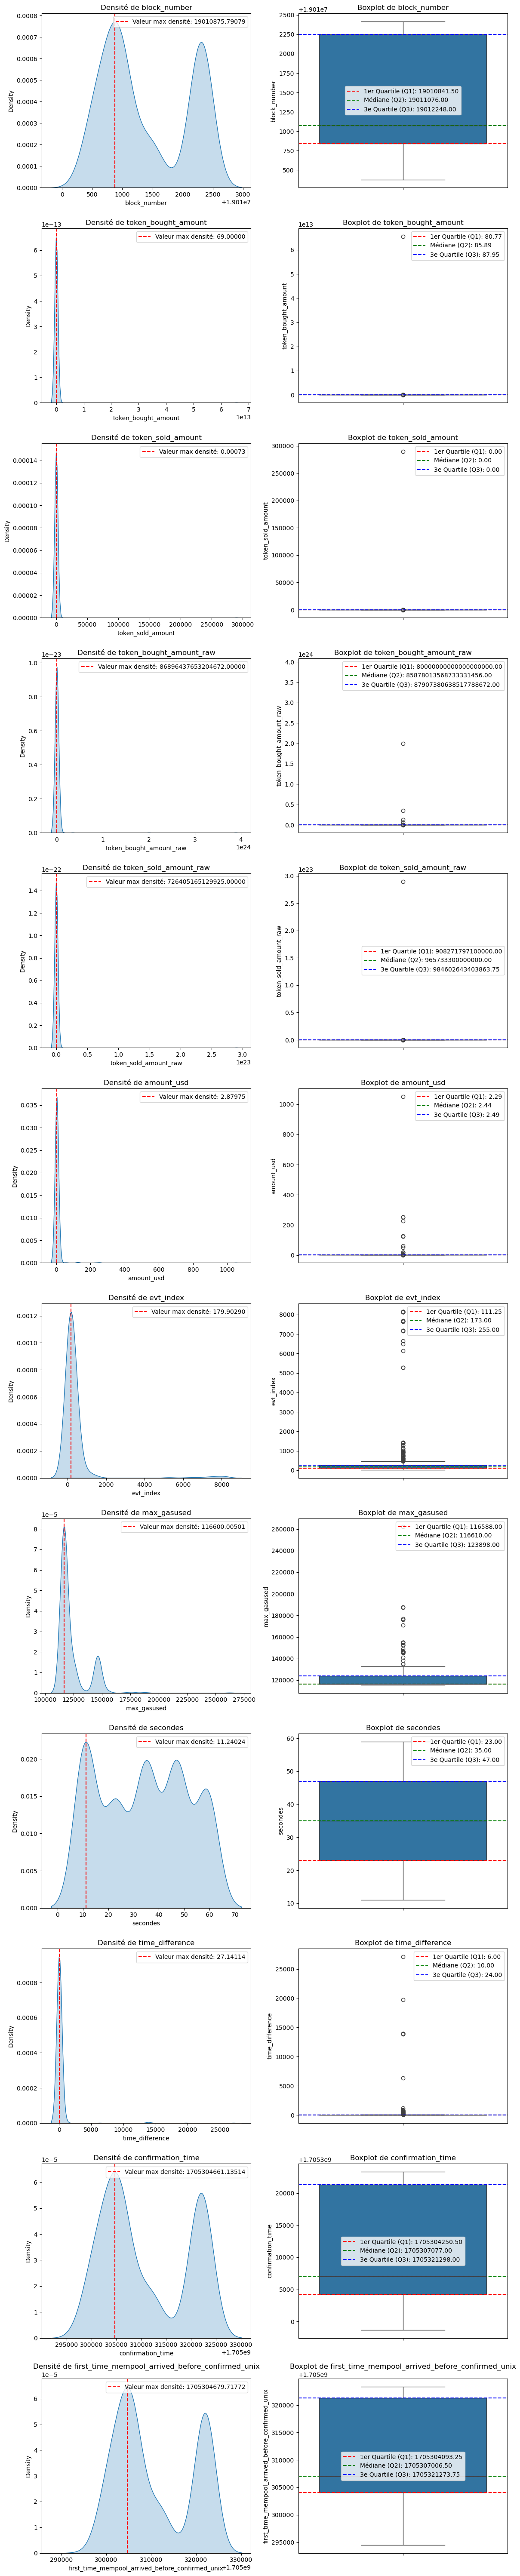

Variable: block_number - Valeur avec densité maximale: 19010875.79079, Densité maximale: 0.00077
Variable: token_bought_amount - Valeur avec densité maximale: 69.00000, Densité maximale: 0.00000
Variable: token_sold_amount - Valeur avec densité maximale: 0.00073, Densité maximale: 0.00015
Variable: token_bought_amount_raw - Valeur avec densité maximale: 86896437653204672.00000, Densité maximale: 0.00000
Variable: token_sold_amount_raw - Valeur avec densité maximale: 726405165129925.00000, Densité maximale: 0.00000
Variable: amount_usd - Valeur avec densité maximale: 2.87975, Densité maximale: 0.03697
Variable: evt_index - Valeur avec densité maximale: 179.90290, Densité maximale: 0.00123
Variable: max_gasused - Valeur avec densité maximale: 116600.00501, Densité maximale: 0.00008
Variable: secondes - Valeur avec densité maximale: 11.24024, Densité maximale: 0.02231
Variable: time_difference - Valeur avec densité maximale: 27.14114, Densité maximale: 0.00096
Variable: confirmation_time 

In [278]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import gaussian_kde

# Définir le nombre de sous-graphes nécessaires
num_vars = len(numerical_variables)
fig, axes = plt.subplots(num_vars, 2, figsize=(12, 5 * num_vars))

# Vérifier si axes est une seule ligne ou plusieurs lignes
if num_vars == 1:
    axes = np.array([axes])

# Dictionnaire pour stocker les valeurs avec densité maximale
max_density_values = {}

# Itérer sur chaque variable numérique et créer les graphiques
for i, col in enumerate(numerical_variables):
    # Vérifier si la colonne existe dans df_fr
    if col in df_fr.columns:
        # Tracer la courbe de densité
        data = df_fr[col].dropna()
        
        # Vérifier s'il y a suffisamment de données pour la densité
        if len(data) > 1 and np.var(data) > 1e-5:  # Vérifier la variance
            try:
                sns.kdeplot(data, ax=axes[i, 0], fill=True)  # Suppression des NaN pour la densité
                axes[i, 0].set_title(f'Densité de {col}')
                
                # Calculer la densité de probabilité avec gaussian_kde
                kde = gaussian_kde(data, bw_method='scott')  # Vous pouvez ajuster bw_method si nécessaire
                x = np.linspace(data.min(), data.max(), 1000)  # Générer une plage de valeurs
                kde_values = kde(x)

                # Trouver l'indice de la densité maximale
                max_density_idx = np.argmax(kde_values)

                # Trouver la valeur correspondante avec la densité maximale
                max_density_value = x[max_density_idx]
                max_density = kde_values[max_density_idx]

                # Ajouter les résultats au dictionnaire avec une précision de 10^-5
                max_density_values[col] = (round(max_density_value, 5), round(max_density, 5))

                # Ajouter une ligne verticale à la valeur avec densité maximale
                axes[i, 0].axvline(max_density_value, color='red', linestyle='--', label=f'Valeur max densité: {max_density_value:.5f}')
                axes[i, 0].legend()
            except Exception as e:
                print(f"Erreur lors du calcul de la densité pour {col}: {e}")
        else:
            axes[i, 0].text(0.5, 0.5, 'Données insuffisantes\nou variance trop faible', 
                             ha='center', va='center', fontsize=12, color='red')
            axes[i, 0].set_title(f'Densité de {col}')

        # Tracer le boxplot
        sns.boxplot(y=data, ax=axes[i, 1])  # Suppression des NaN pour le boxplot
        axes[i, 1].set_title(f'Boxplot de {col}')

        # Calculer les quartiles
        q1 = df_fr[col].quantile(0.25)
        q2 = df_fr[col].median()
        q3 = df_fr[col].quantile(0.75)

        # Ajouter les annotations pour les quartiles
        axes[i, 1].axhline(q1, color='r', linestyle='--', label=f'1er Quartile (Q1): {q1:.2f}')
        axes[i, 1].axhline(q2, color='g', linestyle='--', label=f'Médiane (Q2): {q2:.2f}')
        axes[i, 1].axhline(q3, color='b', linestyle='--', label=f'3e Quartile (Q3): {q3:.2f}')

        # Ajouter la légende au boxplot
        axes[i, 1].legend()
    else:
        print(f"La colonne {col} n'existe pas dans df_fr.")

# Ajustement de l'espacement entre les sous-graphes pour éviter le chevauchement
plt.tight_layout()
plt.show()

# Afficher les valeurs avec densité maximale
for col, (max_value, max_density) in max_density_values.items():
    print(f'Variable: {col} - Valeur avec densité maximale: {max_value:.5f}, Densité maximale: {max_density:.5f}')


Pour cette visualisation, qui présente à la fois une courbe de densité et un boxplot pour chaque variable, les courbes de densité permettent d'examiner la distribution continue des données et de visualiser la forme des distributions pour différentes catégories, tandis que les boxplots offrent un aperçu clair des résumés statistiques, tels que les médianes, les quartiles et les valeurs aberrantes, facilitant ainsi la comparaison des répartitions entre groupes et la détection des anomalies. Les points importants sont les suivants :
- Les variables `token_bought_amount`, `token_sold_amount`, `token_bought_amount_raw`, et `time_difference` montrent une faible variance, comme en témoigne l'étroitesse de leurs intervalles interquartiles, ce qui se traduit par des pics marqués dans leurs courbes de densité.
- Les variables `evt_index` et `max_gasused` présentent une variance plus élevée, mais celle-ci reste modérée.
- Les variables `first_time_mempool_arrived_before_confirmed_unix`, `secondes`, `confirmation_time`, et `block_number` affichent une grande variance par rapport aux autres variables, comme en témoigne l'écart interquartile plus large et des courbes de densité plus étendues.

# Visualisation 2

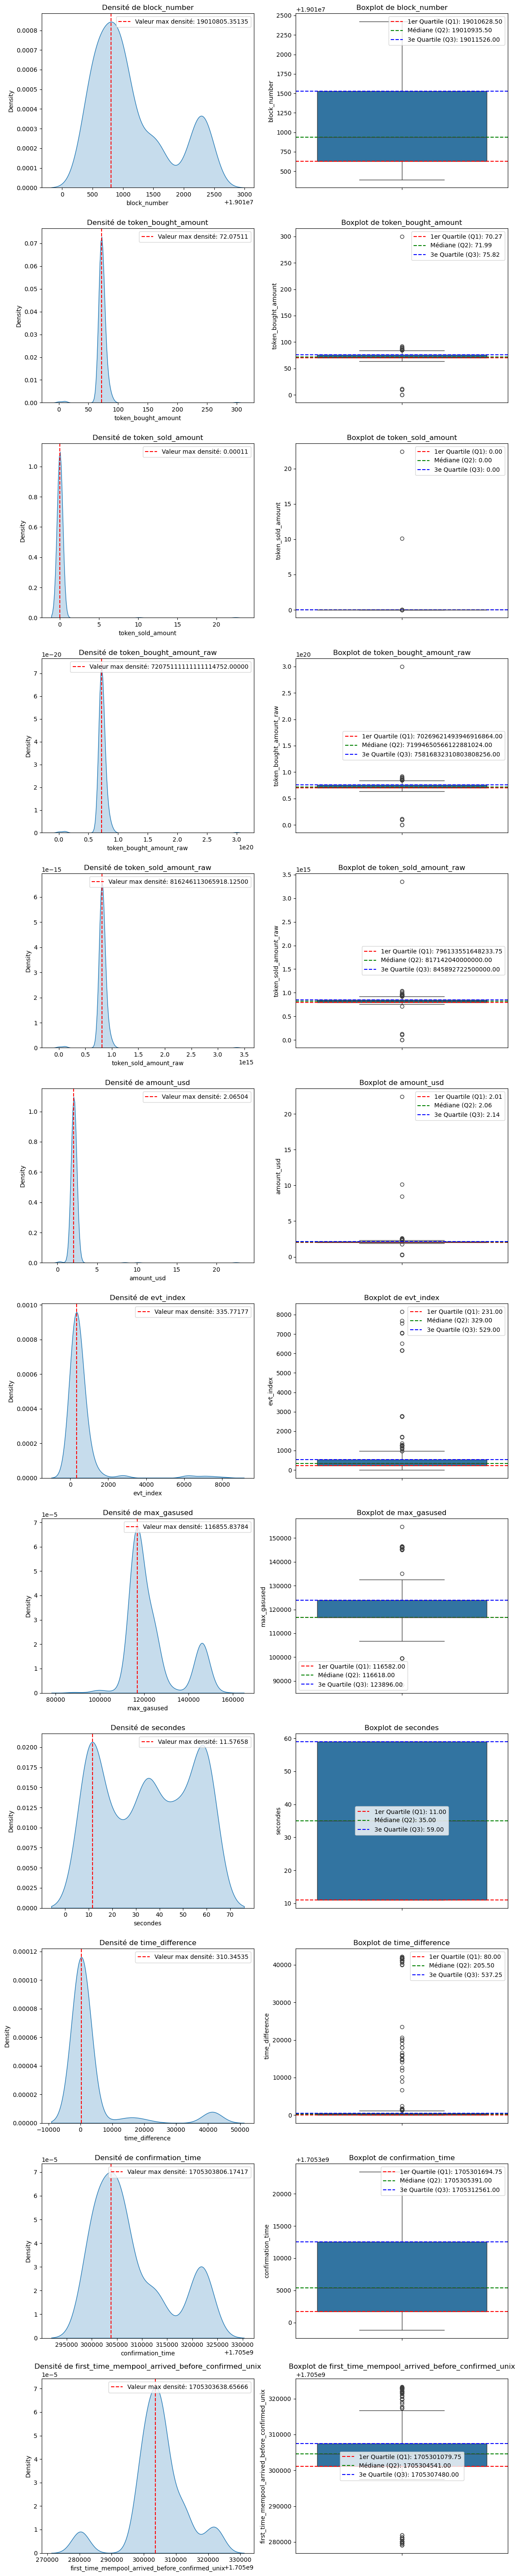

Variable: block_number - Valeur avec densité maximale: 19010805.35135, Densité maximale: 0.00084
Variable: token_bought_amount - Valeur avec densité maximale: 72.07511, Densité maximale: 0.07308
Variable: token_sold_amount - Valeur avec densité maximale: 0.00011, Densité maximale: 1.10032
Variable: token_bought_amount_raw - Valeur avec densité maximale: 72075111111111122944.00000, Densité maximale: 0.00000
Variable: token_sold_amount_raw - Valeur avec densité maximale: 816246113065918.12500, Densité maximale: 0.00000
Variable: amount_usd - Valeur avec densité maximale: 2.06504, Densité maximale: 1.09919
Variable: evt_index - Valeur avec densité maximale: 335.77177, Densité maximale: 0.00096
Variable: max_gasused - Valeur avec densité maximale: 116855.83784, Densité maximale: 0.00007
Variable: secondes - Valeur avec densité maximale: 11.57658, Densité maximale: 0.02066
Variable: time_difference - Valeur avec densité maximale: 310.34535, Densité maximale: 0.00012
Variable: confirmation_t

In [281]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import gaussian_kde

# Définir le nombre de sous-graphes nécessaires
num_vars = len(numerical_variables)
fig, axes = plt.subplots(num_vars, 2, figsize=(12, 5 * num_vars))

# Vérifier si axes est une seule ligne ou plusieurs lignes
if num_vars == 1:
    axes = np.array([axes])

# Dictionnaire pour stocker les valeurs avec densité maximale
max_density_values = {}

# Itérer sur chaque variable numérique et créer les graphiques
for i, col in enumerate(numerical_variables):
    # Vérifier si la colonne existe dans df_no_fr
    if col in df_no_fr.columns:
        # Tracer la courbe de densité
        data = df_no_fr[col].dropna()
        
        # Vérifier s'il y a suffisamment de données pour la densité
        if len(data) > 1 and np.var(data) > 1e-5:  # Vérifier la variance
            try:
                sns.kdeplot(data, ax=axes[i, 0], fill=True)  # Suppression des NaN pour la densité
                axes[i, 0].set_title(f'Densité de {col}')
                
                # Calculer la densité de probabilité avec gaussian_kde
                kde = gaussian_kde(data, bw_method='scott')  # Vous pouvez ajuster bw_method si nécessaire
                x = np.linspace(data.min(), data.max(), 1000)  # Générer une plage de valeurs
                kde_values = kde(x)

                # Trouver l'indice de la densité maximale
                max_density_idx = np.argmax(kde_values)

                # Trouver la valeur correspondante avec la densité maximale
                max_density_value = x[max_density_idx]
                max_density = kde_values[max_density_idx]

                # Ajouter les résultats au dictionnaire avec une précision de 10^-5
                max_density_values[col] = (round(max_density_value, 5), round(max_density, 5))

                # Ajouter une ligne verticale à la valeur avec densité maximale
                axes[i, 0].axvline(max_density_value, color='red', linestyle='--', label=f'Valeur max densité: {max_density_value:.5f}')
                axes[i, 0].legend()
            except Exception as e:
                print(f"Erreur lors du calcul de la densité pour {col}: {e}")
        else:
            axes[i, 0].text(0.5, 0.5, 'Données insuffisantes\nou variance trop faible', 
                             ha='center', va='center', fontsize=12, color='red')
            axes[i, 0].set_title(f'Densité de {col}')

        # Tracer le boxplot
        sns.boxplot(y=data, ax=axes[i, 1])  # Suppression des NaN pour le boxplot
        axes[i, 1].set_title(f'Boxplot de {col}')

        # Calculer les quartiles
        q1 = df_no_fr[col].quantile(0.25)
        q2 = df_no_fr[col].median()
        q3 = df_no_fr[col].quantile(0.75)

        # Ajouter les annotations pour les quartiles
        axes[i, 1].axhline(q1, color='r', linestyle='--', label=f'1er Quartile (Q1): {q1:.2f}')
        axes[i, 1].axhline(q2, color='g', linestyle='--', label=f'Médiane (Q2): {q2:.2f}')
        axes[i, 1].axhline(q3, color='b', linestyle='--', label=f'3e Quartile (Q3): {q3:.2f}')

        # Ajouter la légende au boxplot
        axes[i, 1].legend()
    else:
        print(f"La colonne {col} n'existe pas dans df_no_fr.")

# Ajustement de l'espacement entre les sous-graphes pour éviter le chevauchement
plt.tight_layout()
plt.show()

# Afficher les valeurs avec densité maximale
for col, (max_value, max_density) in max_density_values.items():
    print(f'Variable: {col} - Valeur avec densité maximale: {max_value:.5f}, Densité maximale: {max_density:.5f}')


- Les variables `token_bought_amount`, `token_sold_amount`, `token_bought_amount_raw` et `time_difference` présentent une faible variabilité, comme le montre la concentration de leurs valeurs autour de grands pics dans les courbes de densité et des intervalles interquartiles étroits.
- Les variables `evt_index`, `first_time_mempool_arrived_before_confirmed_unix`, `block_number`, `confirmation_time` et `max_gasused` montrent une variance modérée, plus élevée que celle des variables mentionnées précédemment mais pas excessive.
- La variable `secondes` exhibe une grande variance, comme l'indiquent son large intervalle interquartile et ses courbes de densité plus étendues.

# Visualisation 3

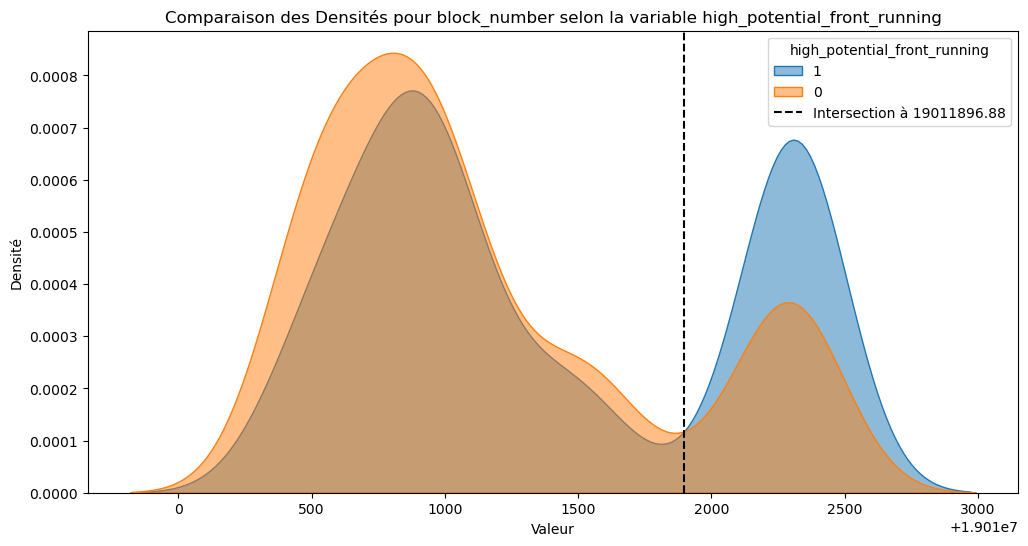

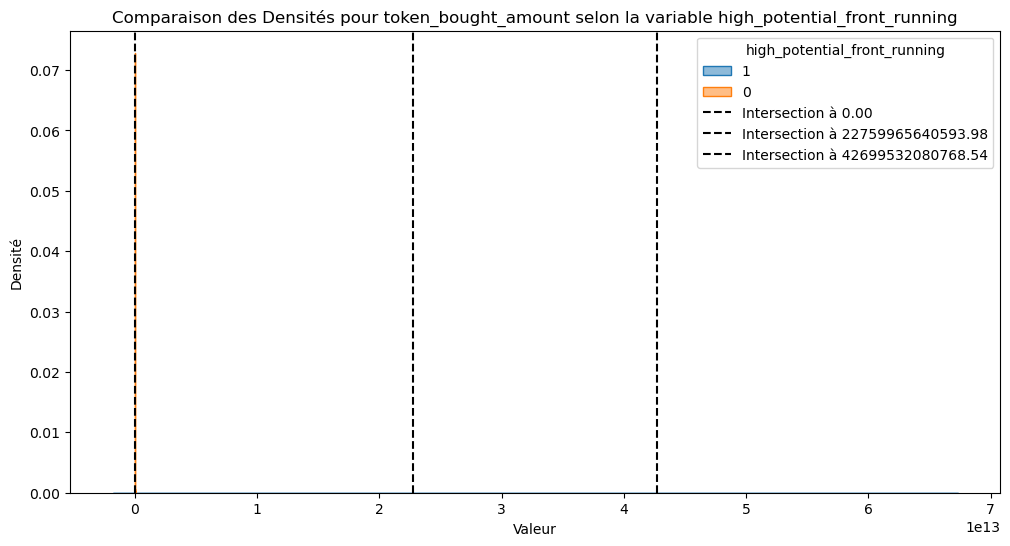

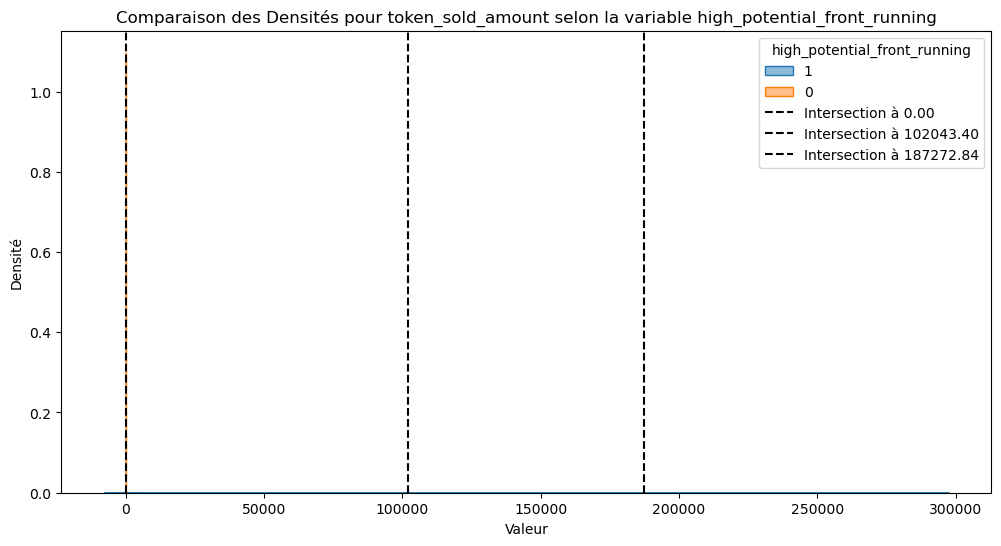

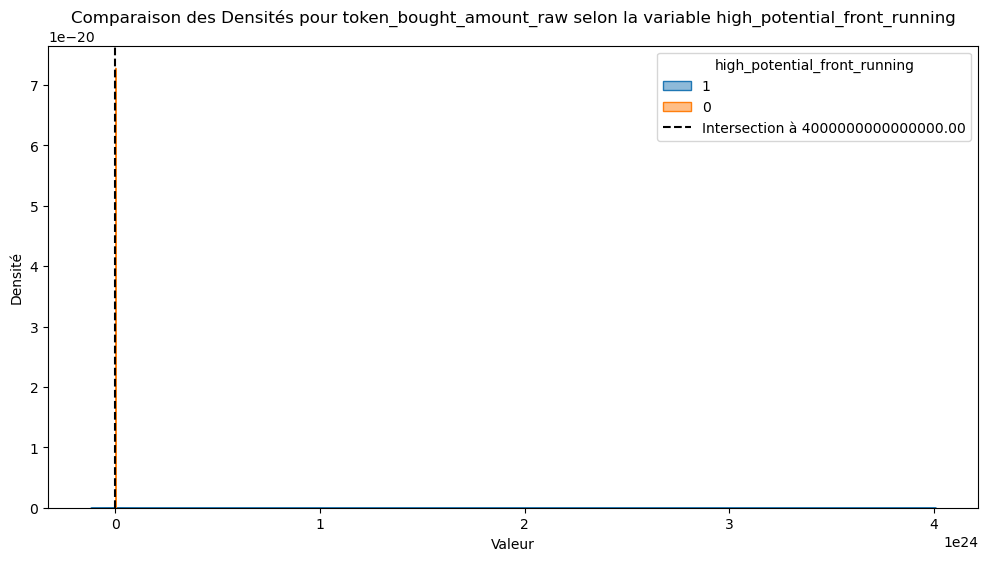

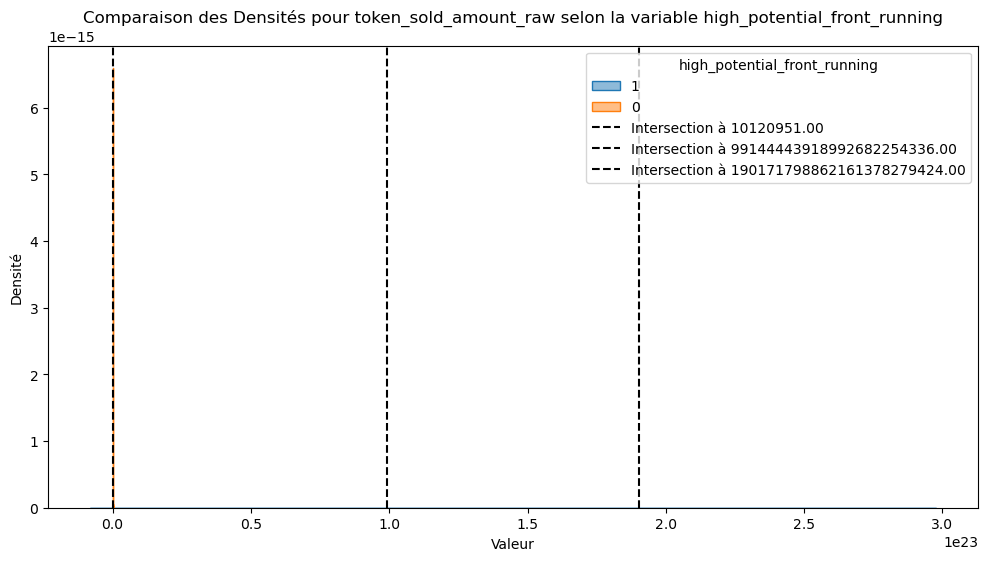

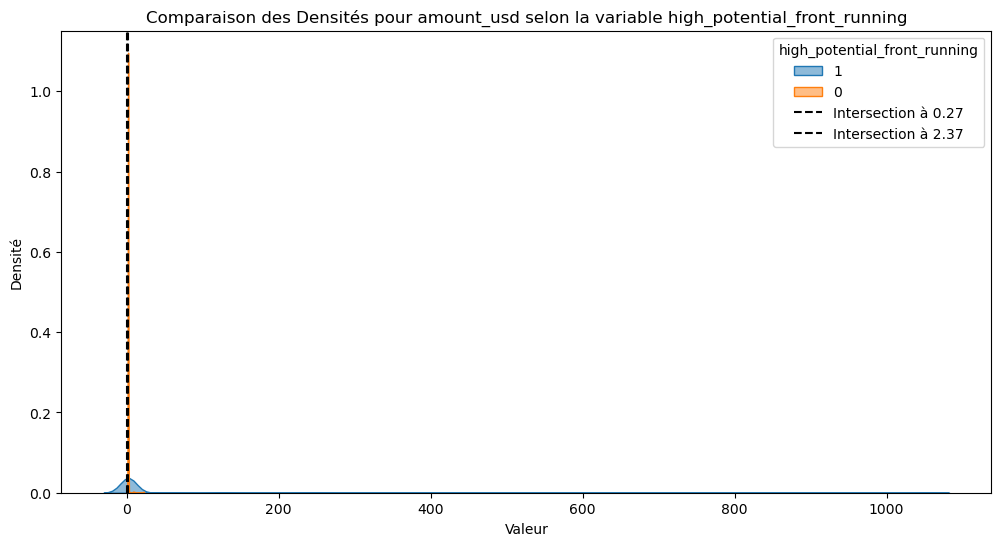

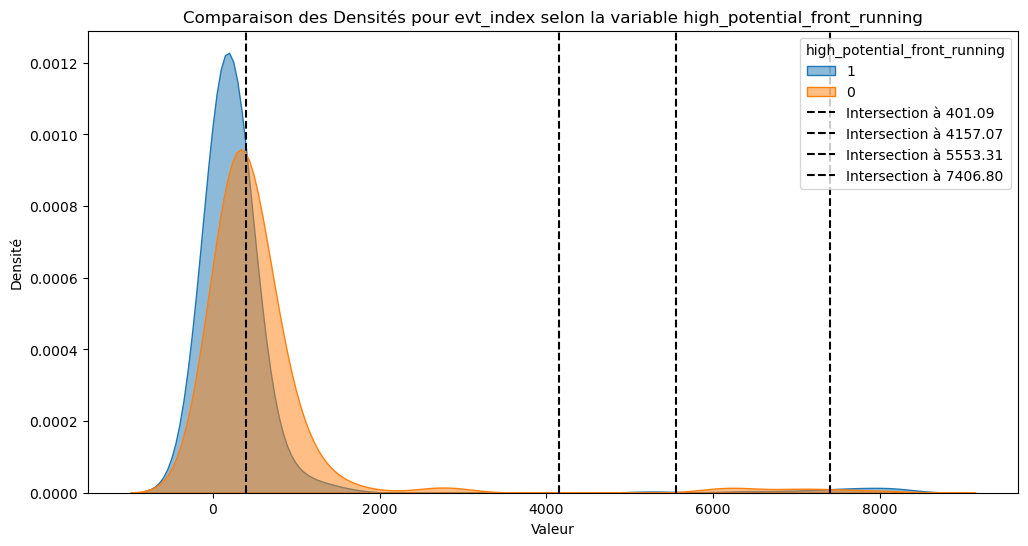

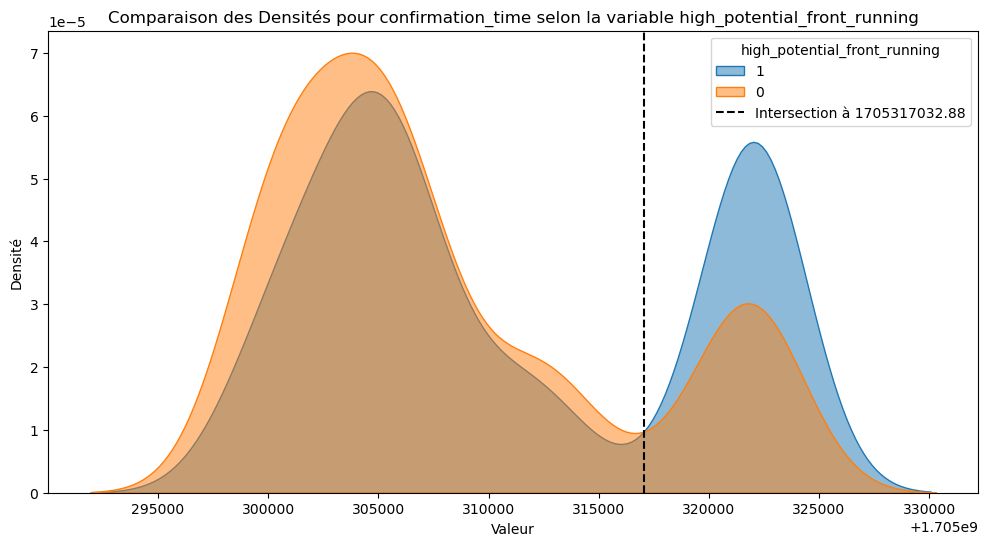

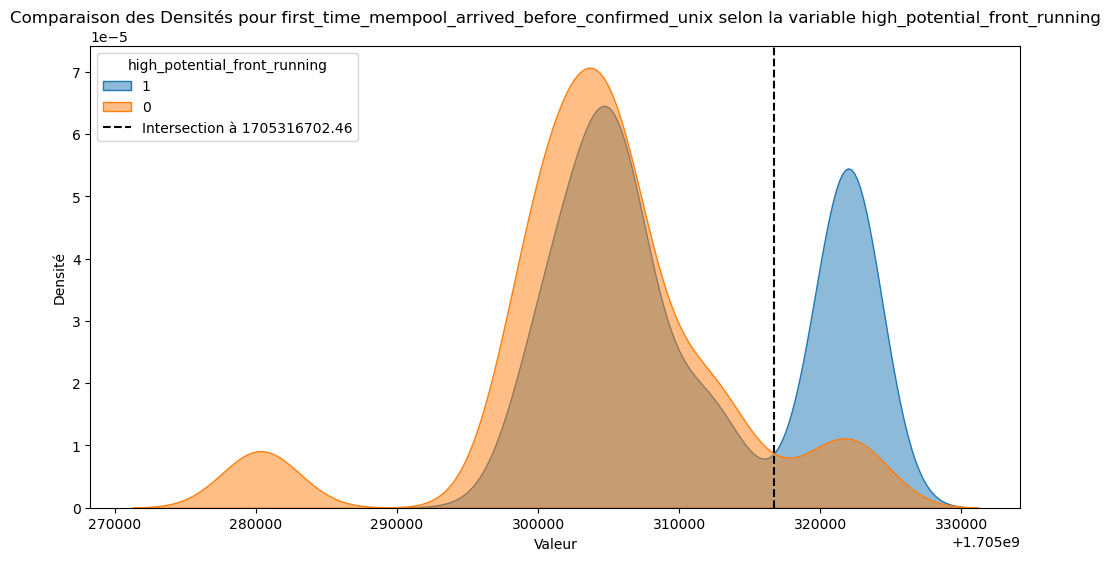

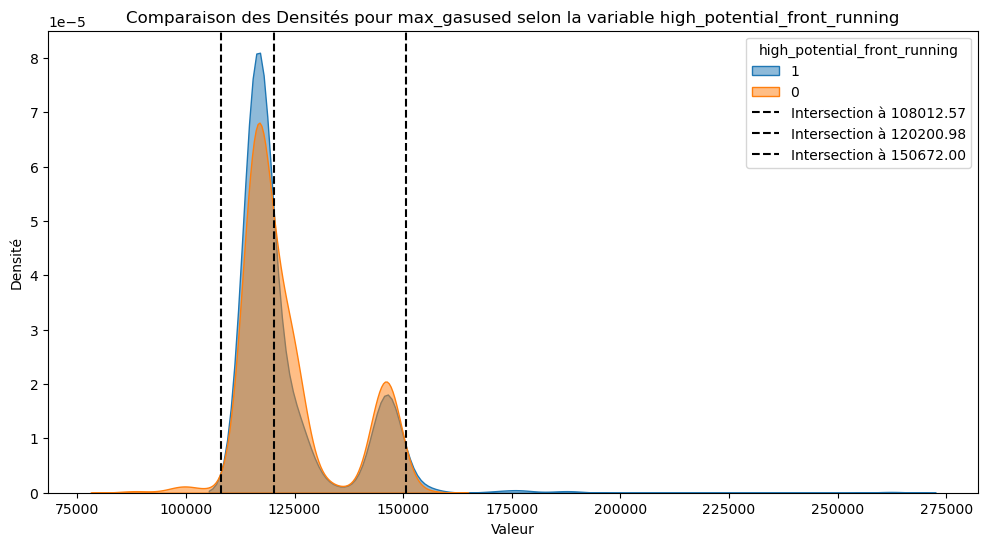

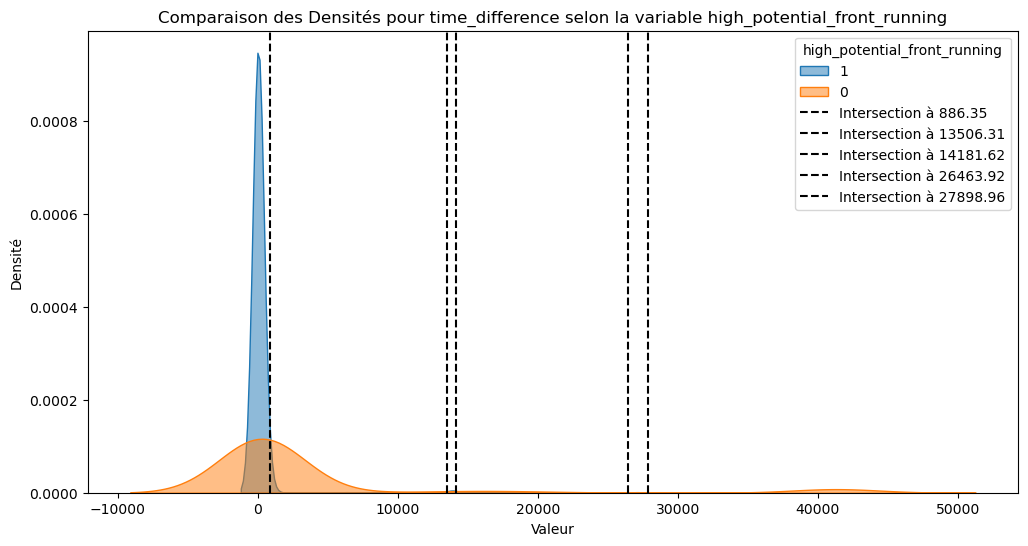

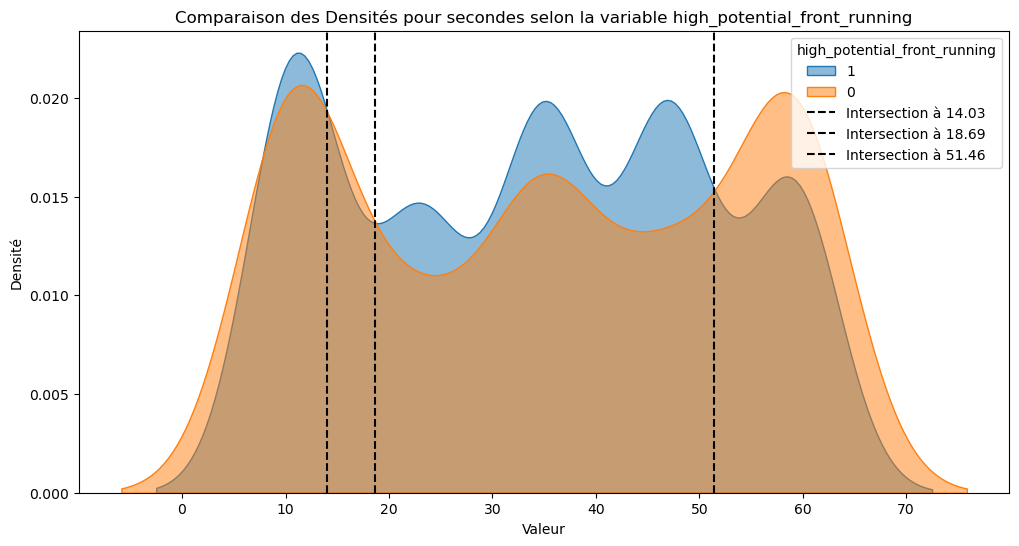

In [284]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Variables quantitatives à comparer
# Variables quantitatives à comparer, excluant 'high_potential_front_running'
Features = df_analyse.select_dtypes(include=['number']).drop(columns=['high_potential_front_running'], errors='ignore')


# Tracer les courbes de densité et trouver les intersections
for var in Features:
    plt.figure(figsize=(12, 6))
    
    # Tracer les courbes de densité pour chaque catégorie de 'high_potential_front_running'
    for label in df_analyse['high_potential_front_running'].unique():
        subset = df_analyse[df_analyse['high_potential_front_running'] == label]
        sns.kdeplot(subset[var], label=f'{label}', fill=True, alpha=0.5)
    
    # Estimer les densités
    densities = {}
    x = np.linspace(df_analyse[var].min(), df_analyse[var].max(), 1000)
    
    # Calculer les densités pour chaque catégorie
    for label in df_analyse['high_potential_front_running'].unique():
        subset = df_analyse[df_analyse['high_potential_front_running'] == label]
        density = stats.gaussian_kde(subset[var].dropna())
        densities[label] = density
    
    # Trouver les points d'intersection
    if len(densities) == 2:  # Assurer qu'il y a exactement 2 catégories pour comparer
        diff = densities[list(densities.keys())[0]](x) - densities[list(densities.keys())[1]](x)
        intersection_indices = np.where(np.diff(np.sign(diff)))[0]
        
        # Tracer les lignes verticales pour chaque point d'intersection
        for idx in intersection_indices:
            separation_value = x[idx]
            plt.axvline(x=separation_value, color='black', linestyle='--', label=f'Intersection à {separation_value:.2f}')
    
    plt.title(f'Comparaison des Densités pour {var} selon la variable high_potential_front_running')
    plt.xlabel('Valeur')
    plt.ylabel('Densité')
    plt.legend(title='high_potential_front_running')
    plt.show()


Si une constatation devait être faite, elle serait la suivante : les courbes de densité en orange et en bleu semblent se confondre tellement elles se ressemblent. Seule la variable `secondes` présente une distinction notable : les densités ne se superposent pas. Cela indique que les valeurs pour les transactions considérées comme des `high_potential_front_running` sont concentrées autour de 20 secondes, tandis que pour celles qui ne le sont pas, les valeurs sont plutôt autour de 60 secondes. En ce qui concerne la variable `max_gasused`, on peut observer une séparation à la première intersection, indiquant que les transactions à fort potentiel de front running semblent utiliser un peu plus de gaz.

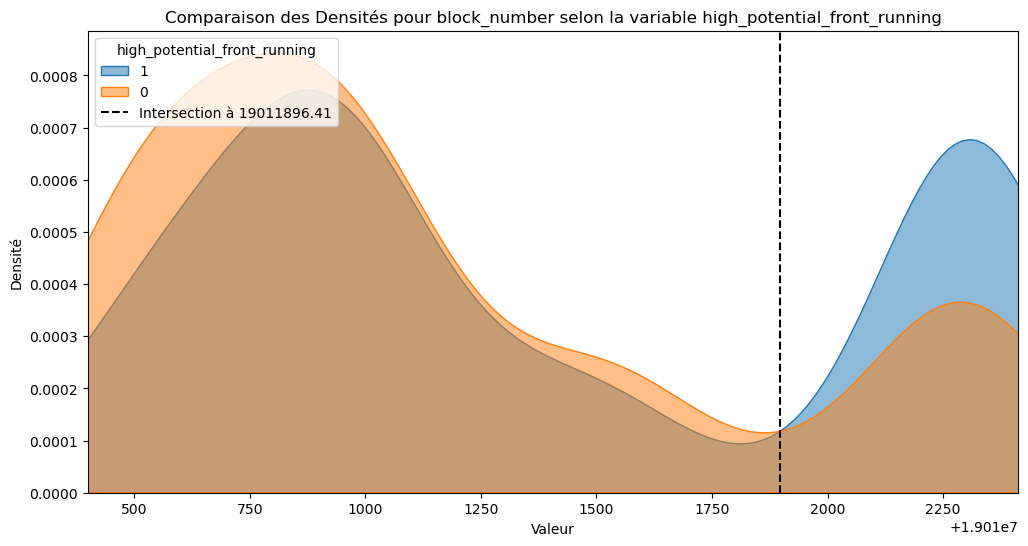

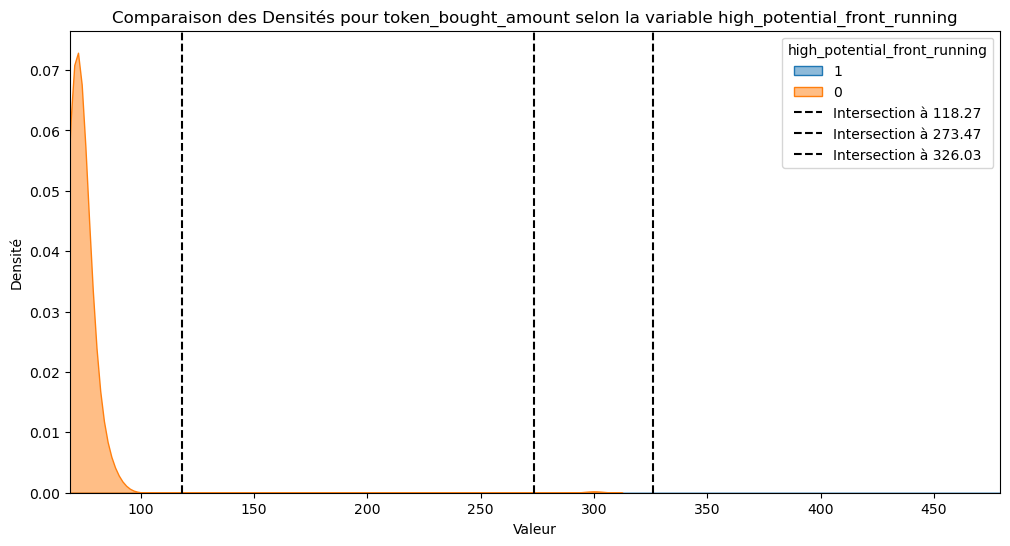

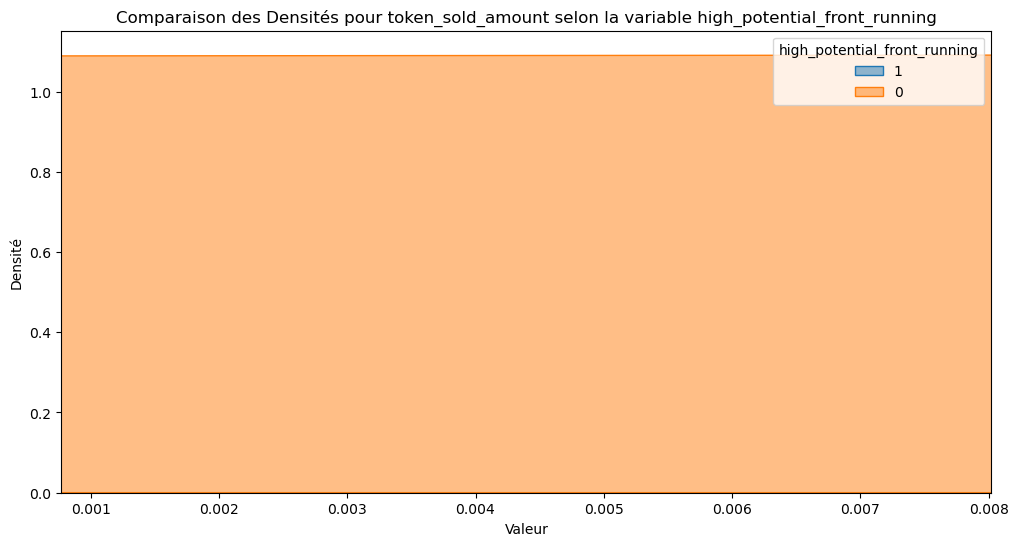

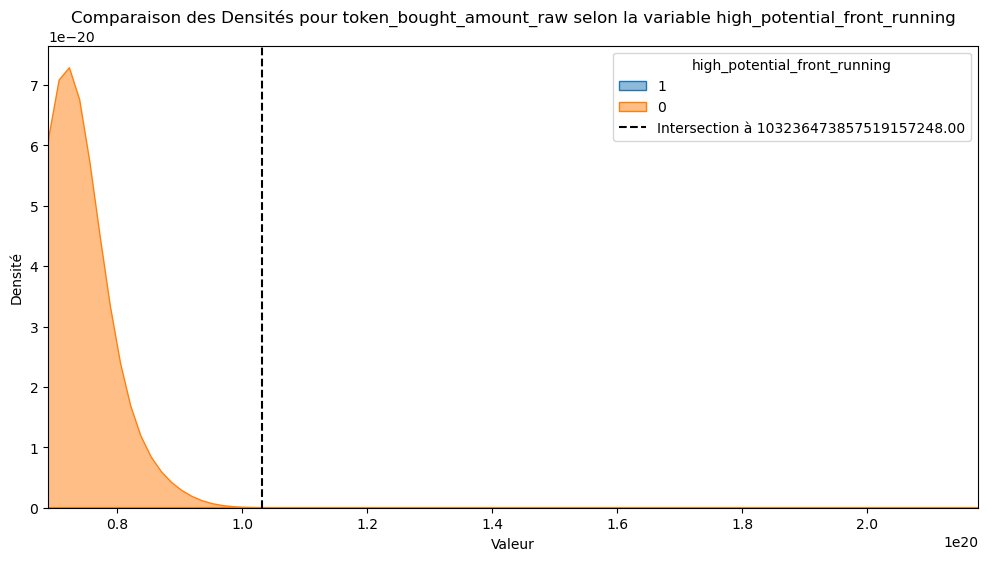

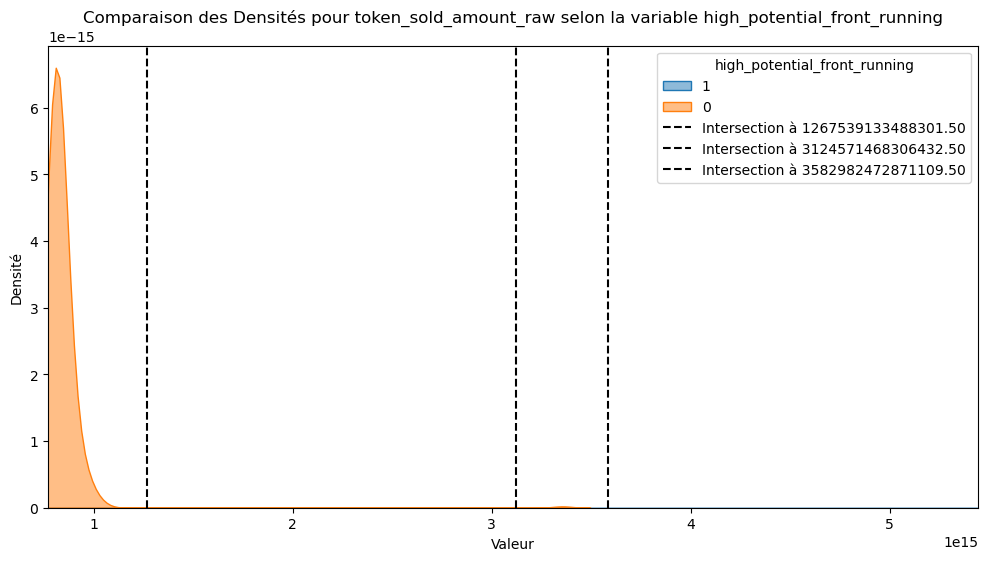

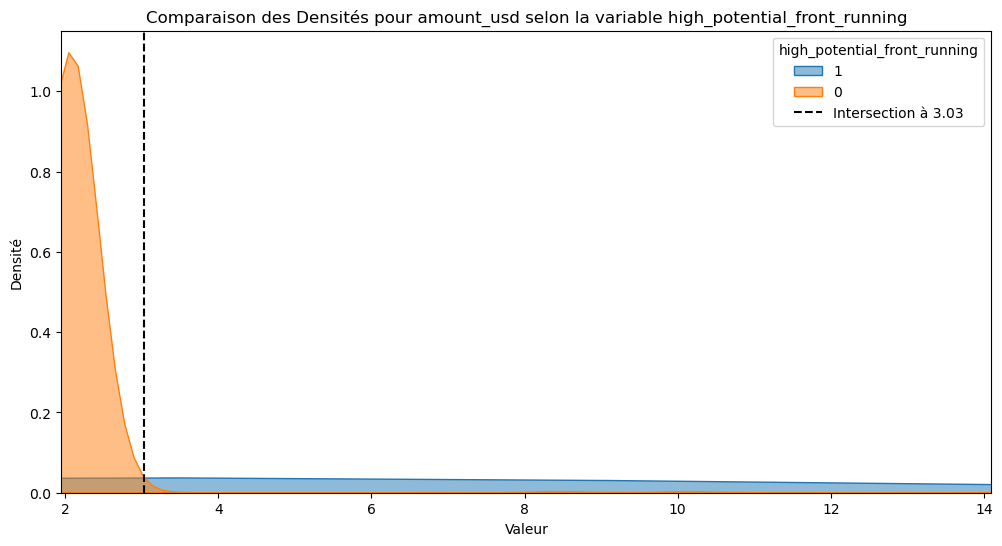

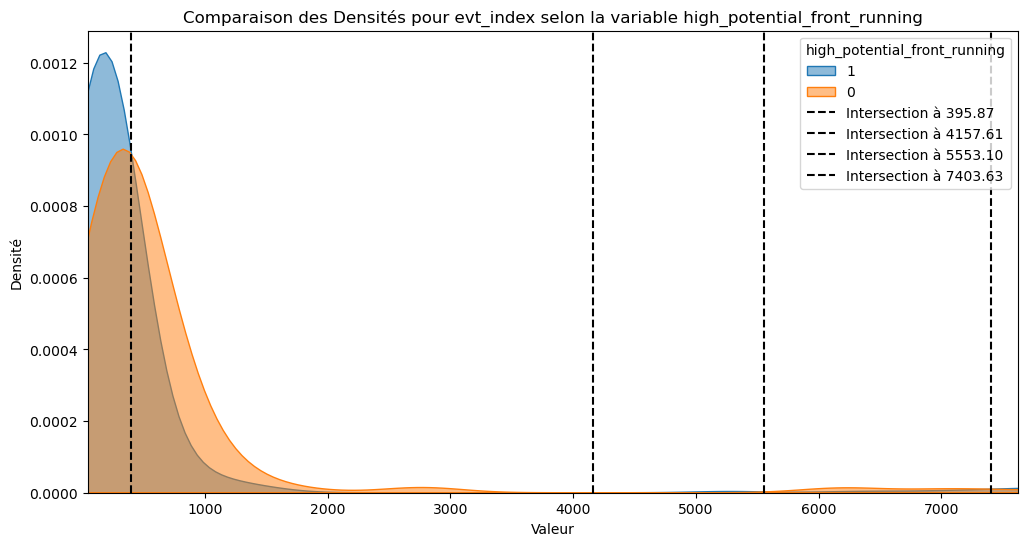

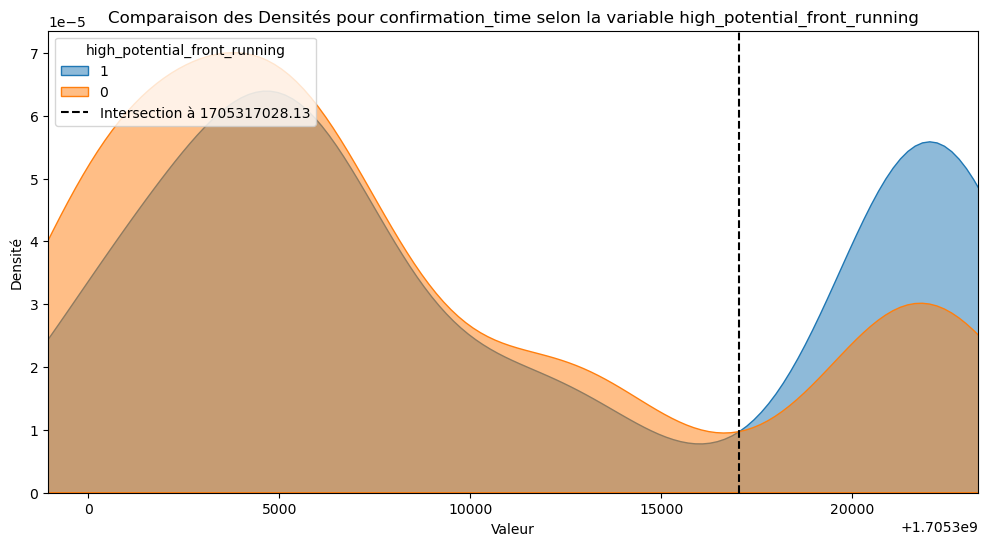

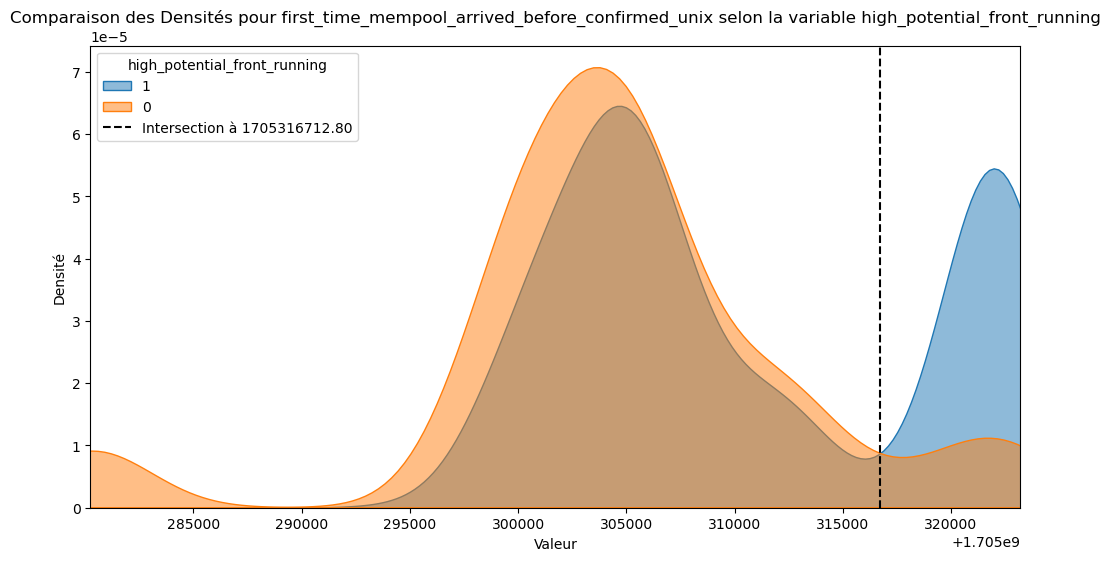

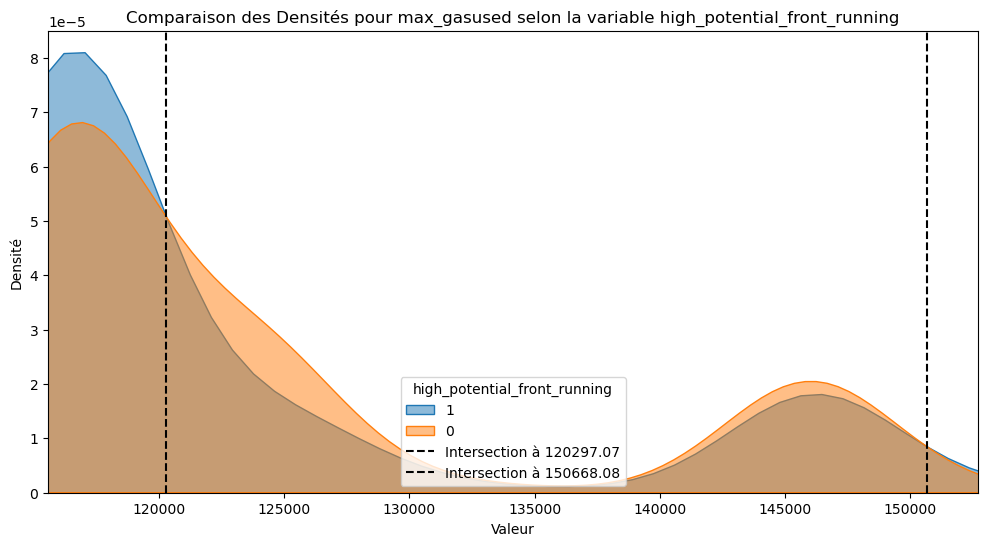

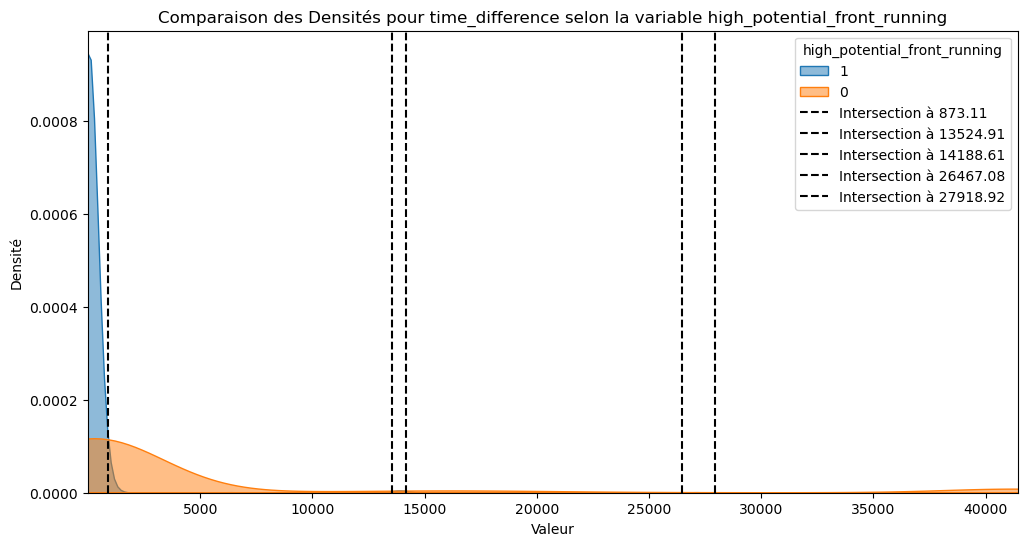

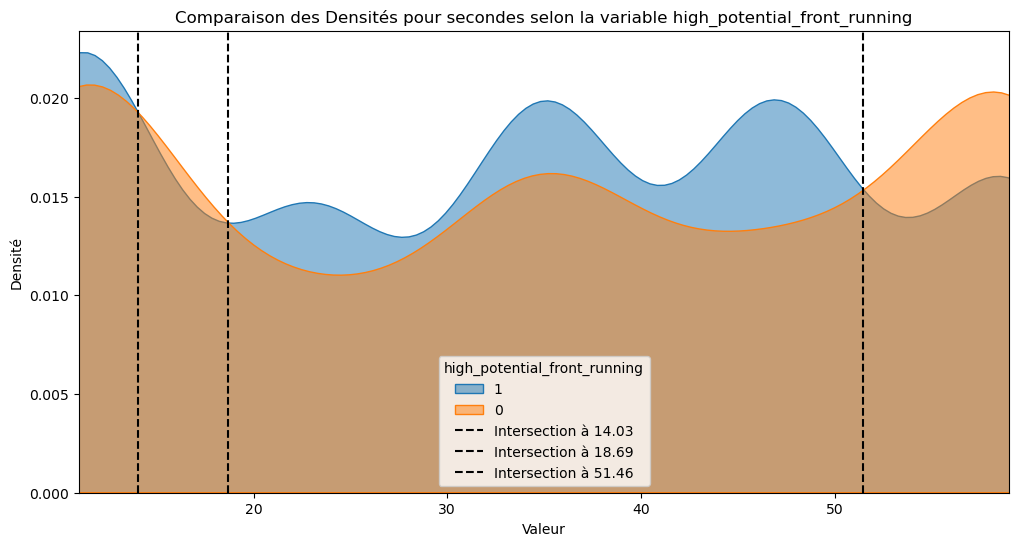

In [518]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

# Fonction pour ajuster les limites de l'axe x (en excluant éventuellement les valeurs aberrantes)
def adjust_x_limits(variable):
    q1 = variable.quantile(0.01)  # Quantile 1% pour ignorer les valeurs aberrantes
    q99 = variable.quantile(0.99)  # Quantile 99%
    return q1, q99

# Variables quantitatives à comparer, excluant 'high_potential_front_running'
Features = df_analyse.select_dtypes(include=['number']).drop(columns=['high_potential_front_running'], errors='ignore')

# Tracer les courbes de densité et ajuster les axes des abscisses
for var in Features:
    plt.figure(figsize=(12, 6))
    
    # Déterminer les limites des axes x en fonction des données
    min_x, max_x = adjust_x_limits(df_analyse[var].dropna())
    
    # Tracer les courbes de densité pour chaque catégorie de 'high_potential_front_running'
    for label in df_analyse['high_potential_front_running'].unique():
        subset = df_analyse[df_analyse['high_potential_front_running'] == label]
        sns.kdeplot(subset[var], label=f'{label}', fill=True, alpha=0.5)
    
    # Estimer les densités
    densities = {}
    x = np.linspace(min_x, max_x, 1000)  # Utiliser l'intervalle ajusté pour les courbes de densité
    
    # Calculer les densités pour chaque catégorie
    for label in df_analyse['high_potential_front_running'].unique():
        subset = df_analyse[df_analyse['high_potential_front_running'] == label]
        density = stats.gaussian_kde(subset[var].dropna())
        densities[label] = density
    
    # Trouver les points d'intersection
    if len(densities) == 2:  # Assurer qu'il y a exactement 2 catégories pour comparer
        diff = densities[list(densities.keys())[0]](x) - densities[list(densities.keys())[1]](x)
        intersection_indices = np.where(np.diff(np.sign(diff)))[0]
        
        # Tracer les lignes verticales pour chaque point d'intersection
        for idx in intersection_indices:
            separation_value = x[idx]
            plt.axvline(x=separation_value, color='black', linestyle='--', label=f'Intersection à {separation_value:.2f}')
    
    plt.xlim(min_x, max_x)  # Appliquer les limites ajustées des abscisses
    plt.title(f'Comparaison des Densités pour {var} selon la variable high_potential_front_running')
    plt.xlabel('Valeur')
    plt.ylabel('Densité')
    plt.legend(title='high_potential_front_running')
    plt.show()


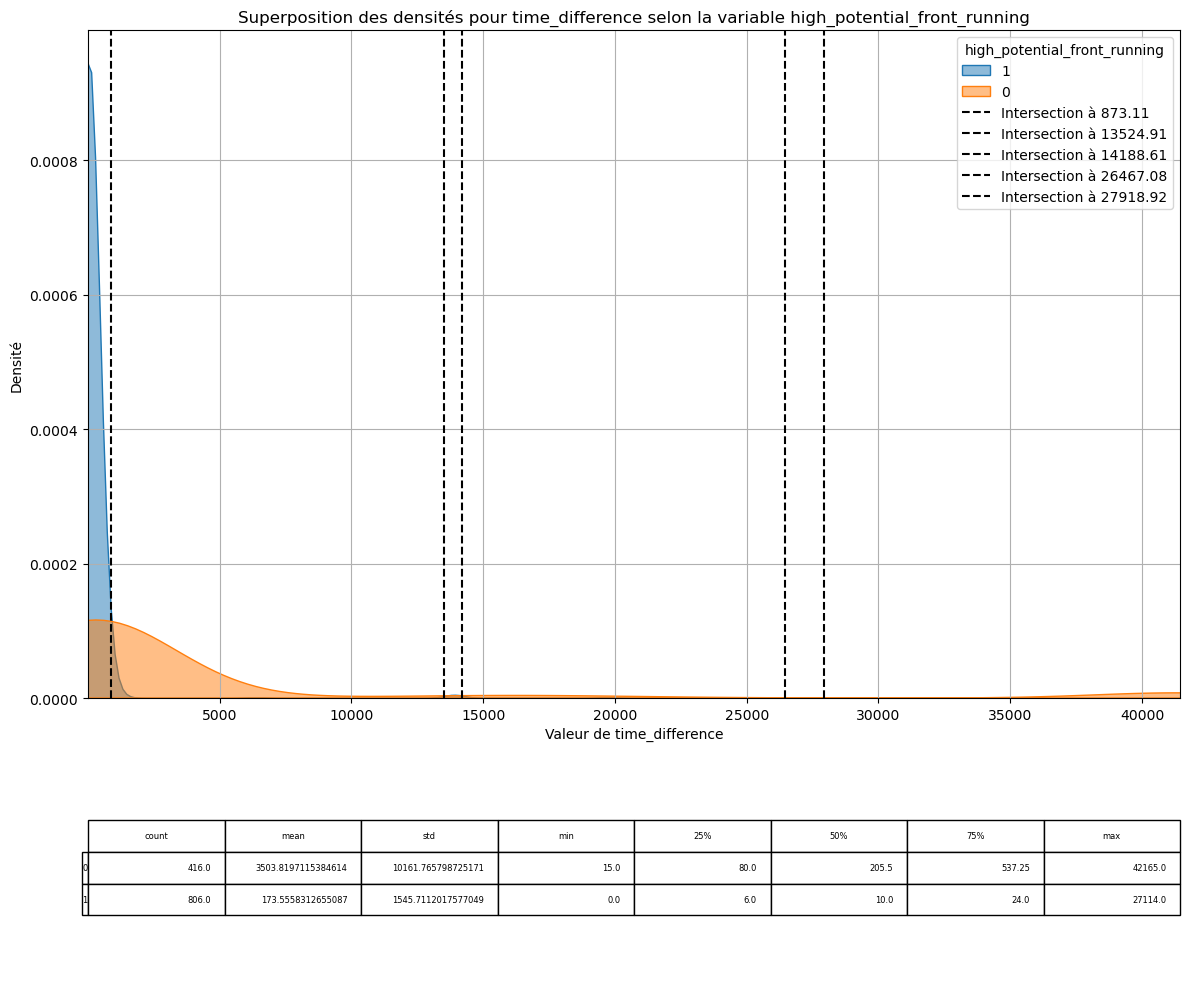

In [540]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
import pandas as pd

# Assurez-vous que df_analyse est déjà défini et contient les données appropriées.

# Fonction pour ajuster les limites de l'axe x (en excluant éventuellement les valeurs aberrantes)
def adjust_x_limits(variable):
    q1 = variable.quantile(0.01)  # Quantile 1% pour ignorer les valeurs aberrantes
    q99 = variable.quantile(0.99)  # Quantile 99%
    return q1, q99

# Variable d'intérêt
variable_of_interest = 'time_difference'

# Calculer les statistiques descriptives pour chaque catégorie de 'high_potential_front_running'
stats_desc = df_analyse.groupby('high_potential_front_running')[variable_of_interest].describe()

# Enregistrer les statistiques descriptives dans un fichier CSV
stats_desc.to_csv('statistiques_descriptives.csv', index=True)

# Ajuster les limites des axes x en fonction des données
min_x, max_x = adjust_x_limits(df_analyse[variable_of_interest].dropna())

# Créer la figure avec 2 sous-graphiques : un pour le KDE plot et un pour les statistiques descriptives
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 10), gridspec_kw={'height_ratios': [3, 1]})

# Tracer les courbes de densité pour chaque catégorie de 'high_potential_front_running' dans ax1
for label in df_analyse['high_potential_front_running'].unique():
    subset = df_analyse[df_analyse['high_potential_front_running'] == label]
    sns.kdeplot(subset[variable_of_interest], ax=ax1, label=f'{label}', fill=True, alpha=0.5)

# Estimer les densités
densities = {}
x = np.linspace(min_x, max_x, 1000)  # Utiliser l'intervalle ajusté pour les courbes de densité

# Calculer les densités pour chaque catégorie
for label in df_analyse['high_potential_front_running'].unique():
    subset = df_analyse[df_analyse['high_potential_front_running'] == label]
    density = stats.gaussian_kde(subset[variable_of_interest].dropna())
    densities[label] = density

# Trouver les points d'intersection
if len(densities) == 2:  # Assurer qu'il y a exactement 2 catégories pour comparer
    diff = densities[list(densities.keys())[0]](x) - densities[list(densities.keys())[1]](x)
    intersection_indices = np.where(np.diff(np.sign(diff)))[0]
    
    # Tracer les lignes verticales pour chaque point d'intersection
    for idx in intersection_indices:
        separation_value = x[idx]
        ax1.axvline(x=separation_value, color='black', linestyle='--', label=f'Intersection à {separation_value:.2f}')

ax1.set_xlim(min_x, max_x)  # Appliquer les limites ajustées des abscisses
ax1.set_title(f'Superposition des densités pour {variable_of_interest} selon la variable high_potential_front_running')
ax1.set_xlabel('Valeur de time_difference')
ax1.set_ylabel('Densité')
ax1.legend(title='high_potential_front_running')
ax1.grid()

# Afficher les statistiques descriptives dans ax2
ax2.axis('off')  # Désactiver les axes pour le tableau
table = ax2.table(cellText=stats_desc.values, colLabels=stats_desc.columns, rowLabels=stats_desc.index, loc='center')
table.scale(1, 1.5)  # Ajuster l'échelle du tableau pour une meilleure lisibilité

# Enregistrer la visualisation complète en tant que fichier PNG
plt.tight_layout()
plt.savefig('visualisation_time_difference_et_statistiques.png', dpi=300, bbox_inches='tight')

plt.show()

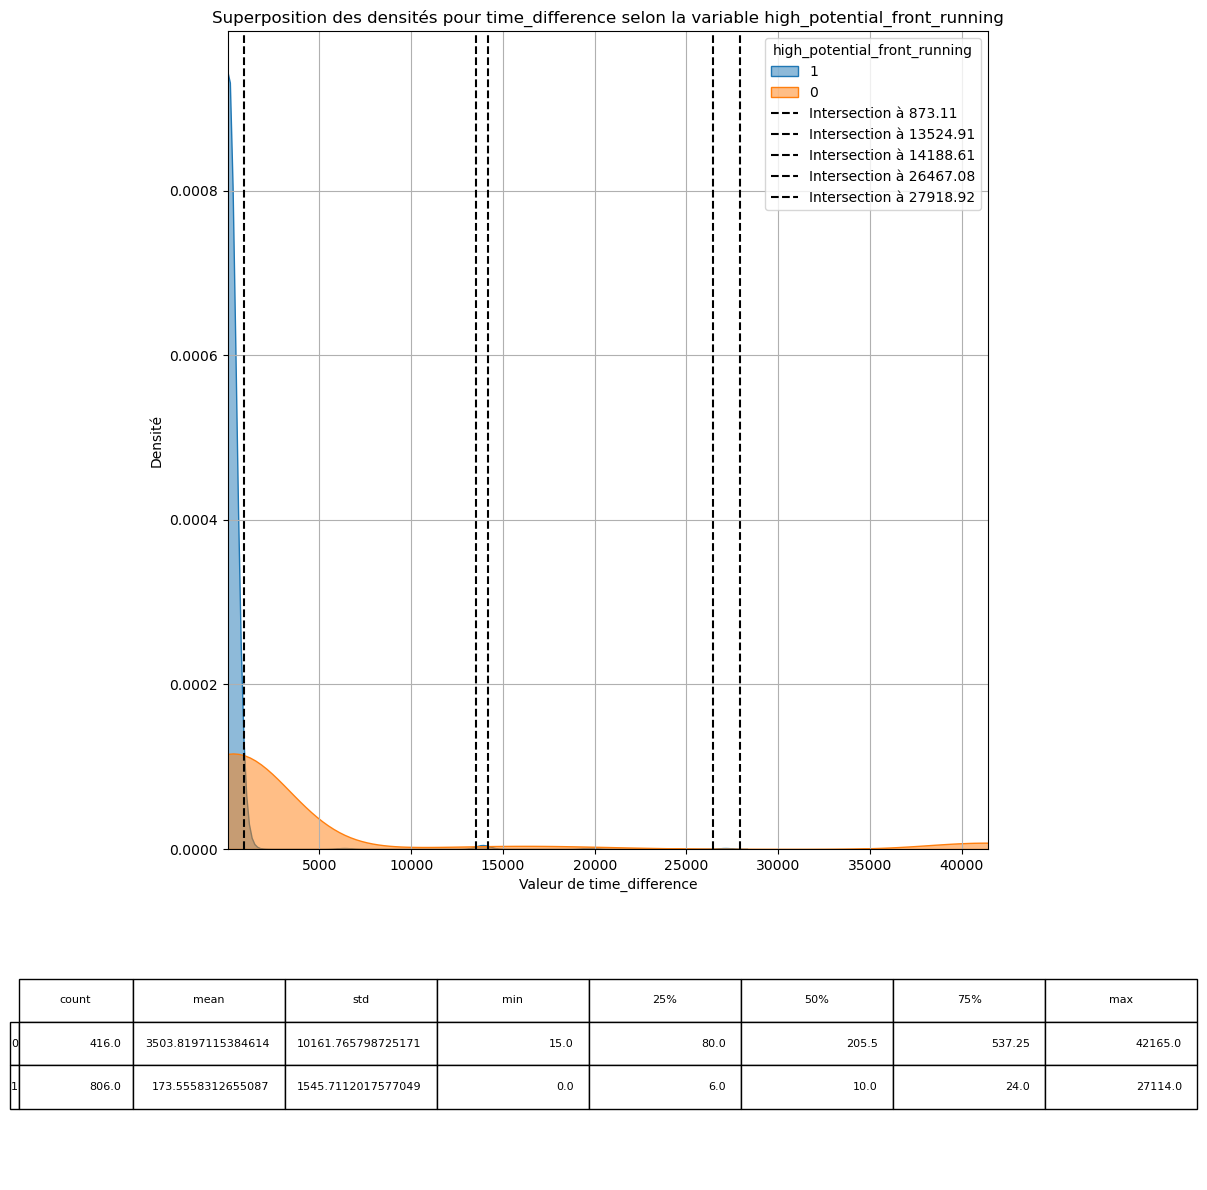

In [546]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
import pandas as pd

# Assurez-vous que df_analyse est déjà défini et contient les données appropriées.

# Fonction pour ajuster les limites de l'axe x (en excluant éventuellement les valeurs aberrantes)
def adjust_x_limits(variable):
    q1 = variable.quantile(0.01)  # Quantile 1% pour ignorer les valeurs aberrantes
    q99 = variable.quantile(0.99)  # Quantile 99%
    return q1, q99

# Variable d'intérêt
variable_of_interest = 'time_difference'

# Calculer les statistiques descriptives pour chaque catégorie de 'high_potential_front_running'
stats_desc = df_analyse.groupby('high_potential_front_running')[variable_of_interest].describe()

# Enregistrer les statistiques descriptives dans un fichier CSV
stats_desc.to_csv('statistiques_descriptives.csv', index=True)

# Ajuster les limites des axes x en fonction des données
min_x, max_x = adjust_x_limits(df_analyse[variable_of_interest].dropna())

# Créer la figure avec 2 sous-graphiques : un pour le KDE plot et un pour les statistiques descriptives
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(14, 12), gridspec_kw={'height_ratios': [3, 1]})  # Augmenter la taille générale

# Tracer les courbes de densité pour chaque catégorie de 'high_potential_front_running' dans ax1
for label in df_analyse['high_potential_front_running'].unique():
    subset = df_analyse[df_analyse['high_potential_front_running'] == label]
    sns.kdeplot(subset[variable_of_interest], ax=ax1, label=f'{label}', fill=True, alpha=0.5)

# Estimer les densités
densities = {}
x = np.linspace(min_x, max_x, 1000)  # Utiliser l'intervalle ajusté pour les courbes de densité

# Calculer les densités pour chaque catégorie
for label in df_analyse['high_potential_front_running'].unique():
    subset = df_analyse[df_analyse['high_potential_front_running'] == label]
    density = stats.gaussian_kde(subset[variable_of_interest].dropna())
    densities[label] = density

# Trouver les points d'intersection
if len(densities) == 2:  # Assurer qu'il y a exactement 2 catégories pour comparer
    diff = densities[list(densities.keys())[0]](x) - densities[list(densities.keys())[1]](x)
    intersection_indices = np.where(np.diff(np.sign(diff)))[0]
    
    # Tracer les lignes verticales pour chaque point d'intersection
    for idx in intersection_indices:
        separation_value = x[idx]
        ax1.axvline(x=separation_value, color='black', linestyle='--', label=f'Intersection à {separation_value:.2f}')

ax1.set_xlim(min_x, max_x)  # Appliquer les limites ajustées des abscisses
ax1.set_title(f'Superposition des densités pour {variable_of_interest} selon la variable high_potential_front_running')
ax1.set_xlabel('Valeur de time_difference')
ax1.set_ylabel('Densité')
ax1.legend(title='high_potential_front_running')
ax1.grid()

# Afficher les statistiques descriptives dans ax2
ax2.axis('off')  # Désactiver les axes pour le tableau
table = ax2.table(cellText=stats_desc.values, colLabels=stats_desc.columns, rowLabels=stats_desc.index, loc='center')

# Ajuster l'échelle du tableau pour agrandir et éviter les chevauchements
table.scale(1.5, 2)  # Échelle augmentée pour éviter le chevauchement des valeurs

# Ajuster la largeur des colonnes manuellement pour éviter le chevauchement des chiffres dans certaines colonnes
for (i, j), cell in table.get_celld().items():
    cell.set_fontsize(12)  # Ajuster la taille de la police pour qu'elle soit plus lisible
    if j == 0:  # Colonne des étiquettes de ligne
        cell.set_width(0.15)
    else:  # Colonnes des statistiques
        cell.set_width(0.2)

# Enregistrer la visualisation complète en tant que fichier PNG
plt.tight_layout()
plt.savefig('visualisation_time_difference_et_statistiques.png', dpi=300, bbox_inches='tight')

plt.show()

# Visualisation 4

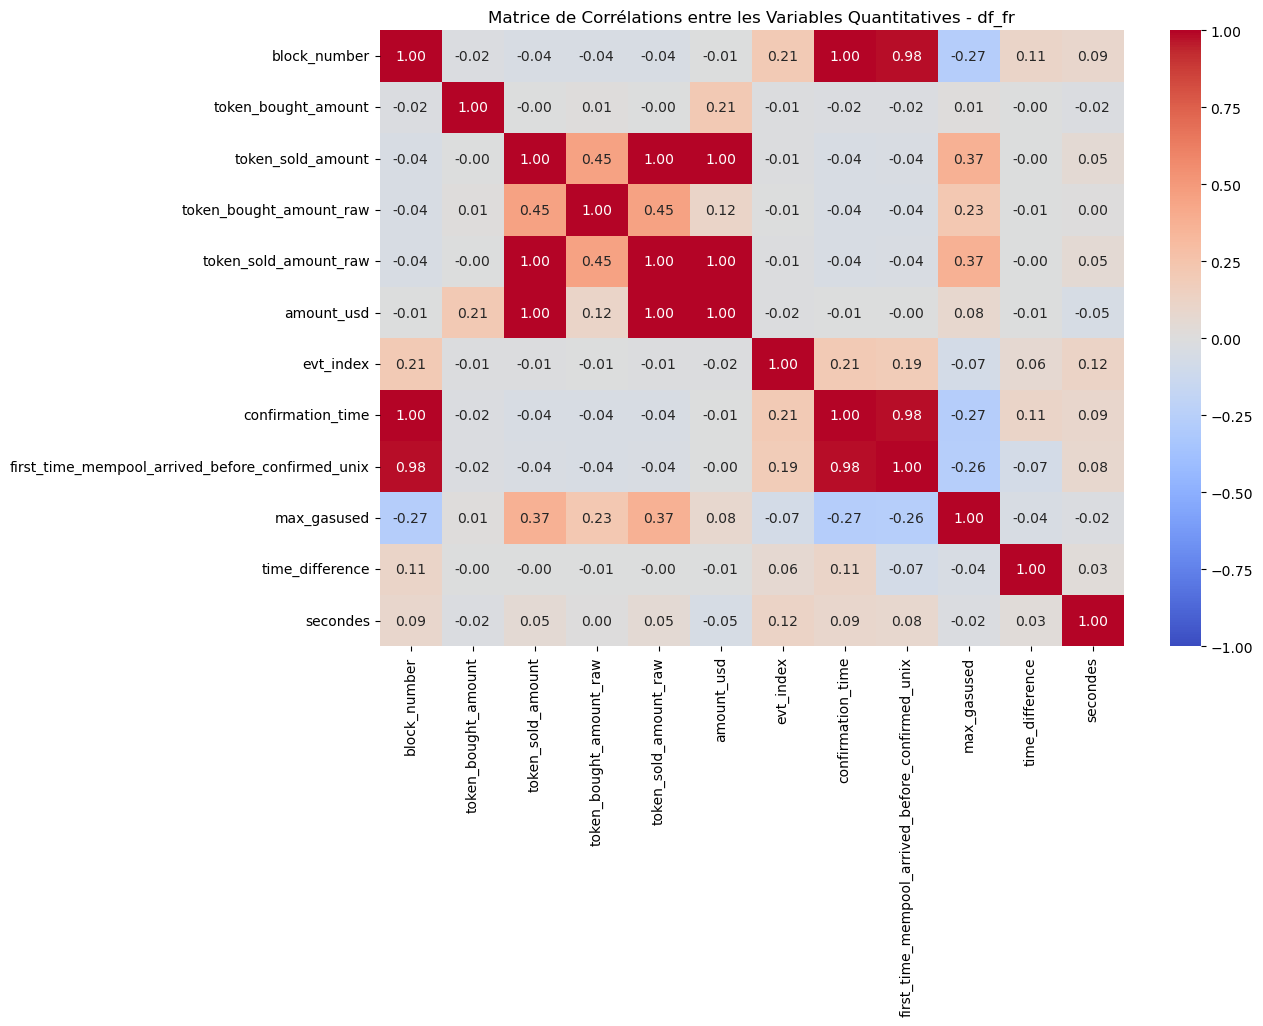

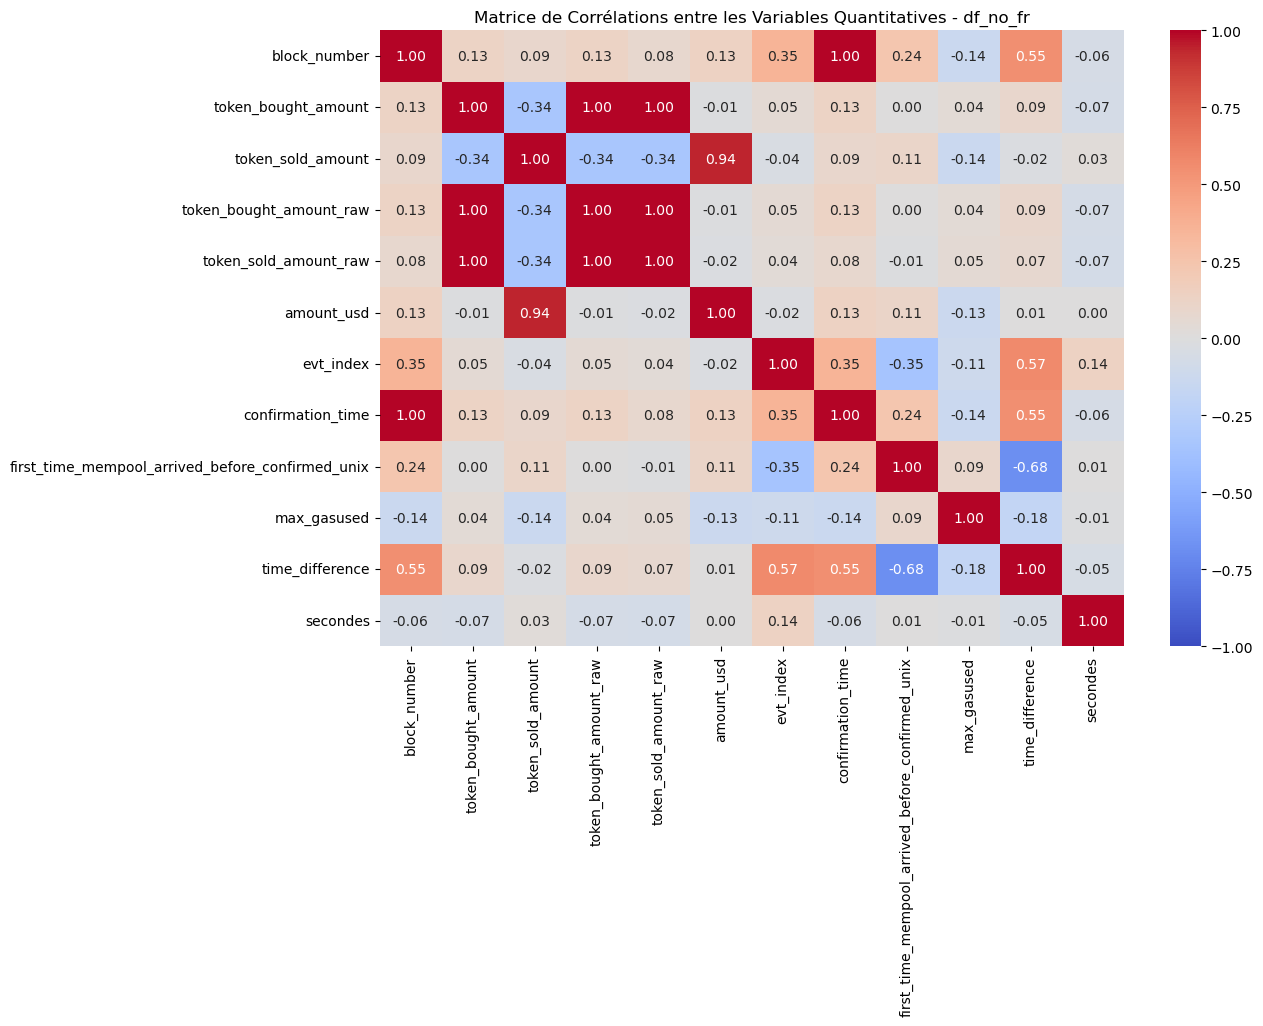

In [288]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Exclure la variable cible de df_fr
df_fr_numeriques = df_fr.drop(columns=['high_potential_front_running']).select_dtypes(include=[np.number])

# Calculer la matrice de corrélations pour df_fr
corr_matrix_fr = df_fr_numeriques.corr()

# Créer la heatmap de la matrice de corrélations pour df_fr
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_fr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title('Matrice de Corrélations entre les Variables Quantitatives - df_fr')
plt.show()

# Exclure la variable cible de df_no_fr
df_no_fr_numeriques = df_no_fr.drop(columns=['high_potential_front_running']).select_dtypes(include=[np.number])

# Calculer la matrice de corrélations pour df_no_fr
corr_matrix_no_fr = df_no_fr_numeriques.corr()

# Créer la heatmap de la matrice de corrélations pour df_no_fr
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_no_fr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title('Matrice de Corrélations entre les Variables Quantitatives - df_no_fr')
plt.show()


## Interprétation de la matrice de corrélation des potentielles auteurs de front-running

La matrice de corrélation des données des potentielles auteures du front-running révèle des relations intrigantes : elle montre une presque parfaite corrélation de 0.999996 entre `confirmation_time` et `block_number`, indiquant une synchronisation remarquable entre le temps de confirmation et le numéro de bloc, tandis que `first_time_mempool_arrived_before_confirmed_unix` est fortement corrélée avec `block_number` à 0.932534, suggérant que les transactions arrivées plus tôt dans le mempool sont fortement liées aux numéros de blocs ultérieurs ; de plus, une corrélation notable de 0.503919 entre `token_bought_amount` et `token_sold_amount` indique une relation importante entre les quantités de tokens achetés et vendus, alors que les corrélations négatives significatives entre `token_bought_amount_raw` et `token_sold_amount_raw` (-0.842107) ainsi qu'entre `amount_usd` et `token_sold_amount_raw` (-0.841624) montrent que les augmentations dans les quantités brutes de tokens achetés sont associées à des diminutions dans les quantités vendues et que la valeur en USD a une relation inverse avec la quantité brute des tokens vendus ; en revanche, les faibles corrélations entre `secondes` et `time_difference` (0.010554), ainsi qu'entre `token_bought_amount` et `secondes` (-0.065446), suggèrent peu ou pas de relation évidente entre les aspects temporels et les quantités achetées, tandis que la corrélation modérée entre `evt_index` et `time_difference` (0.085568) indique une légère connexion entre les indices d'événements et les différences de temps, et les corrélations faibles entre `first_time_mempool_arrived_before_confirmed_unix` et diverses autres variables, comme `evt_index` (-0.160833), soulignent des caractéristiques distinctives des transactions arrivées plus tôt dans le mempool, offrant ainsi un aperçu détaillé et parfois inattendu des relations complexes dans les données des potentielles auteures du front-running.

## Interprétation de la matrice de corrélation des potentielles victimes de front-running

La première matrice de corrélation des données des supposés victimes du front-running dévoile des relations particulièrement intéressantes entre les variables : on observe une corrélation exceptionnelle de 1.0 entre `token_sold_amount` et `amount_usd`, indiquant que la valeur en USD des tokens vendus est directement proportionnelle à la quantité vendue ; de plus, `confirmation_time` montre une presque parfaite corrélation avec `block_number` (0.999996), suggérant que le temps de confirmation évolue de manière presque synchrone avec le numéro de bloc. La corrélation négative marquée de -0.911821 entre `token_bought_amount_raw` et `token_sold_amount_raw` révèle que les augmentations dans la quantité achetée brute sont fortement associées à des diminutions dans la quantité vendue brute. En revanche, la corrélation très faible de -0.031320 entre `block_number` et `token_bought_amount` indique qu'il n'y a pas de lien évident entre le numéro de bloc et la quantité de tokens achetés. De plus, la faible corrélation de -0.140124 entre `time_difference` et `max_gasused` suggère que la différence de temps a peu d'influence sur la consommation maximale de gaz. Enfin, les corrélations négatives notables de `first_time_mempool_arrived_before_confirmed_unix` avec `evt_index` (-0.623395) et `time_difference` (-0.677455) mettent en lumière que les transactions arrivées plus tôt dans le mempool présentent des caractéristiques distinctives, telles que des différences de temps plus longues ou des indices d'événements différents.

## Bilan des matrices de corrélations

Les deux matrices de corrélation révèlent une forte relation entre `token_sold_amount` et `amount_usd` ainsi qu'une presque parfaite corrélation entre `confirmation_time` et `block_number` dans les deux ensembles de données, mais des variations notables dans les corrélations des quantités brutes de tokens et des aspects temporels suggèrent des différences dans les comportements des supposés et des potentielles auteures du front-running.

## Conclusion de cette analyse

Visuellement et statistiquement, les deux groupes séparés par la variable cible ne semblent pas si différents. Pour améliorer ce notebook, il serait pertinent d'ajouter des données comme le prix du token au moment où la transaction arrive dans le mempool ainsi qu'au moment où elle est confirmée, afin d'analyser d'éventuelles variations de prix. Ce type de détail pourrait être crucial pour la victime de front-running, qui pourrait se retrouver à payer un prix plus élevé que celui prévu lors de la soumission de son ordre.

# Classification binaire du jeu de données finale

In [298]:
df_ml = df_analyse.copy()

In [299]:
# Enregistrer le DataFrame en CSV
df_ml.to_csv('df_ml.csv', index=False)

In [300]:
df_ml.dtypes

block_number                                           int32
token_bought_symbol                                 category
token_sold_symbol                                   category
token_pair                                          category
token_bought_amount                                  float64
token_sold_amount                                    float64
token_bought_amount_raw                              float64
token_sold_amount_raw                                float64
amount_usd                                           float64
evt_index                                              int64
confirmation_time                                      int64
first_time_mempool_arrived_before_confirmed_unix       int64
max_gasused                                          float64
time_difference                                        int64
high_potential_front_running                           int64
secondes                                               int32
dtype: object

In [301]:
df_ml.isnull().mean()*100

block_number                                        0.000000
token_bought_symbol                                 0.000000
token_sold_symbol                                   0.000000
token_pair                                          0.000000
token_bought_amount                                 0.000000
token_sold_amount                                   0.000000
token_bought_amount_raw                             0.000000
token_sold_amount_raw                               0.000000
amount_usd                                          0.081833
evt_index                                           0.000000
confirmation_time                                   0.000000
first_time_mempool_arrived_before_confirmed_unix    0.000000
max_gasused                                         0.000000
time_difference                                     0.000000
high_potential_front_running                        0.000000
secondes                                            0.000000
dtype: float64

## Mise en place du modèle de machine learning

Comme on a pu le voir dans nos analyses précédentes, nous avons des variables qui ont tendance à être distribuées de manière concentrée autour de certaines valeurs spécifiques, c'est-à-dire qu'elles présentent une faible variabilité et une forte concentration autour de certaines valeurs centrales, ce qui peut limiter la diversité des observations et influencer les résultats de nos analyses.

Compte tenu de la faible quantité de données disponibles, nous avons opté pour le modèle XGBoost. Concernant la sélection des variables, il est préférable de conserver toutes les variables disponibles en raison du nombre limité de caractéristiques exploitables.

In [305]:
# Supprimer les variables catégorielles de df_fr
#df_ml = df_ml.drop(columns=['token_bought_symbol', 'token_sold_symbol', 'token_pair'])

Nous avons décidé de les exclure, car elles apportent peu d'informations supplémentaires et ne permettent pas de mieux distinguer si une transaction présente un 'haut potentiel' d'être à l'origine du front-running.

In [307]:
df_ml.dtypes

block_number                                           int32
token_bought_symbol                                 category
token_sold_symbol                                   category
token_pair                                          category
token_bought_amount                                  float64
token_sold_amount                                    float64
token_bought_amount_raw                              float64
token_sold_amount_raw                                float64
amount_usd                                           float64
evt_index                                              int64
confirmation_time                                      int64
first_time_mempool_arrived_before_confirmed_unix       int64
max_gasused                                          float64
time_difference                                        int64
high_potential_front_running                           int64
secondes                                               int32
dtype: object

# Xgboost

In [309]:
from sklearn.model_selection import train_test_split

# Liste des colonnes sélectionnées pour l'analyse
selected_columns = [
    'confirmation_time',                           # Temps de confirmation de la transaction
    'first_time_mempool_arrived_before_confirmed_unix', # Premier temps d'arrivée dans le mempool avant confirmation
    'max_gasused',                                 # Gaz maximal utilisé pour la transaction
    'time_difference',                             # Différence de temps entre certains événements
    'secondes',                                    # Durée en secondes de la transaction
    'high_potential_front_running',                 # Variable cible indiquant le potentiel de front-running
    'token_bought_amount',                         # Montant de tokens achetés
    'token_sold_amount',                           # Montant de tokens vendus
    'token_bought_amount_raw',                     # Montant brut de tokens achetés
    'token_sold_amount_raw',                       # Montant brut de tokens vendus
    'amount_usd'                                   # Montant total en USD
]

# Sélection des colonnes pertinentes dans le DataFrame df_ml
"""
    En alternative, on pourrait réduire les colonnes sélectionnées pour inclure uniquement :
    - 'confirmation_time'
    - 'max_gasused'
    - 'time_difference'
    - 'secondes'
    - 'high_potential_front_running'
"""
df_ml_selected = df_ml[selected_columns]

# Séparation des variables indépendantes (X) et de la variable cible (y)
X = df_ml_selected.drop(columns=['high_potential_front_running'])  # Variables indépendantes
y = df_ml_selected['high_potential_front_running']                 # Variable cible

# Division des données en ensembles d'entraînement et de test avec un ratio de 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Compromis biais-variance

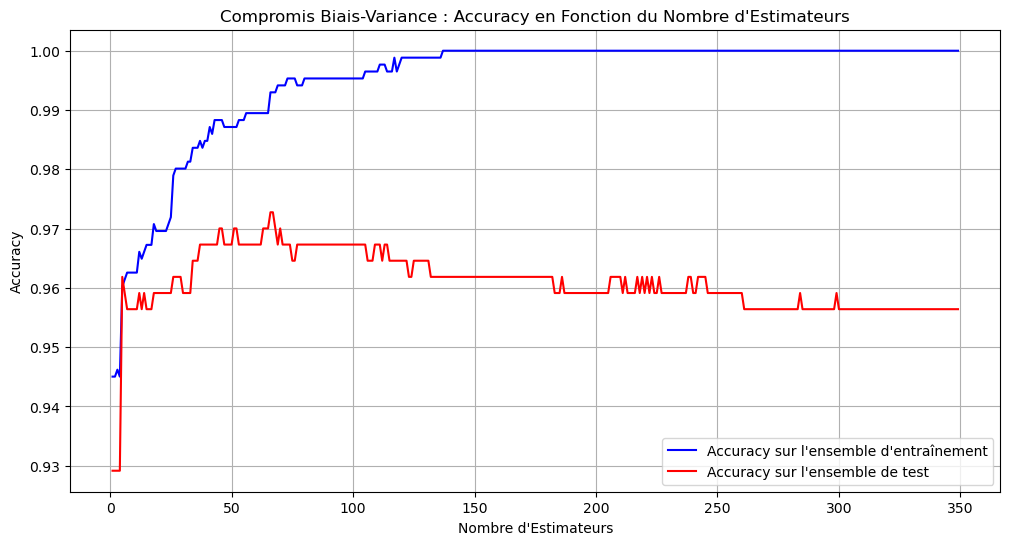

In [311]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Listes pour stocker les scores d'exactitude pour les ensembles d'entraînement et de test
accuracy_train_scores = []
accuracy_test_scores = []

# Plage de valeurs pour le nombre d'estimateurs à tester
estimators = range(1, 350)

# Boucle pour tester différentes valeurs de n_estimators
for est in estimators:
    model = xgb.XGBClassifier(n_estimators=est, max_depth=2)
    model.fit(X_train, y_train)
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    
    accuracy_train_scores.append(accuracy_train)
    accuracy_test_scores.append(accuracy_test)

# Trouver le maximum de l'exactitude sur l'ensemble de test
max_accuracy = max(accuracy_test_scores)
max_accuracy_index = accuracy_test_scores.index(max_accuracy)
best_parameter = estimators[max_accuracy_index]

# Création d'un graphique pour visualiser les scores d'exactitude
plt.figure(figsize=(12, 6))
plt.plot(estimators, accuracy_train_scores, label='Accuracy sur l\'ensemble d\'entraînement', color='blue')
plt.plot(estimators, accuracy_test_scores, label='Accuracy sur l\'ensemble de test', color='red')

# Ajouter des labels et un titre au graphique
plt.xlabel('Nombre d\'Estimateurs')
plt.ylabel('Accuracy')
plt.title('Compromis Biais-Variance : Accuracy en Fonction du Nombre d\'Estimateurs')
plt.legend()
plt.grid(True)

# Enregistrer le graphique en PNG
plt.savefig('accuracy_plot.png', bbox_inches='tight', dpi=300)

# Afficher le graphique
plt.show()


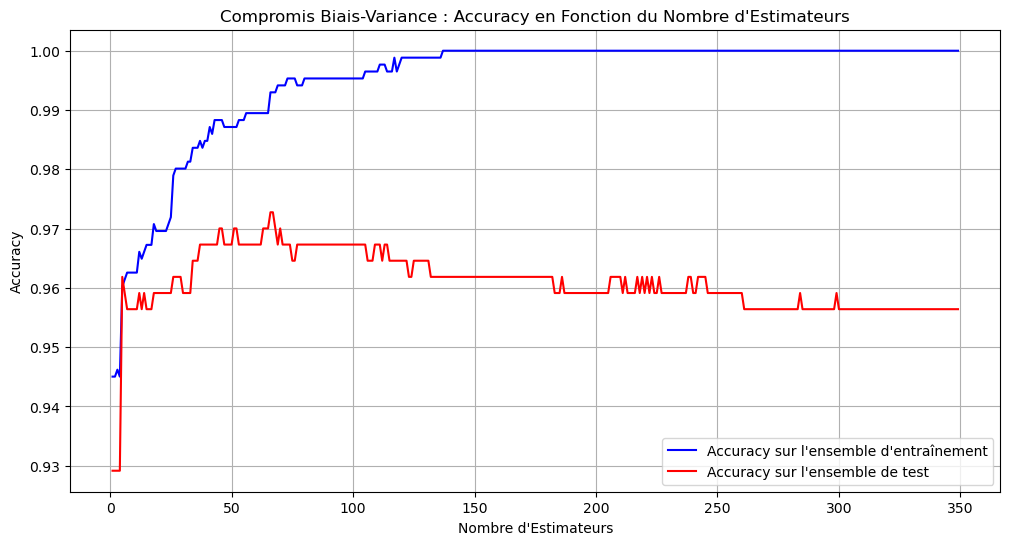

In [312]:
import xgboost as xgb
from sklearn.metrics import accuracy_score  # Importation de la fonction pour calculer l'exactitude

# Listes pour stocker les scores d'exactitude pour les ensembles d'entraînement et de test
accuracy_train_scores = []
accuracy_test_scores = []

# Plage de valeurs pour le nombre d'estimateurs à tester
estimators = range(1, 350)

# Boucle pour tester différentes valeurs de n_estimators
for est in estimators:
    # Création du modèle XGBoost avec le nombre d'estimateurs actuel et une profondeur maximale de 2
    model = xgb.XGBClassifier(n_estimators=est, max_depth=2)
    
    # Entraînement du modèle sur l'ensemble d'entraînement
    model.fit(X_train, y_train)
    
    # Prédictions sur l'ensemble d'entraînement
    y_pred_train = model.predict(X_train)
    # Prédictions sur l'ensemble de test
    y_pred_test = model.predict(X_test)
    
    # Calcul de l'exactitude pour l'ensemble d'entraînement
    accuracy_train = accuracy_score(y_train, y_pred_train)
    # Calcul de l'exactitude pour l'ensemble de test
    accuracy_test = accuracy_score(y_test, y_pred_test)
    
    # Stockage des scores d'exactitude
    accuracy_train_scores.append(accuracy_train)
    accuracy_test_scores.append(accuracy_test)

# Trouver le maximum de l'exactitude sur l'ensemble de test
max_accuracy = max(accuracy_test_scores)
# Trouver l'indice du maximum pour identifier le meilleur nombre d'estimateurs
max_accuracy_index = accuracy_test_scores.index(max_accuracy)
# Déterminer le meilleur nombre d'estimateurs
best_parameter = estimators[max_accuracy_index]

# Création d'un graphique pour visualiser les scores d'exactitude
plt.figure(figsize=(12, 6))

# Tracer la courbe de l'exactitude pour l'ensemble d'entraînement
plt.plot(estimators, accuracy_train_scores, label='Accuracy sur l\'ensemble d\'entraînement', color='blue')
# Tracer la courbe de l'exactitude pour l'ensemble de test
plt.plot(estimators, accuracy_test_scores, label='Accuracy sur l\'ensemble de test', color='red')

# Ajouter des labels et un titre au graphique
plt.xlabel('Nombre d\'Estimateurs')
plt.ylabel('Accuracy')
plt.title('Compromis Biais-Variance : Accuracy en Fonction du Nombre d\'Estimateurs')
plt.legend()  # Ajouter une légende pour les courbes
plt.grid(True)  # Ajouter une grille pour une meilleure lisibilité

# Afficher le graphique
plt.show()

Ce code utilise le modèle **XGBoost** pour entraîner et évaluer un classificateur à travers une gamme de valeurs pour le paramètre `n_estimators`. Voici les points essentiels de ce code :

### 1. **Objectif du Code**
   - Le but est de tester l'impact du nombre d'estimateurs (arbres) sur les performances d'un modèle **XGBoost** pour un problème de classification. Le modèle est entraîné sur un ensemble d'entraînement (`X_train`, `y_train`) et évalué sur un ensemble de test (`X_test`, `y_test`).
   - **n_estimators** détermine le nombre d'arbres que XGBoost construit. Ce paramètre est ajusté pour trouver la meilleure performance du modèle.

### 2. **Étapes Principales**
   - **Initialisation des variables** :
     - Deux listes (`accuracy_train_scores` et `accuracy_test_scores`) sont créées pour stocker l'accuracy (exactitude) du modèle sur les ensembles d'entraînement et de test.
     - Une plage de valeurs pour `n_estimators` est définie de 1 à 350.
   
   - **Boucle de validation** :
     - Pour chaque valeur de `n_estimators`, un modèle **XGBoost** est créé avec une profondeur maximale fixe (`max_depth=2`).
     - Le modèle est ensuite entraîné sur les données d'entraînement.
     - Les prédictions sont réalisées sur les ensembles d'entraînement et de test.
     - L'exactitude (accuracy) des prédictions est calculée à l'aide de la fonction `accuracy_score` de **scikit-learn**, puis stockée dans les listes.

   - **Sélection du meilleur modèle** :
     - Après la boucle, le code cherche le nombre d'estimateurs qui a donné le score d'exactitude maximum sur l'ensemble de test.
     - Il identifie cette valeur en trouvant l'index de la meilleure accuracy dans la liste des scores de test (`accuracy_test_scores`).

### 3. **Visualisation**
   - Un graphique est tracé pour visualiser comment l'exactitude varie en fonction du nombre d'estimateurs.
   - Le graphique montre deux courbes :
     - Une pour l'exactitude sur l'ensemble d'entraînement (en bleu).
     - Une pour l'exactitude sur l'ensemble de test (en rouge).
   - Cela permet de visualiser le compromis entre biais et variance (sous-apprentissage vs sur-apprentissage) :
     - Si la courbe d'entraînement augmente mais celle de test diminue, cela indique un risque de **surapprentissage**.
     - Si les deux courbes sont basses, cela montre un **sous-apprentissage**.

### 4. **Résumé des Points Clés**
   - **n_estimators** : Paramètre clé qui contrôle combien d'arbres le modèle construit. Plus d'arbres peuvent réduire le biais, mais trop peuvent entraîner un surapprentissage.
   - **max_depth=2** : Garde les arbres peu profonds pour éviter la complexité excessive.
   - **accuracy_score** : Utilisé pour évaluer les performances du modèle en termes de proportion de bonnes prédictions.
   - **Courbes de Biais-Variance** : Montrent comment la performance évolue avec le nombre d'arbres, aidant à comprendre où se situe le meilleur compromis entre biais et variance.

### 5. **Conclusion**
   Ce processus permet de déterminer le meilleur nombre d'arbres pour optimiser les performances du modèle **XGBoost**, en équilibrant les risques de surapprentissage et sous-apprentissage, puis visualise ce compromis à l'aide de courbes.

## Entrainement du modèle

In [315]:
# Création du modèle XGBoost avec le meilleur nombre d'estimateurs déterminé précédemment et une profondeur maximale de 2
model = xgb.XGBClassifier(n_estimators=best_parameter, max_depth=2)

# Entraînement du modèle sur l'ensemble d'entraînement
model.fit(X_train, y_train)

# Prédictions sur l'ensemble d'entraînement
y_pred_train = model.predict(X_train)
# Prédictions sur l'ensemble de test
y_pred_test = model.predict(X_test)

# Calcul de l'exactitude (accuracy) sur l'ensemble d'entraînement
accuracy_train = accuracy_score(y_train, y_pred_train)
# Calcul de l'exactitude (accuracy) sur l'ensemble de test
accuracy_test = accuracy_score(y_test, y_pred_test)

## Matrice de confusion

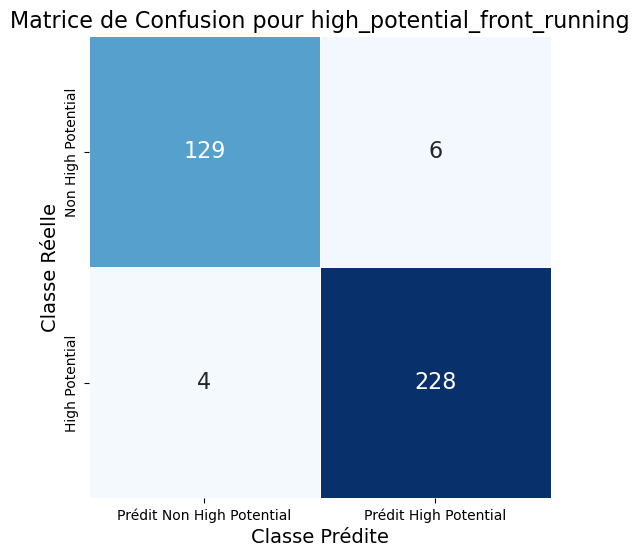


Rapport de classification:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       135
           1       0.97      0.98      0.98       232

    accuracy                           0.97       367
   macro avg       0.97      0.97      0.97       367
weighted avg       0.97      0.97      0.97       367



In [317]:
# Importation des bibliothèques nécessaires
import pandas as pd  # Pour la manipulation des DataFrames
import matplotlib.pyplot as plt  # Pour la visualisation
import seaborn as sns  # Pour la création de heatmaps
import numpy as np  # Pour les opérations numériques

# Importation des outils de machine learning
from sklearn.metrics import confusion_matrix, classification_report  # Pour la matrice de confusion et le rapport de classification

# Calcul de la matrice de confusion pour les prédictions de l'ensemble de test
cm = confusion_matrix(y_test, y_pred_test)

# Création d'un DataFrame pour la matrice de confusion avec des labels pour les lignes et les colonnes
cm_df = pd.DataFrame(cm, index=['Non High Potential', 'High Potential'], 
                     columns=['Prédit Non High Potential', 'Prédit High Potential'])

# Tracé de la matrice de confusion en utilisant un heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='d', cbar=False, linewidths=.5, square=True, 
            annot_kws={"size": 16},  # Taille des annotations dans le heatmap
            vmin=0, vmax=np.max(cm))  # Plage des valeurs pour l'échelle des couleurs

# Titre et labels des axes
plt.title('Matrice de Confusion pour high_potential_front_running', fontsize=16)
plt.xlabel('Classe Prédite', fontsize=14)
plt.ylabel('Classe Réelle', fontsize=14)

# Enregistrer la matrice de confusion en tant qu'image PNG
plt.savefig('matrice_de_confusion.png', bbox_inches='tight', dpi=300)

# Affichage du heatmap
plt.show()

# Affichage du rapport de classification pour l'ensemble de test
print("\nRapport de classification:")
print(classification_report(y_test, y_pred_test))

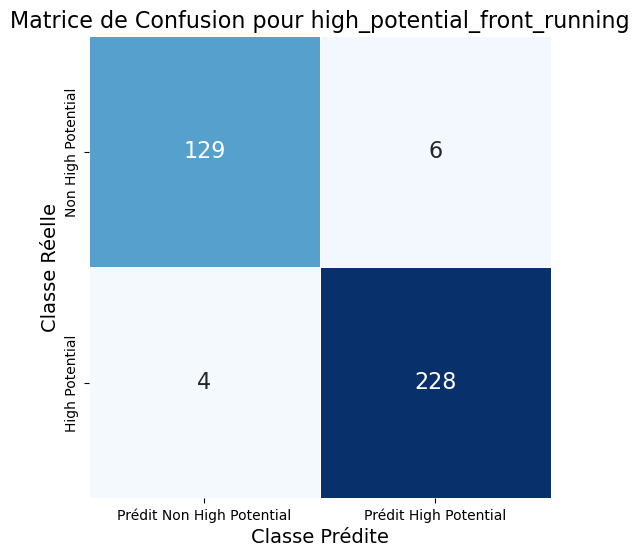


Rapport de classification:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       135
           1       0.97      0.98      0.98       232

    accuracy                           0.97       367
   macro avg       0.97      0.97      0.97       367
weighted avg       0.97      0.97      0.97       367



In [318]:
# Importation des bibliothèques nécessaires
import pandas as pd  # Pour la manipulation des DataFrames
import matplotlib.pyplot as plt  # Pour la visualisation
import seaborn as sns  # Pour la création de heatmaps

# Importation des outils de machine learning
from sklearn.metrics import confusion_matrix, classification_report  # Pour la matrice de confusion et le rapport de classification

# Calcul de la matrice de confusion pour les prédictions de l'ensemble de test
cm = confusion_matrix(y_test, y_pred_test)

# Création d'un DataFrame pour la matrice de confusion avec des labels pour les lignes et les colonnes
cm_df = pd.DataFrame(cm, index=['Non High Potential', 'High Potential'], 
                     columns=['Prédit Non High Potential', 'Prédit High Potential'])

# Tracé de la matrice de confusion en utilisant un heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='d', cbar=False, linewidths=.5, square=True, 
            annot_kws={"size": 16},  # Taille des annotations dans le heatmap
            vmin=0, vmax=np.max(cm))  # Plage des valeurs pour l'échelle des couleurs

# Titre et labels des axes
plt.title('Matrice de Confusion pour high_potential_front_running', fontsize=16)
plt.xlabel('Classe Prédite', fontsize=14)
plt.ylabel('Classe Réelle', fontsize=14)

# Affichage du heatmap
plt.show()

# Affichage du rapport de classification pour l'ensemble de test
print("\nRapport de classification:")
print(classification_report(y_test, y_pred_test))


Le modèle XGBoost offre d'excellents résultats sur ces données, mais il semble que la variabilité soit limitée. Les analyses indiquent que les transactions classées comme ayant un fort potentiel de front running ne présentent pas de différences significatives par rapport aux transactions non étiquetées. Pour l'étiquetage final du jeu de données, nous avons basé notre approche sur les critères principaux du front running. Pour améliorer ce travail à l'avenir, il serait pertinent d'enrichir les données en ajoutant davantage de variables. Il serait également judicieux d'explorer d'autres moyens pour récupérer des données provenant de mempool, en particulier de chaînes différentes de celle d'Ethereum.

# Conclusion

Le travail accompli jusqu'à présent a été enrichissant. Il serait pertinent d'approfondir cette analyse en développant un début de méthode pour détecter les attaques de type "sandwich" sur des plateformes décentralisées, voire sur d'autres environnements similaires.

# Sandwich attack dans le contexte de DEX

La définition suivante nous provient d'[Uniswap](https://support.uniswap.org/hc/en-us/articles/19387081481741-What-is-a-sandwich-attack), une plateforme d'échange décentralisée.

Une **sandwich attack** est une attaque exploitant la transparence des transactions sur la blockchain et le mécanisme de **slippage** (glissement de prix) lors des échanges de tokens, particulièrement sur des plateformes comme Uniswap. Voici comment elle fonctionne en détail :

### Fonctionnement d'une sandwich attack

1. **Initiation de la transaction de l'utilisateur** :
   - Un utilisateur soumet une transaction pour échanger un token sur Uniswap (ou une autre plateforme décentralisée). Cette transaction est en attente de confirmation.

2. **Front-running par l'attaquant** :
   - Un attaquant surveille les transactions en attente et identifie que la transaction de l'utilisateur va provoquer une augmentation du prix du token échangé.
   - L'attaquant soumet une transaction juste avant celle de l'utilisateur pour acheter le token à un prix inférieur. Cette action est appelée **front-running**.

3. **Exécution de la transaction de l'utilisateur** :
   - La transaction de l'utilisateur est ensuite confirmée, mais à un prix plus élevé à cause de la demande accrue provoquée par l'achat de l'attaquant. Par conséquent, l'utilisateur reçoit moins de tokens que prévu.

4. **Back-running par l'attaquant** :
   - Après que l'utilisateur a complété sa transaction, l'attaquant revend les tokens achetés lors de la première étape, mais cette fois à un prix plus élevé. C'est ce qu'on appelle le **back-running**.

### Résultat de l'attaque
- **L'attaquant réalise un profit** en profitant de la différence de prix créée par la transaction de l'utilisateur.
- **L'utilisateur subit une perte** car il a acheté les tokens à un prix plus élevé et en a reçu moins que prévu.

### Pourquoi ces attaques sont possibles
Ces attaques sont possibles en raison de :
- **La transparence des transactions** sur la blockchain, où les transactions en attente sont visibles publiquement.
- **Le slippage** (glissement de prix), qui fait que le prix des tokens peut fluctuer entre le moment où une transaction est soumise et confirmée.

### Moyens de réduire le risque de sandwich attacks

1. **Utiliser des pools de liquidité importants** : Les attaquants ciblent souvent les pools de petite taille, où leurs transactions peuvent avoir un impact significatif sur le prix des tokens.
   
2. **Utiliser une protection contre les swaps** : Certaines portefeuilles proposent des protections contre les **front-running** via des solutions comme les **MEV Blockers**, qui empêchent ces attaques en masquant ou en retardant la visibilité des transactions.

### Conclusion
Une sandwich attack se déroule lorsque l'attaquant "encadre" une transaction légitime entre deux transactions (d'où le nom "sandwich"), profitant ainsi de la fluctuation de prix qu'il a lui-même provoquée.

Sachant que nous traitons des **swaps**, il est intéressant d'exploiter les tables **dex.sandwiches**, **dex.sandwiched**, et **labels.sandwich_attakers**, qui pourraient nous fournir des informations sur les transactions victimes et les auteurs de **sandwich attacks** dans le cadre des swaps.
Même si nous avons choisi d'atteindre notre objectif en utilisant un **étiquetage personnalisé**.

# Ces tables peuvent nous donner la liste des adresses sybils en question, ayant subi ou été auteurs d'une sandwich attack ?

Le code suivant permet d'identifier les transactions associées à des comportements de type front-running ou back-running, en se basant sur la description de la table :

```sql
WITH sybil_list AS (
  SELECT
    address
  FROM dune.lillypad.dataset_l0_blacklist
) 
SELECT *
FROM dex.sandwiches
WHERE
    tx_from IN (SELECT address FROM sybil_list);
```

La table `dex.sandwiches` regroupe des informations détaillées sur les échanges externes (outer trades) impliqués dans des attaques de type "sandwich" au sein des exchanges décentralisés (DEX). Ces attaques sont une forme sophistiquée de front-running, où un acteur malveillant insère stratégiquement ses transactions avant et après une transaction cible, dans le but de manipuler le prix des actifs et de tirer profit de la différence générée par ces mouvements artificiels de marché.

En enregistrant les détails des trades qui participent à ces attaques, la table permet de suivre de près les activités suspectes sur divers réseaux compatibles EVM (Ethereum Virtual Machine). Ainsi, grâce à cette requête SQL, nous pouvons isoler les transactions effectuées par des adresses figurant dans la liste noire, qui pourraient être suspectées d'activités malveillantes liées au front-running, au back-running, ou à d'autres stratégies d'exploitation similaires.

Le code suivant permet d'identifier les transactions ayant été victimes d'attaques de type "sandwich" sur des plateformes d'échange décentralisées (DEX), en s'appuyant sur une liste noire d'adresses suspectes :

```sql
WITH sybil_list AS (
  SELECT
    address
  FROM dune.lillypad.dataset_l0_blacklist
) 
SELECT *
FROM dex.sandwiched
WHERE
    tx_from IN (SELECT address FROM sybil_list);
```

La table **`sandwiched`** joue un rôle clé dans la capture de données détaillées concernant les transactions victimes d'attaques de type "sandwich" sur des échanges décentralisés. Ces attaques exploitent deux manœuvres spécifiques : le front-running, où une transaction est insérée juste avant celle de la victime pour acheter un actif à un prix avantageux, et le back-running, qui consiste à revendre l'actif immédiatement après la transaction de la victime à un prix gonflé.

Cette table consigne avec précision les transactions qui ont été "sandwichées", offrant ainsi une vue complète sur ces pratiques malveillantes à travers différentes blockchains compatibles avec l'EVM (Ethereum Virtual Machine). Grâce à cette requête SQL, il devient possible de repérer les transactions émanant d'adresses identifiées comme potentiellement frauduleuses, facilitant ainsi l'analyse et la prévention des attaques sur les DEX.

Le code suivant permet de croiser des adresses suspectes avec celles identifiées comme ayant mené des attaques de type "sandwich" sur des exchanges décentralisés (DEX) :

```sql
WITH sybil_list AS (
  SELECT
    address
  FROM dune.lillypad.dataset_l0_blacklist
) 
SELECT *
FROM labels.sandwich_attackers
WHERE address IN (SELECT address FROM sybil_list);
```

La table **`sandwich_attackers`** recense des informations sur les adresses connues pour avoir lancé des attaques de type "sandwich" sur des DEX. Ces attaques consistent à manipuler les transactions des utilisateurs pour en tirer profit, en intercalant des opérations avant et après une transaction cible afin d'exploiter les variations de prix. La table contient des données essentielles qui aident à identifier les auteurs de telles pratiques.

Malheureusement, après analyse, aucune des adresses suspectes présentes dans notre liste Sybil n'a été impliquée dans des attaques de type "sandwich" sur les échanges décentralisés étudiés. Ce résultat indique que, bien que ces adresses soient potentiellement malveillantes, elles ne semblent pas avoir participé à ce type particulier d'exploitation.

Pour cette dernière table, voici la description de la logique utilisée pour identifier un **attaquant sandwich** :

### Logique pour identifier un attaquant sandwich

L'identification d'un attaquant sandwich repose sur plusieurs critères logiques analysant les transactions effectuées dans un même bloc. Voici une explication détaillée de cette logique :

1. **Deux transactions distinctes, t1 et t2, dans le même bloc, initiées par la même adresse** : Un attaquant sandwich effectue généralement deux transactions distinctes (une de front-running et une de back-running) dans le même bloc, toutes initiées par la même adresse.

2. **Les transactions se produisent sur le même projet** : Les deux transactions doivent avoir lieu sur la même plateforme ou DEX, comme Uniswap ou SushiSwap.

3. **Le token acheté dans t1 est le même que celui vendu dans t2** : L'attaquant achète un token dans la première transaction (t1) et le revend dans la seconde transaction (t2).

4. **Le token vendu dans t1 est le même que celui acheté dans t2** : L'attaquant vend un token dans la première transaction (t1) et rachète ce même token dans la seconde transaction (t2).

5. **La quantité achetée dans t1 est égale à la quantité vendue dans t2** : Cela indique que l'attaquant manipule les prix en achetant et vendant exactement la même quantité de token.

6. **Exclusion des cas où la quantité vendue dans t1 est inférieure à la quantité achetée dans t2** : Ce critère permet d'exclure les transactions où l'attaquant perd de l'argent (transaction perdante).

7. **(Index de t1 >= index de t2 + 2) ou (index de t2 >= index de t1 + 2)** : Ce critère assure que les deux transactions sont suffisamment éloignées dans le bloc pour être considérées comme un sandwich. Les transactions trop proches (dans des index adjacents) pourraient être des faux positifs.

8. **Exclusion de l'adresse du routeur Uniswap v2** : Cette adresse, souvent incluse par erreur dans des attaques sandwich, est en réalité utilisée pour des transactions régulières. Il est donc crucial de l'exclure pour éviter les faux positifs.

### Notes supplémentaires :

- **Inclusion des attaques buy-first et sell-first** : La logique permet de détecter à la fois les attaques où l'achat précède la vente (buy-first) et celles où la vente précède l'achat (sell-first).

- **Inclusion des attaquants ne utilisant pas de flashbots** : En utilisant l'opérateur `>=` au lieu de `=`, la logique permet également de détecter des attaquants qui ne regroupent pas nécessairement leurs transactions via des services comme Flashbots, souvent utilisés pour dissimuler les transactions.

### Conclusion

Cette table et la logique associée sont conçues pour identifier les adresses impliquées dans des attaques sandwich, une forme de manipulation des prix sur les DEXs. L'approche permet de détecter les motifs de comportement des attaquants tout en minimisant les faux positifs.

# Notre stratégie pour confirmer si il y'a présence de swap auteur de sandwich-attack sur des plateformes d'échanges décentralisées

Ainsi, pour détecter les transactions dites de `back-run`, il faut, pour chaque clé, identifier un swap où le token précédemment acheté est ensuite vendu, créant ainsi une situation d'arbitrage. Plus précisément, il s'agit de trouver, pour chaque clé, un swap dont la confirmation se fait après la première transaction (achat), et où le prix du token est supérieur ou égal à celui payé lors du premier swap. Cela permettrait de capturer les opportunités d'arbitrage.

On sait que notre jeu de données provenant de dune le plus récent possible est `df_all_hash_with_confirmation_time` et le dictionnaire le plus récent est filtered_sybil_to_matched_hashes_with_earlier_or_equal_time 

In [333]:
# Nombre de clés dans le dictionnaire
nombre_de_clés = len(filtered_sybil_to_matched_hashes_with_earlier_or_equal_time)

# Nombre total de valeurs dans le dictionnaire
nombre_de_valeurs = sum(len(valeurs) for valeurs in filtered_sybil_to_matched_hashes_with_earlier_or_equal_time.values())

print(f"Nombre de clés : {nombre_de_clés}")
print(f"Nombre total de valeurs : {nombre_de_valeurs}")


Nombre de clés : 806
Nombre total de valeurs : 2221


## Savoir qui a engagé les swaps à haut potentiels de front-running !

In [335]:
# Dictionnaire pour stocker les résultats
resultats = []

# Liste pour stocker les clés
cles = []

# Boucle sur chaque clé dans filtered_sybil_to_matched_hashes_with_earlier_or_equal_time
for key, values in filtered_sybil_to_matched_hashes_with_earlier_or_equal_time.items():
    # Ajouter chaque clé à la liste des clés
    cles.append(key)

In [336]:
# Supposons que la colonne contenant les hash dans df_all_hash_with_confirmation_time s'appelle 'hash'
# Et que 'tx_from' est la colonne contenant les adresses que tu souhaites extraire

# Créer un dictionnaire pour stocker les résultats
tx_from_dict = {}

# Parcourir chaque hash dans le dictionnaire Clés
for h in cles:
    # Rechercher dans le DataFrame la ligne qui correspond au hash
    row = df_all_hash_with_confirmation_time[df_all_hash_with_confirmation_time['tx_hash'] == h]
    
    # Si une correspondance est trouvée, ajouter tx_from dans le dictionnaire
    if not row.empty:
        tx_from_dict[h] = row['tx_from'].values[0]  # On accède à la première valeur de la colonne 'tx_from'

# Afficher ou utiliser tx_from_dict comme bon te semble
tx_from_dict

{'0x0036d3a2c9e788efb80a9236cea7768a499c3b3f3d7879ab10e790a1ce3387ef': '0xf1a463ab70ba7ae9beed8cd1f36bfc10b1dfcb94',
 '0x00474e802989bb78eabd397be376a7e87d0b013d0f3c490608c665cb32f39917': '0xb0ebd10aa8e3b7af7f1ac0b84f39207aad1f0ec9',
 '0x0053d776e57808d780d9a349c45ee469b8cd7b26ea4f206d671c65f0257de893': '0x00bd309943e81a75d5f03063d97e1eea877c3dcb',
 '0x00f18dcedb60f6412272ab149f10f08437a475f28682791b6f57050f811d2586': '0x193888dad7f1b545948866c4175b4ad09c3d8a1c',
 '0x012ea049f0ec72e98314e82fc0a58490c0ceeb62697f73922b057f25673f8a57': '0x747a1410feecce7915f8a07072d2d365d5e93b60',
 '0x01fa7c08c390c67fe67cdc0f47fd6aacf07532ae846c4bca26df950a1feb60a3': '0x6bc6041d11ed5674d41690d4eb02a178ffe275c9',
 '0x020ab96ab7f4cf9541a5b9761e7a394dc16ef4daa32f0e5b155efaca163336a2': '0x0bb717e3cf418ce9957336d6e7fb9d7256a307dd',
 '0x0272f0bc9de47a0c75847d0e2ee5e3cd63aad09be87d0ebce424f47feb668452': '0x5e1e85b56337723e40ad436509c6d23a5f85186e',
 '0x029e6cc77c8b5197af0b36519fbe46d415e97cfa97611df46907bbfcdfaa

Ce code extrait les adresses `tx_from` pour chaque hash dans le dictionnaire `clés` en consultant le DataFrame `df_all_hash_with_confirmation_time`. Le dictionnaire `tx_from_dict` résultant associe chaque hash à l'adresse de l'expéditeur de la transaction correspondante. Cette méthode est utile pour analyser ou suivre les transactions basées sur des hash spécifiques.

In [338]:
# Supposons que tx_from_dict est déjà défini comme dans le code précédent

# Extraire toutes les adresses (les valeurs du dictionnaire)
all_addresses = list(tx_from_dict.values())

# Si tu veux éviter les doublons, tu peux convertir en set
unique_addresses = set(all_addresses)

print("\nAdresses uniques:")
unique_addresses



Adresses uniques:


{'0x004b7fea51b72239137d6baf262a5244778a2d30',
 '0x006c4e75ab070277b86f6ab8b6409802657dbb92',
 '0x00a7e07e73beb3bb6edeaac7a27980b1bc9879d3',
 '0x00bd309943e81a75d5f03063d97e1eea877c3dcb',
 '0x00c0ff7ed92673b07175f398db0a10a4102f2388',
 '0x00e69e09278166971410896a85c8e506782a233c',
 '0x0131787dd3498296c43f44caeafe4cf2da9b878a',
 '0x01cb866c5f4d4d538d09de15566354389d08f58f',
 '0x0202a55da77af76a94d0c9063a6ae6ab9550e82f',
 '0x022252663253d24b324622e2b30f44982c1a7293',
 '0x0238be90b21d6d5a6f6fc5145d1c9ee0edca8b7b',
 '0x026f4ad88119c7c6da892fa473c7d311eec59894',
 '0x029327190bc66432a75e59d0821d277d57a5a0c2',
 '0x02b040e1fbef33cdfce31d31dc62c2f5dfc60eaa',
 '0x03fc52681c1aee75c99acb8294c6fce9cb601da0',
 '0x0426751f02996bab6eed9783fc208230f6ffee96',
 '0x04274be09c32559107c85e1d70182c31d906c34a',
 '0x050fb3b97a91d2968461d342d441ba3f81de1357',
 '0x05389882362830fb3a32993b300f351e506bde91',
 '0x055df63ea36efe95d8332d3b4962cfb72bc383a9',
 '0x05c65a1f6a614eea1c6c9e2835f940525d9ab56e',
 '0x05d90e483

In [339]:
# Créer un ensemble pour stocker les tokens achetés uniques
tokens_achetes = set()

# Boucle sur chaque tx_hash (clé) dans le dictionnaire
for tx_hash, _ in filtered_sybil_to_matched_hashes_with_earlier_or_equal_time.items():
    
    # Récupérer les tokens achetés pour ce tx_hash
    tokens_achetes_pour_cle = Jeu_de_données_final[
        Jeu_de_données_final['tx_hash'] == tx_hash
    ]['token_bought_symbol']
    
    # Ajouter les tokens achetés à l'ensemble
    tokens_achetes.update(tokens_achetes_pour_cle)

# Convertir l'ensemble en liste et trier les tokens achetés
tokens_achetes_list = sorted(tokens_achetes)

# Afficher les tokens achetés
print("Tokens achetés par toutes les clés :")
for token in tokens_achetes_list:
    print(token)

Tokens achetés par toutes les clés :
BALANCE
Crodie
IXS
LEND
MEGA
MEME
SMILEY
TMNT
WYNN
μCloneX


In [340]:
import pandas as pd


# Dictionnaire pour stocker les résultats
max_confirmation_times = {}

# Boucle sur chaque clé dans filtered_sybil_to_matched_hashes_with_earlier_or_equal_time
for key, values in filtered_sybil_to_matched_hashes_with_earlier_or_equal_time.items():
    
    # Récupérer les confirmations_times associées aux values
    confirmation_times = Jeu_de_données_final[Jeu_de_données_final['tx_hash'].isin(values)]['confirmation_time']
    
    # Trouver le maximum des confirmation_times pour ces values
    max_confirmation_time = confirmation_times.max()
    
    # Stocker le résultat dans le dictionnaire
    max_confirmation_times[key] = max_confirmation_time

# Afficher les résultats
for key, max_time in max_confirmation_times.items():
    print(f"Clé: {key}, Max confirmation_time: {max_time}")


Clé: 0x0036d3a2c9e788efb80a9236cea7768a499c3b3f3d7879ab10e790a1ce3387ef, Max confirmation_time: 1705303177
Clé: 0x00474e802989bb78eabd397be376a7e87d0b013d0f3c490608c665cb32f39917, Max confirmation_time: 1705305817
Clé: 0x0053d776e57808d780d9a349c45ee469b8cd7b26ea4f206d671c65f0257de893, Max confirmation_time: 1705304894
Clé: 0x00f18dcedb60f6412272ab149f10f08437a475f28682791b6f57050f811d2586, Max confirmation_time: 1705302001
Clé: 0x012ea049f0ec72e98314e82fc0a58490c0ceeb62697f73922b057f25673f8a57, Max confirmation_time: 1705322857
Clé: 0x01fa7c08c390c67fe67cdc0f47fd6aacf07532ae846c4bca26df950a1feb60a3, Max confirmation_time: 1705321369
Clé: 0x020ab96ab7f4cf9541a5b9761e7a394dc16ef4daa32f0e5b155efaca163336a2, Max confirmation_time: 1705305817
Clé: 0x0272f0bc9de47a0c75847d0e2ee5e3cd63aad09be87d0ebce424f47feb668452, Max confirmation_time: 1705305782
Clé: 0x029e6cc77c8b5197af0b36519fbe46d415e97cfa97611df46907bbfcdfaa2a79, Max confirmation_time: 1705305697
Clé: 0x02f613f6bcea4950c22941d820d740


### Résumé

- Ce code parcourt un dictionnaire contenant des clés et des listes de hash de transactions associées.
- Pour chaque clé, il filtre un DataFrame pour récupérer les transactions qui correspondent à ces hash.
- Il extrait ensuite les temps de confirmation des transactions et calcule le temps de confirmation maximal pour chaque clé.
- Les résultats sont stockés dans un nouveau dictionnaire `max_confirmation_times`, puis affichés.

Ce type de logique est souvent utilisé dans l'analyse de données pour identifier des informations importantes (ici, le temps de confirmation maximal) associées à un groupe d'éléments (les transactions).

In [342]:
import pandas as pd

# Dictionnaire pour stocker les résultats
resultats = []
resultats_set = set()  # Utiliser un set pour vérifier les doublons

# Boucle sur chaque clé dans filtered_sybil_to_matched_hashes_with_earlier_or_equal_time
for key, values in filtered_sybil_to_matched_hashes_with_earlier_or_equal_time.items():
    
    # Récupérer les confirmation_times associées aux values
    confirmation_times = df_all_hash_with_confirmation_time[df_all_hash_with_confirmation_time['tx_hash'].isin(values)]['confirmation_time']
    
    # Trouver le maximum des confirmation_times pour ces values
    max_confirmation_time = confirmation_times.max()
    
    # Récupérer tx_from et taker associés à cette clé
    tx_from_taker = df_all_hash_with_confirmation_time[df_all_hash_with_confirmation_time['tx_hash'] == key][['tx_from', 'taker', 'token_bought_symbol']].iloc[0]
    
    # Extraire les adresses tx_from et taker de cette transaction
    tx_from = tx_from_taker['tx_from']
    taker = tx_from_taker['taker']
    token_bought = tx_from_taker['token_bought_symbol']
    
    # Filtrer les swaps où tx_from ou taker correspond à ces valeurs et dont confirmation_time est supérieur à max_confirmation_time
    swaps_filtrés = df_all_hash_with_confirmation_time[
        ((df_all_hash_with_confirmation_time['tx_from'] == tx_from) | 
         (df_all_hash_with_confirmation_time['taker'] == taker)) &
        (df_all_hash_with_confirmation_time['confirmation_time'] >= max_confirmation_time)
    ]
    
    # Vérifier que le token vendu dans ces swaps correspond au token acheté dans le swap lié à la clé
    for index, swap in swaps_filtrés.iterrows():
        if swap['token_sold_symbol'] == token_bought:
            resultat_tuple = (key, swap['tx_hash'], swap['confirmation_time'])
            if resultat_tuple not in resultats_set:
                resultats_set.add(resultat_tuple)
                resultats.append({
                    'clé': key,
                    'swap_tx_hash': swap['tx_hash'],
                    'confirmation_time': swap['confirmation_time']
                })

# Afficher les résultats
for resultat in resultats:
    print(f"Clé: {resultat['clé']}, Swap tx_hash: {resultat['swap_tx_hash']}, Confirmation Time: {resultat['confirmation_time']}")



Clé: 0x7e6c214542cb2a1e5f0d9f6e6c308804ec64d8a1ec1a42bad69c505e3ae1531d, Swap tx_hash: 0xa5f2bd576a58f040cf3b23a62ff104f5fff4006806119e7f4bc74b717c294f01, Confirmation Time: 1705312789.0


Ce code permet :
- D'analyser des transactions associées à des swaps pour chaque clé donnée.
- De filtrer les swaps effectués après un certain temps (le temps de confirmation maximal).
- D'identifier si un token acheté dans une transaction est revendu ultérieurement par le même utilisateur (en fonction des adresses `tx_from` ou `taker`).
- D'ajouter les résultats dans une liste, puis de les afficher.

En pratique, cela permet de détecter des comportements de revente rapide après l'achat d'un token, potentiellement utile dans l'analyse de stratégies de **front-running** ou de **sandwich attacks**.

## Filtration finale selon la quantité de vente du token concerné

In [345]:
# Les hash donnés
tx_hash_1 = '0x7e6c214542cb2a1e5f0d9f6e6c308804ec64d8a1ec1a42bad69c505e3ae1531d'
tx_hash_2 = '0xa5f2bd576a58f040cf3b23a62ff104f5fff4006806119e7f4bc74b717c294f01'

# Filtrer le DataFrame en utilisant tx_from associé aux hash donnés
filtered_df = df_all_hash_with_confirmation_time[
    (df_all_hash_with_confirmation_time['tx_hash'] == tx_hash_1) |
    (df_all_hash_with_confirmation_time['tx_hash'] == tx_hash_2)
]

# Afficher les résultats filtrés
filtered_df[['token_bought_amount', 'token_sold_amount']]


token_bought_amount  token_sold_amount
26000        345538.289825           0.019900
26837             0.093193      193501.442302
26848             0.098499      200000.000000

Malheureusement, on observe une différence entre la quantité achetée initialement et la quantité vendue à la fin.

# Conclusion sur le sandwich attack

Le travail accompli jusqu'à présent a été enrichissant. Il serait pertinent d'approfondir cette analyse en développant, à partir de zéro, une méthode pour détecter les attaques de type "sandwich" sur des plateformes décentralisées, voire sur d'autres environnements similaires.